In [1]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import scipy
from scipy.stats import ttest_ind
import scipy.stats as stats

In [2]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
xkcd = sns.xkcd_palette(colors)
sns.set_context("poster", font_scale=1.2)

In [149]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [226]:
#  DROP TABLE IF EXISTS ahemphill.university_learner_demographics;
#  CREATE TABLE IF NOT EXISTS ahemphill.university_learner_demographics AS

#  SELECT
#         d.country_code AS university_country,
#         d.continent_code AS university_continent,
#         g.language AS university_language,
#         2016 - c.user_year_of_birth,
#         c.user_level_of_education,
#         c.user_gender,
#         e.country_code AS learner_country,
#         e.continent_code AS learner_continent,
#         h.language AS learner_language,
#         f.subject_title,
#         CASE WHEN d.country_code = e.country_code THEN 'Learner within Country' ELSE 'Learner out of Country' END AS within_country,
#         CASE WHEN d.continent_code = e.continent_code THEN 'Learner within Continent' ELSE 'Learner out of Continent' END AS within_continent,
#         CASE WHEN g.language = h.language THEN 'Learner Language Matches University Language' ELSE 'Learner Language Doesnt Match University Language' END AS within_language,
#         count(1) as cnt_enrolls,
#         count(first_verified_enrollment_time) as cnt_verifs
#  from d_user_course a
#  join d_course b
#  on a.course_id = b.course_id
#  and b.start_time > '2016-01-01'
#  join d_user c
#  on a.user_id = c.user_id
#  join ahemphill.university_country_mapping d
#  on b.org_id = d.university
#  join ahemphill.country_region_mapping e
#  on c.user_last_location_country_code = e.country_code
#  join d_course_subjects f
#  on a.course_id = f.course_id
#  join ahemphill.country_language_mapping g
#  ON d.country_code = g.country_code
#  join ahemphill.country_language_mapping h
#  ON e.country_code = h.country_code
#  GROUP BY 1,2,3,4,5,6,7,8,9,10,11;

In [473]:
content_language_query = """

 SELECT
        g.country_code AS learner_country,
        g.language AS learner_language,
        REGEXP_SUBSTR(b.content_language,'\w\w',1,1)  AS content_language,
        CASE WHEN g.language = REGEXP_SUBSTR(b.content_language,'\w\w',1,1)  THEN 'Learner Language Matches Content Language' ELSE 'Learner Language Does Not Match Content Language' END AS within_country,
        count(1) as cnt_enrolls,
        count(first_verified_enrollment_time) as cnt_verifs
 from production.d_user_course a
 join production.d_course b
 on a.course_id = b.course_id
 and b.start_time > '2016-01-01'
 and b.content_language IS NOT NULL
 join production.d_user c
 on a.user_id = c.user_id
 join ahemphill.country_language_mapping g
 ON c.user_last_location_country_code = g.country_code
 GROUP BY 1,2,3;


"""

In [227]:
master_query = """

SELECT 
    university_country,
    university_continent,
    university_language,
    learner_country,
    learner_continent,
    learner_language,
    subject_title,
    within_country,
    within_continent,
    within_language,
    SUM(cnt_enrolls) AS cnt_enrolls,
    SUM(cnt_verifs) AS cnt_verifs

FROM 
    ahemphill.university_learner_demographics
GROUP BY 
    university_country,
    university_continent,
    university_language,
    learner_country,
    learner_continent,
    learner_language,
    subject_title,
    within_country,
    within_continent,
    within_language
"""

In [297]:
master_w_course_query = """

SELECT 
    course_id,
    university_country,
    university_continent,
    university_language,
    learner_country,
    learner_continent,
    learner_language,
    subject_title,
    within_country,
    within_continent,
    within_language,
    SUM(cnt_enrolls) AS cnt_enrolls,
    SUM(cnt_verifs) AS cnt_verifs

FROM 
    ahemphill.university_learner_demographics_w_course
GROUP BY 
    course_id,
    university_country,
    university_continent,
    university_language,
    learner_country,
    learner_continent,
    learner_language,
    subject_title,
    within_country,
    within_continent,
    within_language
"""

In [325]:
age_query = """

SELECT 
learner_age,
university_country,
university_continent,
learner_country,
learner_continent,
SUM(cnt_enrolls) AS cnt_enrolls,
SUM(cnt_verifs) AS cnt_verifs

FROM ahemphill.university_learner_demographics
GROUP BY
learner_age,
university_country,
university_continent,
learner_country,
learner_continent
"""

In [326]:
education_query = """

SELECT 
learner_level_of_education,
university_country,
university_continent,
learner_country,
learner_continent,
SUM(cnt_enrolls) AS cnt_enrolls,
SUM(cnt_verifs) AS cnt_verifs

FROM ahemphill.university_learner_demographics
GROUP BY
learner_level_of_education,
university_country,
university_continent,
learner_country,
learner_continent
"""

In [327]:
gender_query = """

SELECT 
learner_gender,
university_country,
university_continent,
learner_country,
learner_continent,
SUM(cnt_enrolls) AS cnt_enrolls,
SUM(cnt_verifs) AS cnt_verifs

FROM ahemphill.university_learner_demographics
GROUP BY
learner_gender,
university_country,
university_continent,
learner_country,
learner_continent
"""

In [474]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(content_language_query)
extract = cur.fetchall()
content_language_df = pd.DataFrame(extract)

connection.close()

In [468]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(master_query)
extract = cur.fetchall()
master_df = pd.DataFrame(extract)

cur.execute(master_w_course_query)
extract = cur.fetchall()
master_w_course_df = pd.DataFrame(extract)

cur.execute(age_query)
extract = cur.fetchall()
age_df = pd.DataFrame(extract)

cur.execute(education_query)
extract = cur.fetchall()
education_df = pd.DataFrame(extract)

cur.execute(gender_query)
extract = cur.fetchall()
gender_df = pd.DataFrame(extract)


connection.close()

MissingRelation: Severity: ERROR, Message: Relation "d_user" does not exist, Sqlstate: 42V01, Routine: throwRelationDoesNotExist, File: /scratch_a/release/30493/vbuild/vertica/Catalog/CatalogLookup.cpp, Line: 3187, SQL: "  SELECT         g.country_code AS learner_country,         g.language AS learner_language,         b.content_language,         CASE WHEN g.language = REGEXP_SUBSTR(b.content_language,'\\w\\w',1,1)  THEN 'Learner Language Matches Content Language' ELSE 'Learner Language Does Not Match Content Language' END AS within_country,         count(1) as cnt_enrolls,         count(first_verified_enrollment_time) as cnt_verifs  from production.d_user_course a  join production.d_course b  on a.course_id = b.course_id  and b.start_time > '2016-01-01'  and b.content_language IS NOT NULL  join d_user c  on a.user_id = c.user_id  join ahemphill.country_language_mapping g  ON c.user_last_location_country_code = g.country_code  GROUP BY 1,2,3; "

In [232]:
def make_plots(split, num = 100):
    
    dimension = 'university_' + split
    dimension2 = 'within_' + split
    
    df = master_df
    
    df_filter = df.groupby([dimension]).sum().sort_values('cnt_enrolls', ascending=False).head(num).reset_index()[dimension].values
    
    df_agg = master_df.groupby([dimension, dimension2]).sum().reset_index()
    df_agg = df_agg[df_agg[dimension].isin(df_filter)]
    
    df_agg_overall = df.groupby([dimension]).sum().reset_index()
    df_agg_joined = df_agg.merge(df_agg_overall, on = dimension, how = 'inner')
    df_agg_joined['pct_enrolls'] = df_agg_joined['cnt_enrolls_x']*100.0/df_agg_joined['cnt_enrolls_y']
    df_agg_joined['pct_verifs'] = df_agg_joined['cnt_verifs_x']*100.0/df_agg_joined['cnt_verifs_y']
    
    ax = sns.factorplot(data = df_agg_joined, x = dimension, y = 'pct_enrolls',
               hue = dimension2, kind = 'bar', size = 10, palette = xkcd)
    ax.set(title = 'Pct Enrolls, within or out of %s' % split,
          ylabel = 'Pct Enrolls (%)',
          xlabel = split)
    
    ax = sns.factorplot(data = df_agg_joined, x = dimension, y = 'pct_verifs',
               hue = dimension2, kind = 'bar', size = 10, palette = xkcd)
    ax.set(title = 'Pct Verifs, within or out of %s' % split,
      ylabel = 'Pct Verifs (%)',
      xlabel = split)

## Enrolls and Verifs, Within vs Outside of University Continent/Country

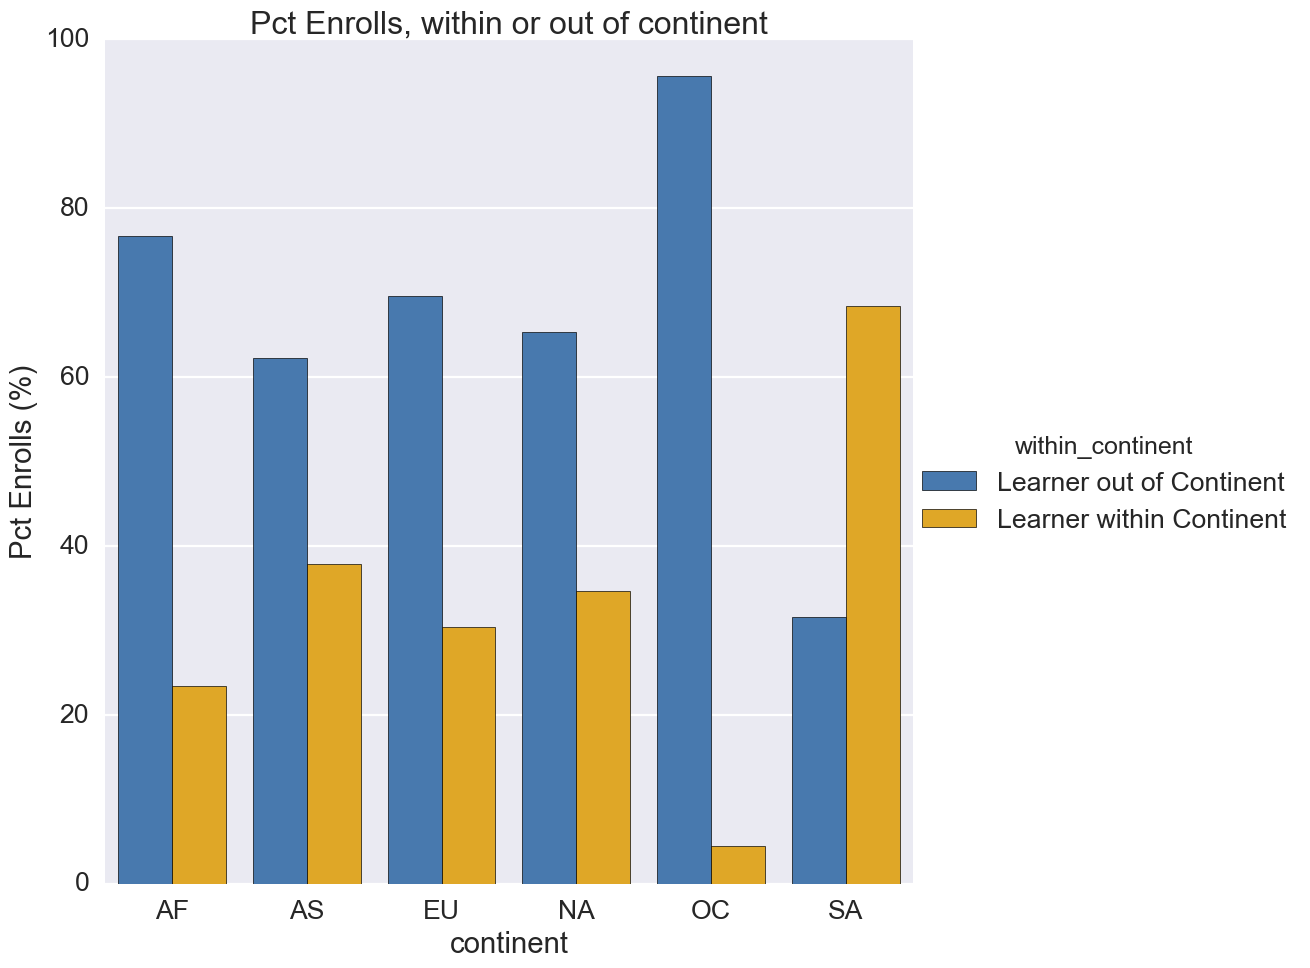

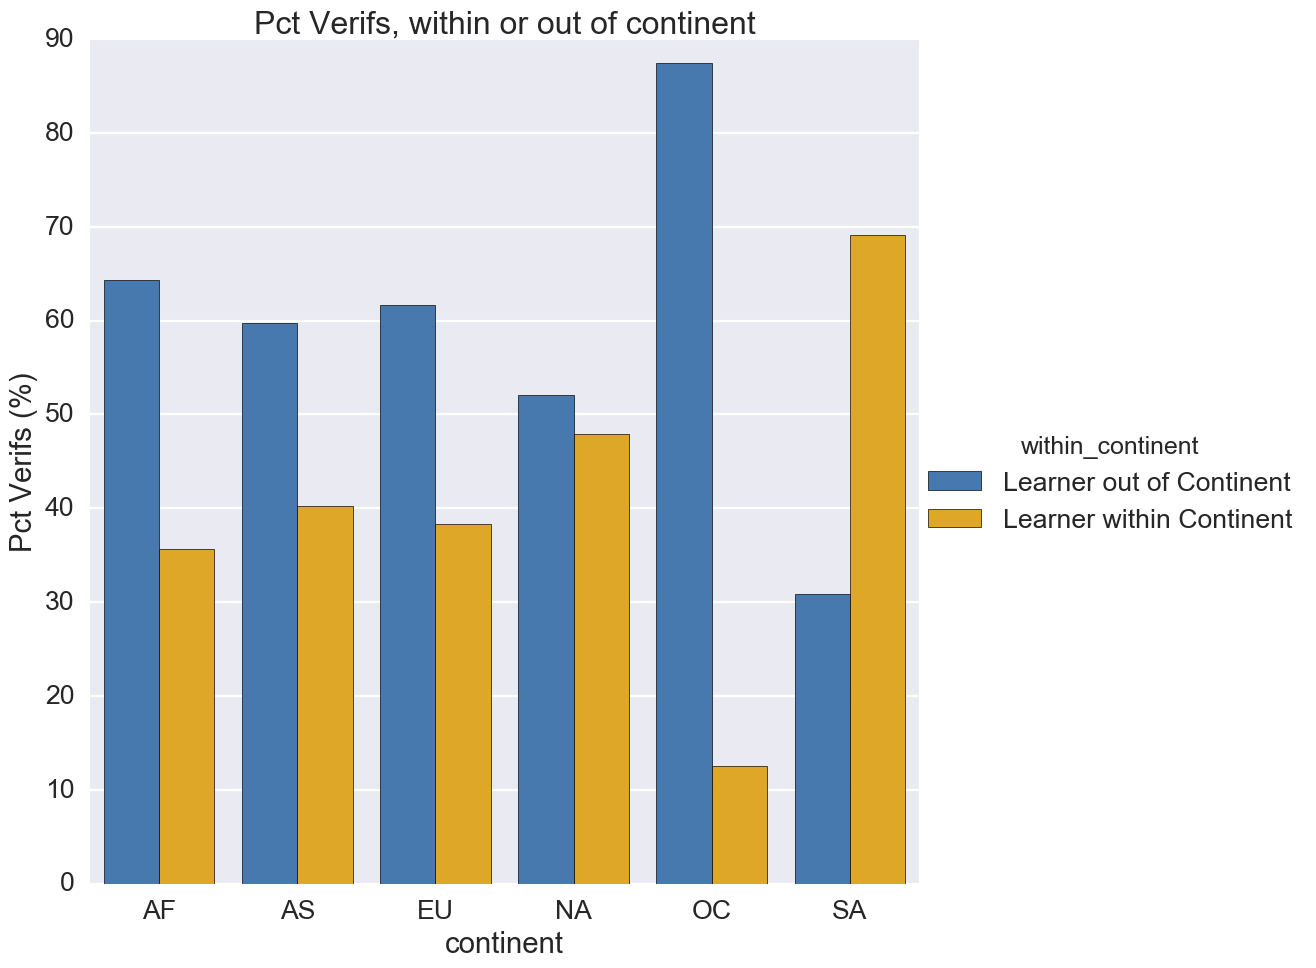

In [233]:
make_plots('continent')

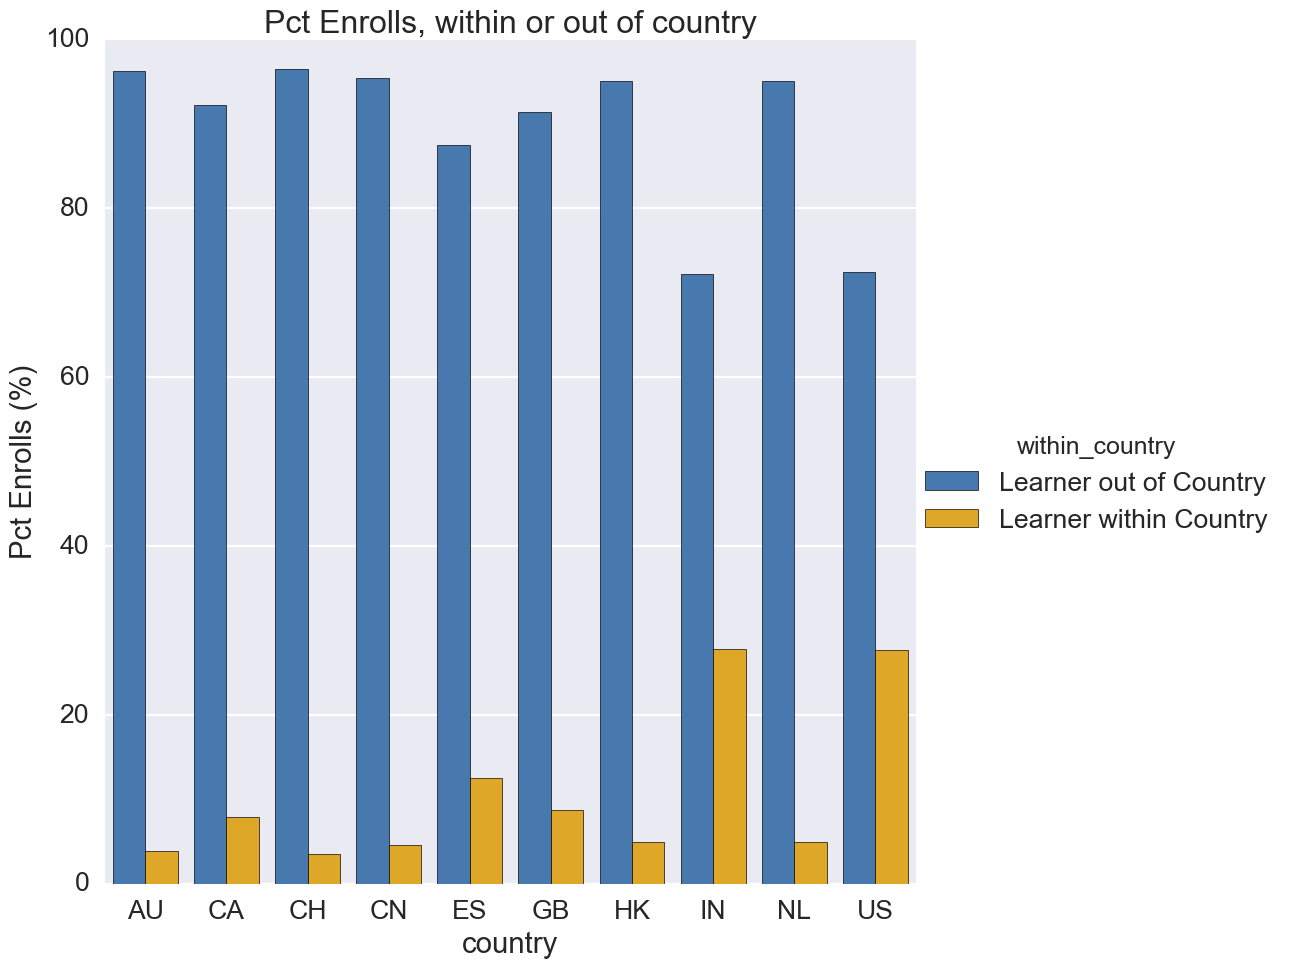

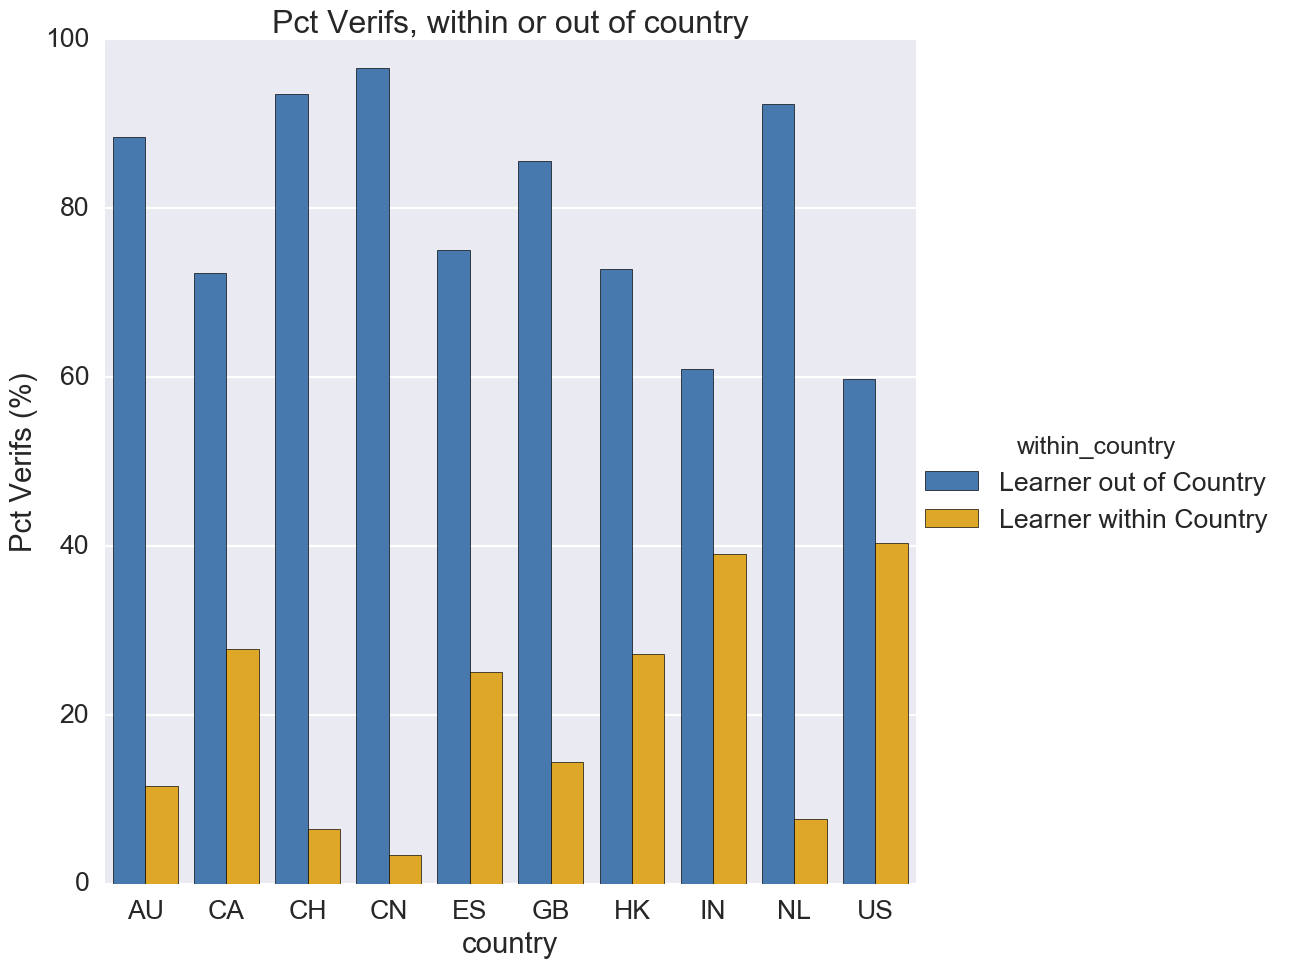

In [234]:
make_plots('country', 10)

In [475]:
content_language_df.head()

cnt_enrolls  cnt_verifs content_language learner_country learner_language  \
0           35           0               fr              SY               ar   
1           24           0               fr              MZ               pt   
2            1           0               de              UZ               uz   
3           14           0               ja              GE               ka   
4           47           1               de              CO               es   

                                     within_country  
0  Learner Language Does Not Match Content Language  
1  Learner Language Does Not Match Content Language  
2  Learner Language Does Not Match Content Language  
3  Learner Language Does Not Match Content Language  
4  Learner Language Does Not Match Content Language

In [479]:
content_language_df_merge = content_language_df.merge(
    content_language_df.groupby('content_language').sum().reset_index(), on = 'content_language', suffixes = ('', '_agg'))

In [481]:
content_language_df_merge['pct_enrolls'] = content_language_df_merge.cnt_enrolls*100.0/content_language_df_merge.cnt_enrolls_agg
content_language_df_merge['pct_verifs'] = content_language_df_merge.cnt_verifs*100.0/content_language_df_merge.cnt_verifs_agg

In [486]:
content_language_df_plot = content_language_df_merge.groupby(['content_language', 'within_country']).sum().reset_index()

In [509]:
content_filter_list = content_language_df_merge.groupby(['content_language']).sum().reset_index().sort_values(
    'cnt_enrolls', ascending=False).head(5).content_language

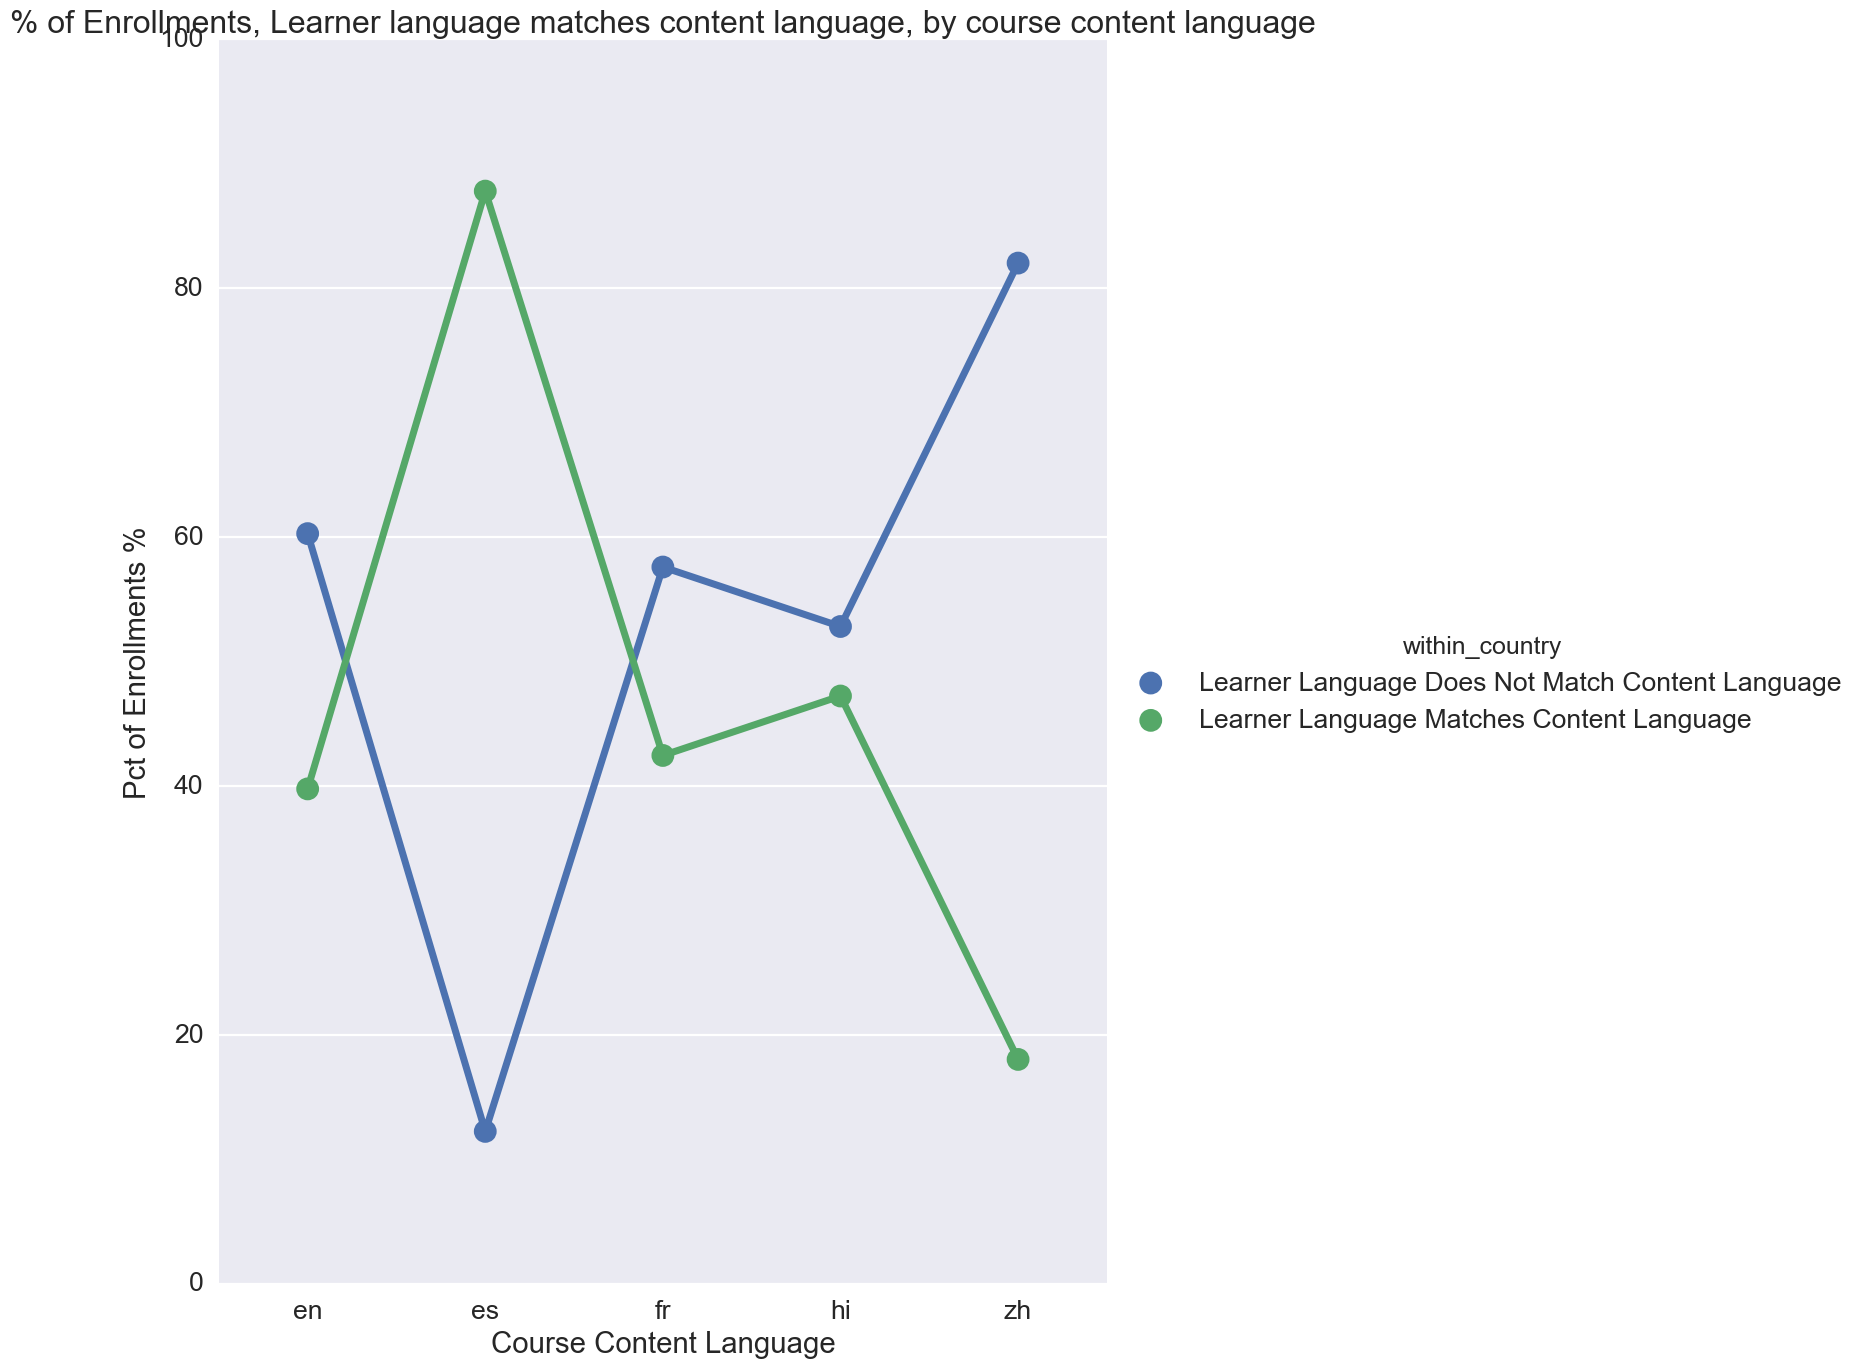

In [551]:
ax = sns.factorplot(data=content_language_df_plot[content_language_df_plot['content_language'].isin(content_filter_list)],
               x='content_language', y = 'pct_enrolls', hue = 'within_country', size = 14, aspect = 0.8)
ax.set(title = '% of Enrollments, Learner language matches content language, by course content language',
      xlabel = 'Course Content Language',
      ylabel = 'Pct of Enrollments %')

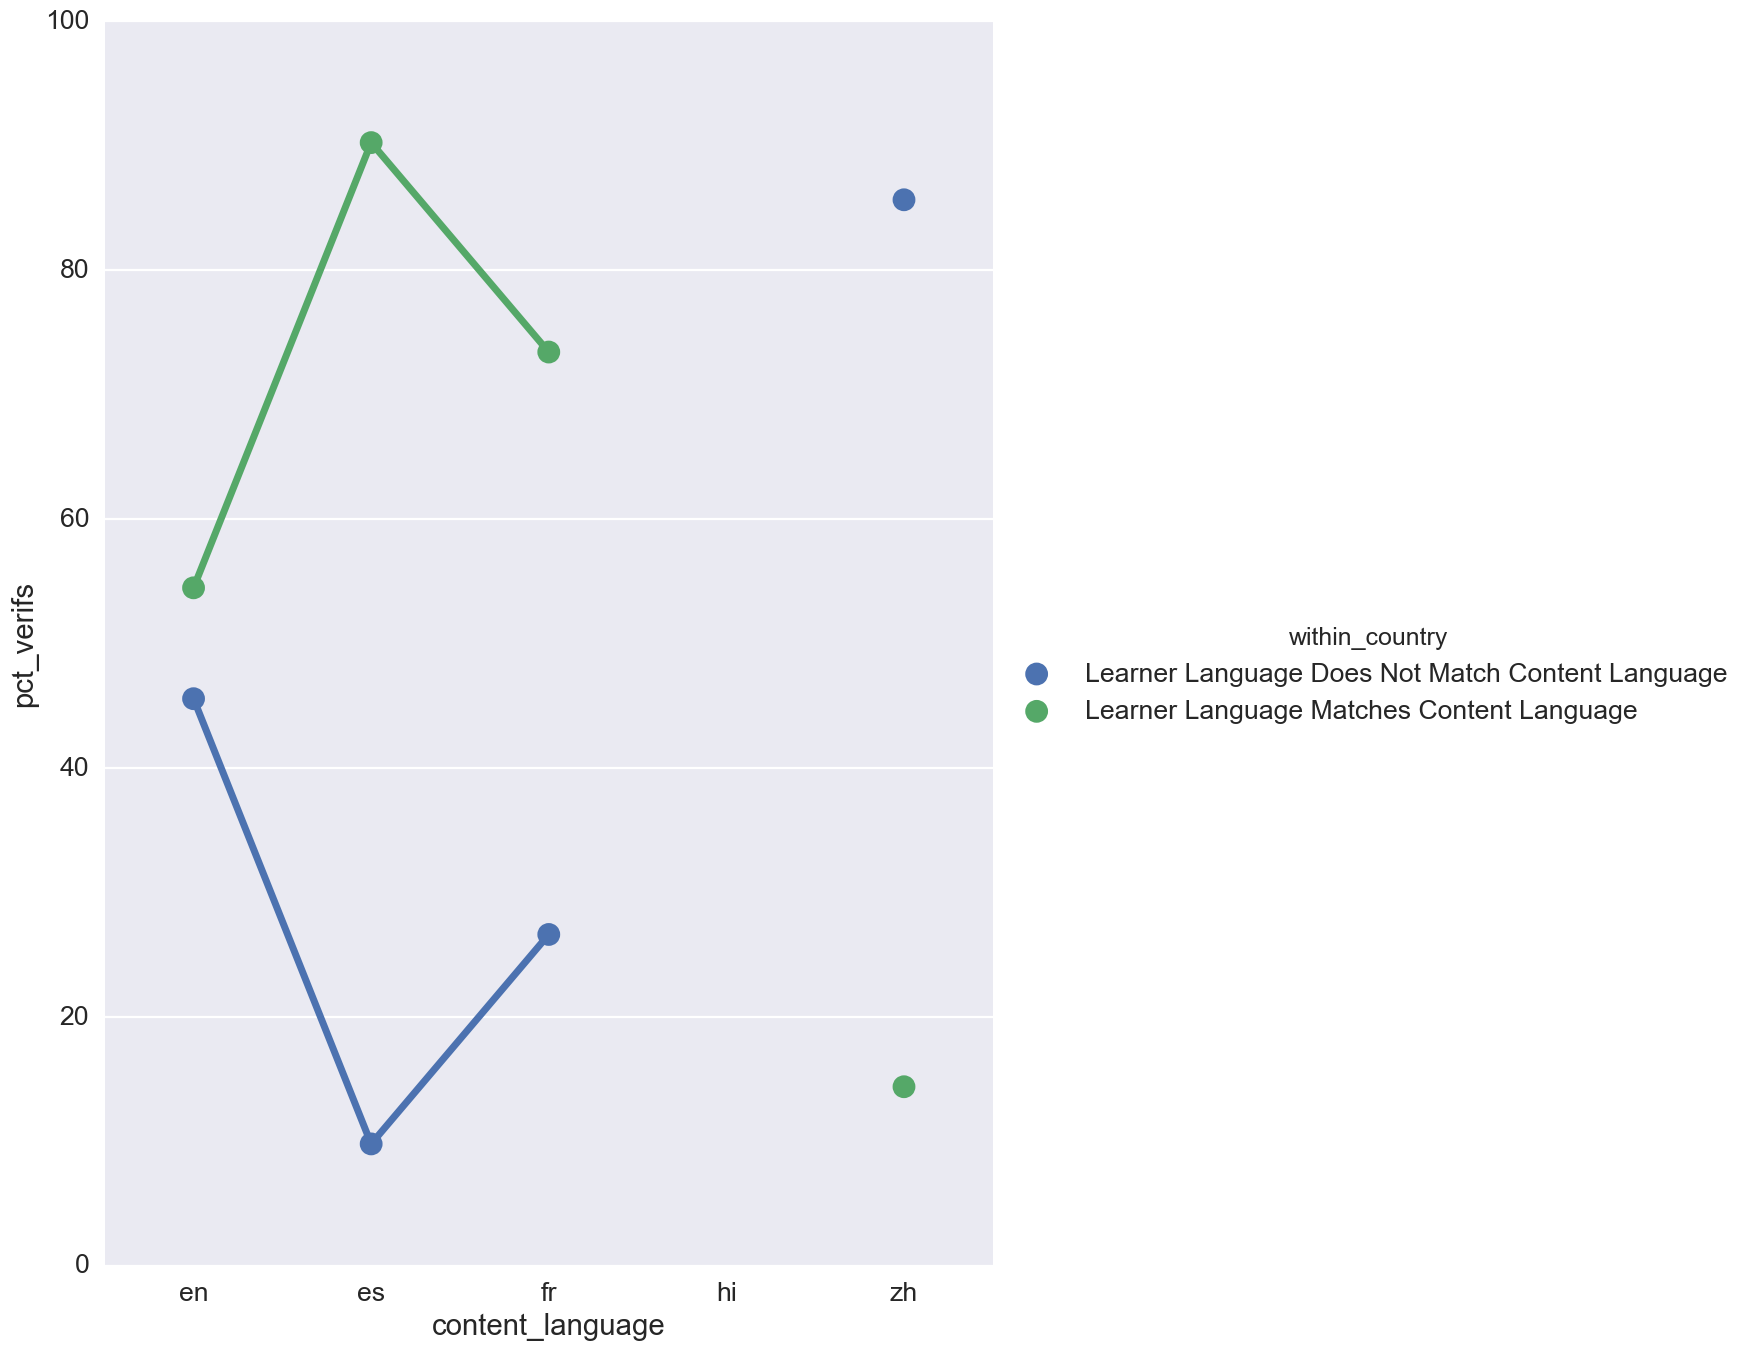

In [552]:
sns.factorplot(data=content_language_df_plot[content_language_df_plot['content_language'].isin(content_filter_list)],
               x='content_language', y = 'pct_verifs', hue = 'within_country', size = 14, aspect = 0.8)
ax.set(title = '% of Verifications, Learner language matches content language, by course content language',
      xlabel = 'Course Content Language',
      ylabel = 'Pct of Verifications %')

In [523]:
content_language_df_merge_learner = content_language_df.merge(
    content_language_df.groupby(['learner_country']).sum().reset_index(), on = 'learner_country', suffixes = ('', '_agg'))

In [540]:
content_language_df_merge_learner.head()

cnt_enrolls  cnt_verifs content_language learner_country learner_language  \
0           35           0               fr              SY               ar   
1           24           0               es              SY               ar   
2           30           0               zh              SY               ar   
3            1           0               nl              SY               ar   
4            2           0               de              SY               ar   

                                     within_country  cnt_enrolls_agg  \
0  Learner Language Does Not Match Content Language            11896   
1  Learner Language Does Not Match Content Language            11896   
2  Learner Language Does Not Match Content Language            11896   
3  Learner Language Does Not Match Content Language            11896   
4  Learner Language Does Not Match Content Language            11896   

   cnt_verifs_agg  pct_enrolls  pct_verifs  
0              41     0.294217         0.0  
1              41     0.201748         0.0  
2              41     0.252186         0.0  
3              41     0.008406         0.0  
4              41     0.016812         0.0

In [526]:
content_language_df_merge_learner['pct_enrolls'] = content_language_df_merge_learner.cnt_enrolls*100.0/content_language_df_merge_learner.cnt_enrolls_agg
content_language_df_merge_learner['pct_verifs'] = content_language_df_merge_learner.cnt_verifs*100.0/content_language_df_merge_learner.cnt_verifs_agg

In [532]:
content_language_df_merge_learner_plot = content_language_df_merge_learner.groupby(['learner_country', 'within_country', 'learner_language']).sum().reset_index()

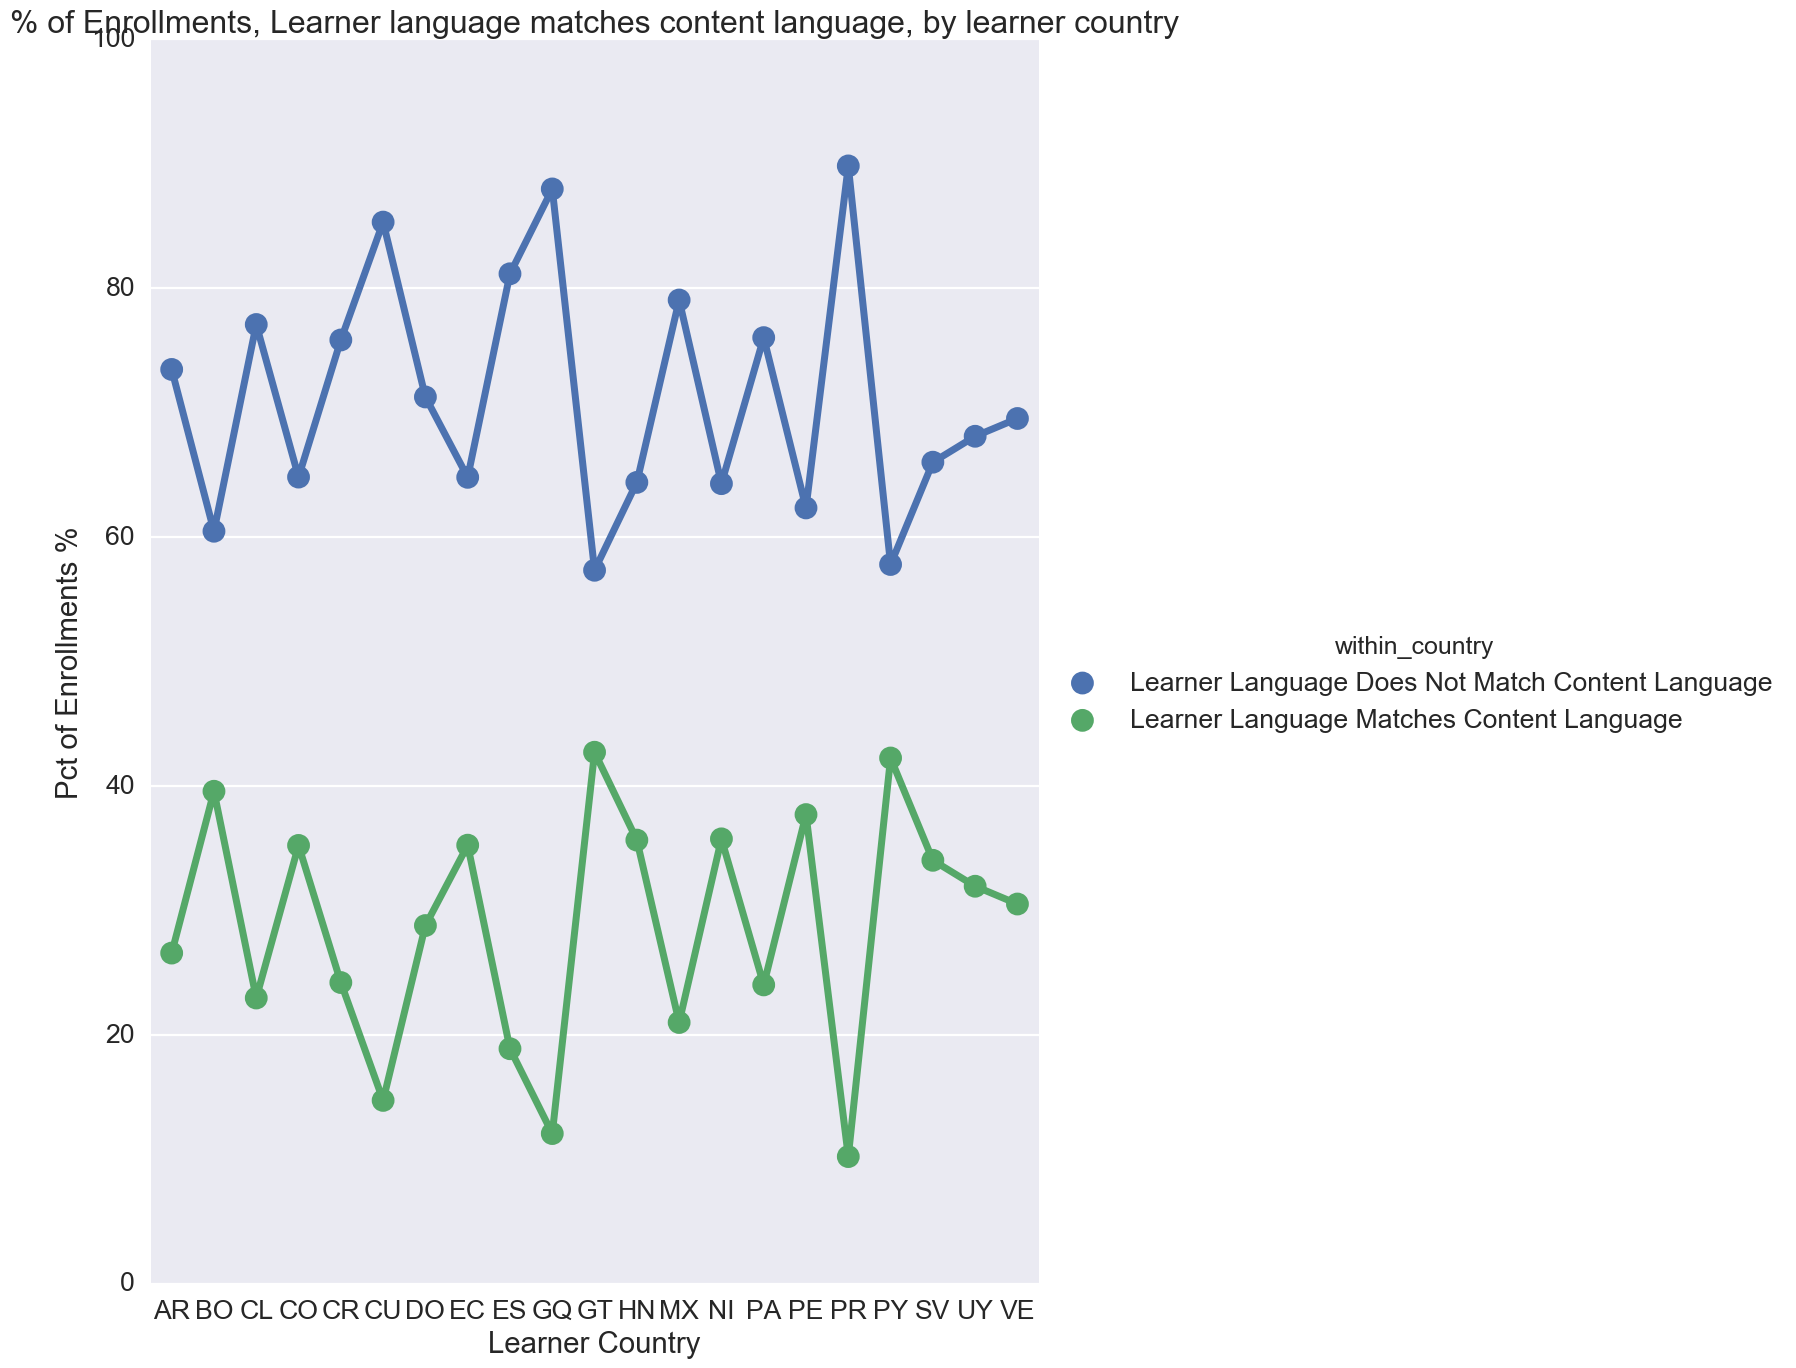

In [550]:
ax = sns.factorplot(data=content_language_df_merge_learner_plot[content_language_df_merge_learner_plot.learner_language=='es'],
               x='learner_country', y = 'pct_enrolls', hue = 'within_country', size = 14, aspect = 0.8)
ax.set(title = '% of Enrollments, Learner language matches content language, by learner country',
      xlabel = 'Learner Country',
      ylabel = 'Pct of Enrollments %')

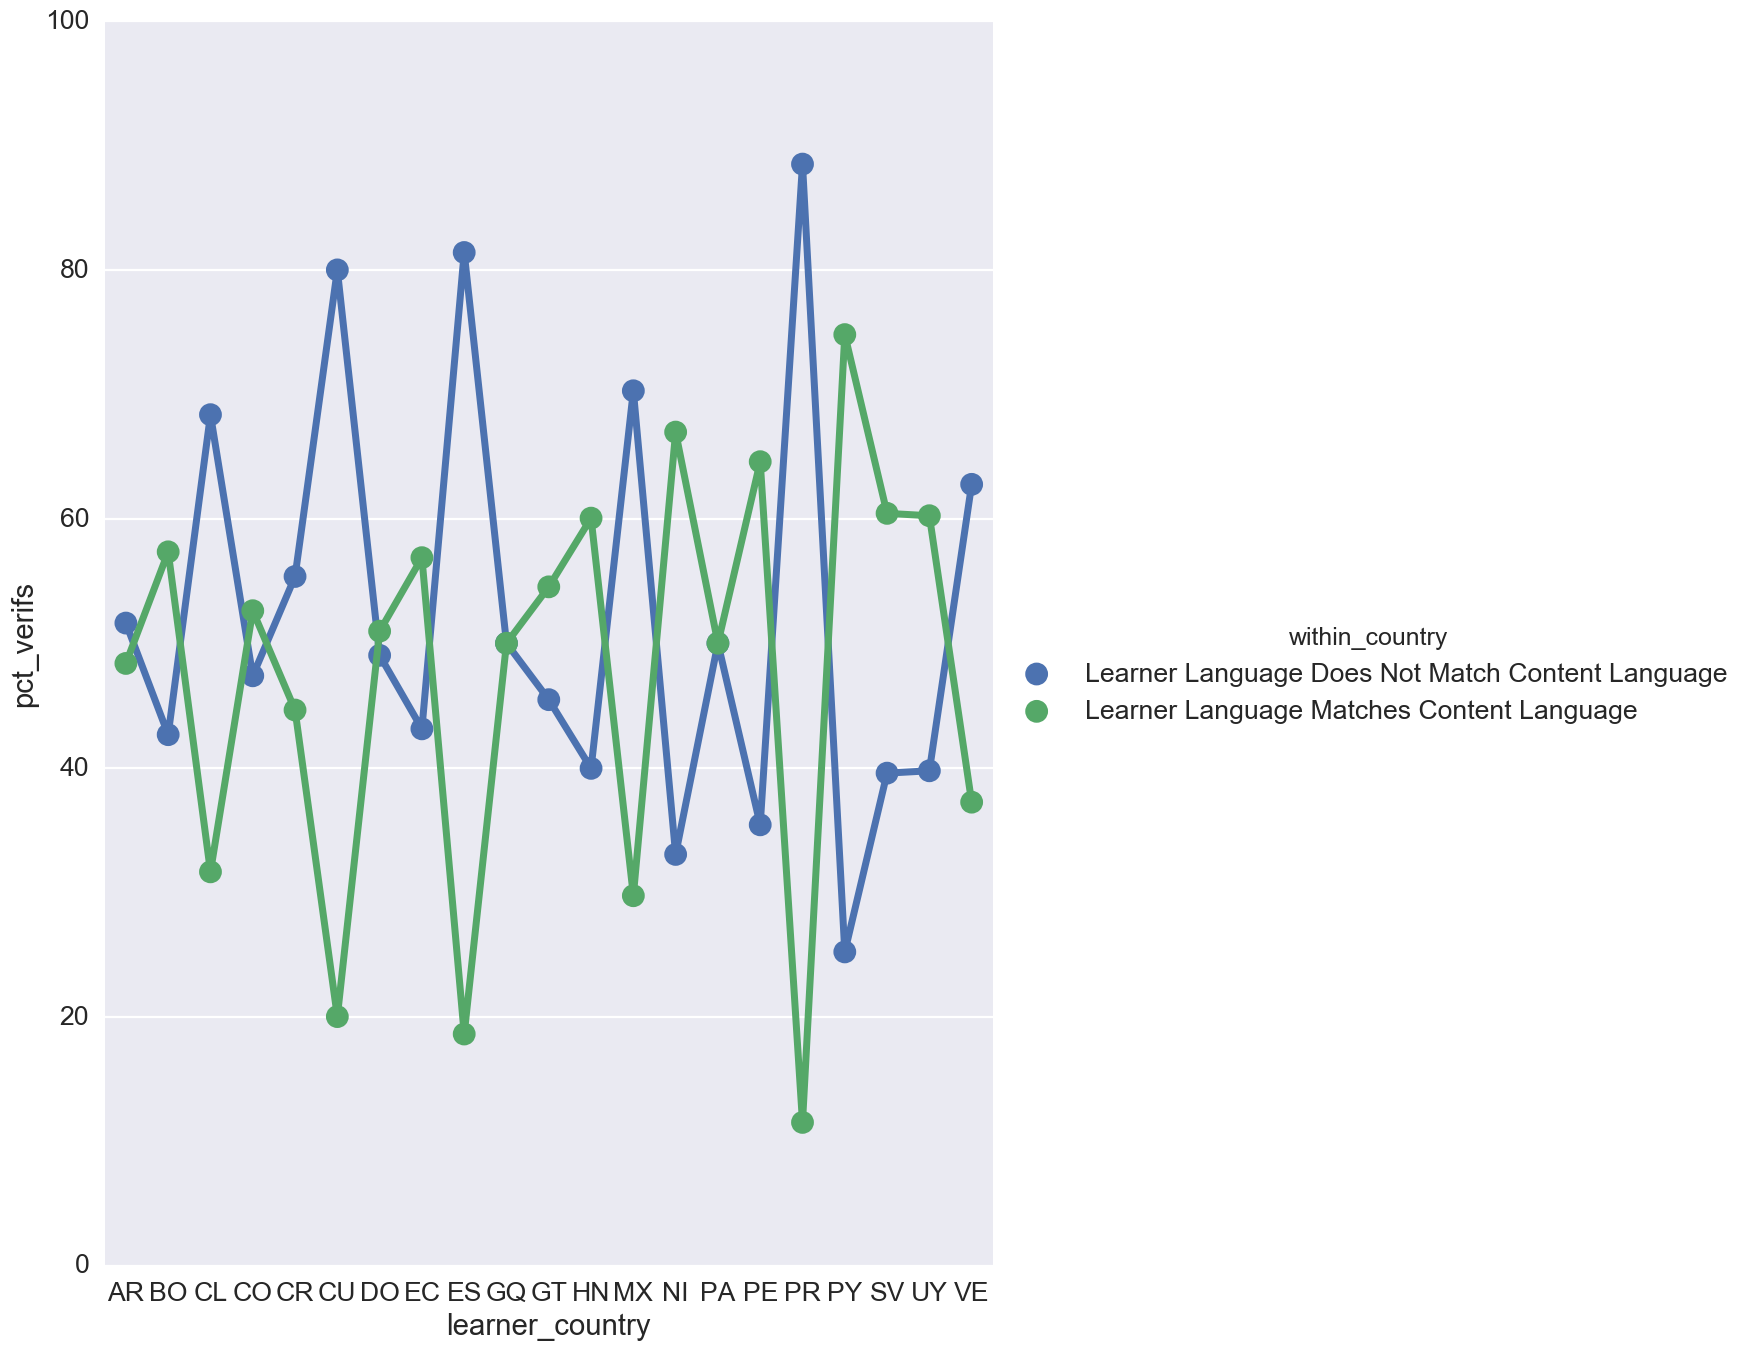

In [541]:
sns.factorplot(data=content_language_df_merge_learner_plot[content_language_df_merge_learner_plot.learner_language=='es'],
               x='learner_country', y = 'pct_verifs', hue = 'within_country', size = 14, aspect = 0.8)

In [504]:
content_filter_list = content_language_df_merge.groupby(['content_language']).sum().reset_index().sort_values(
    'cnt_verifs', ascending=False).head(15).content_language

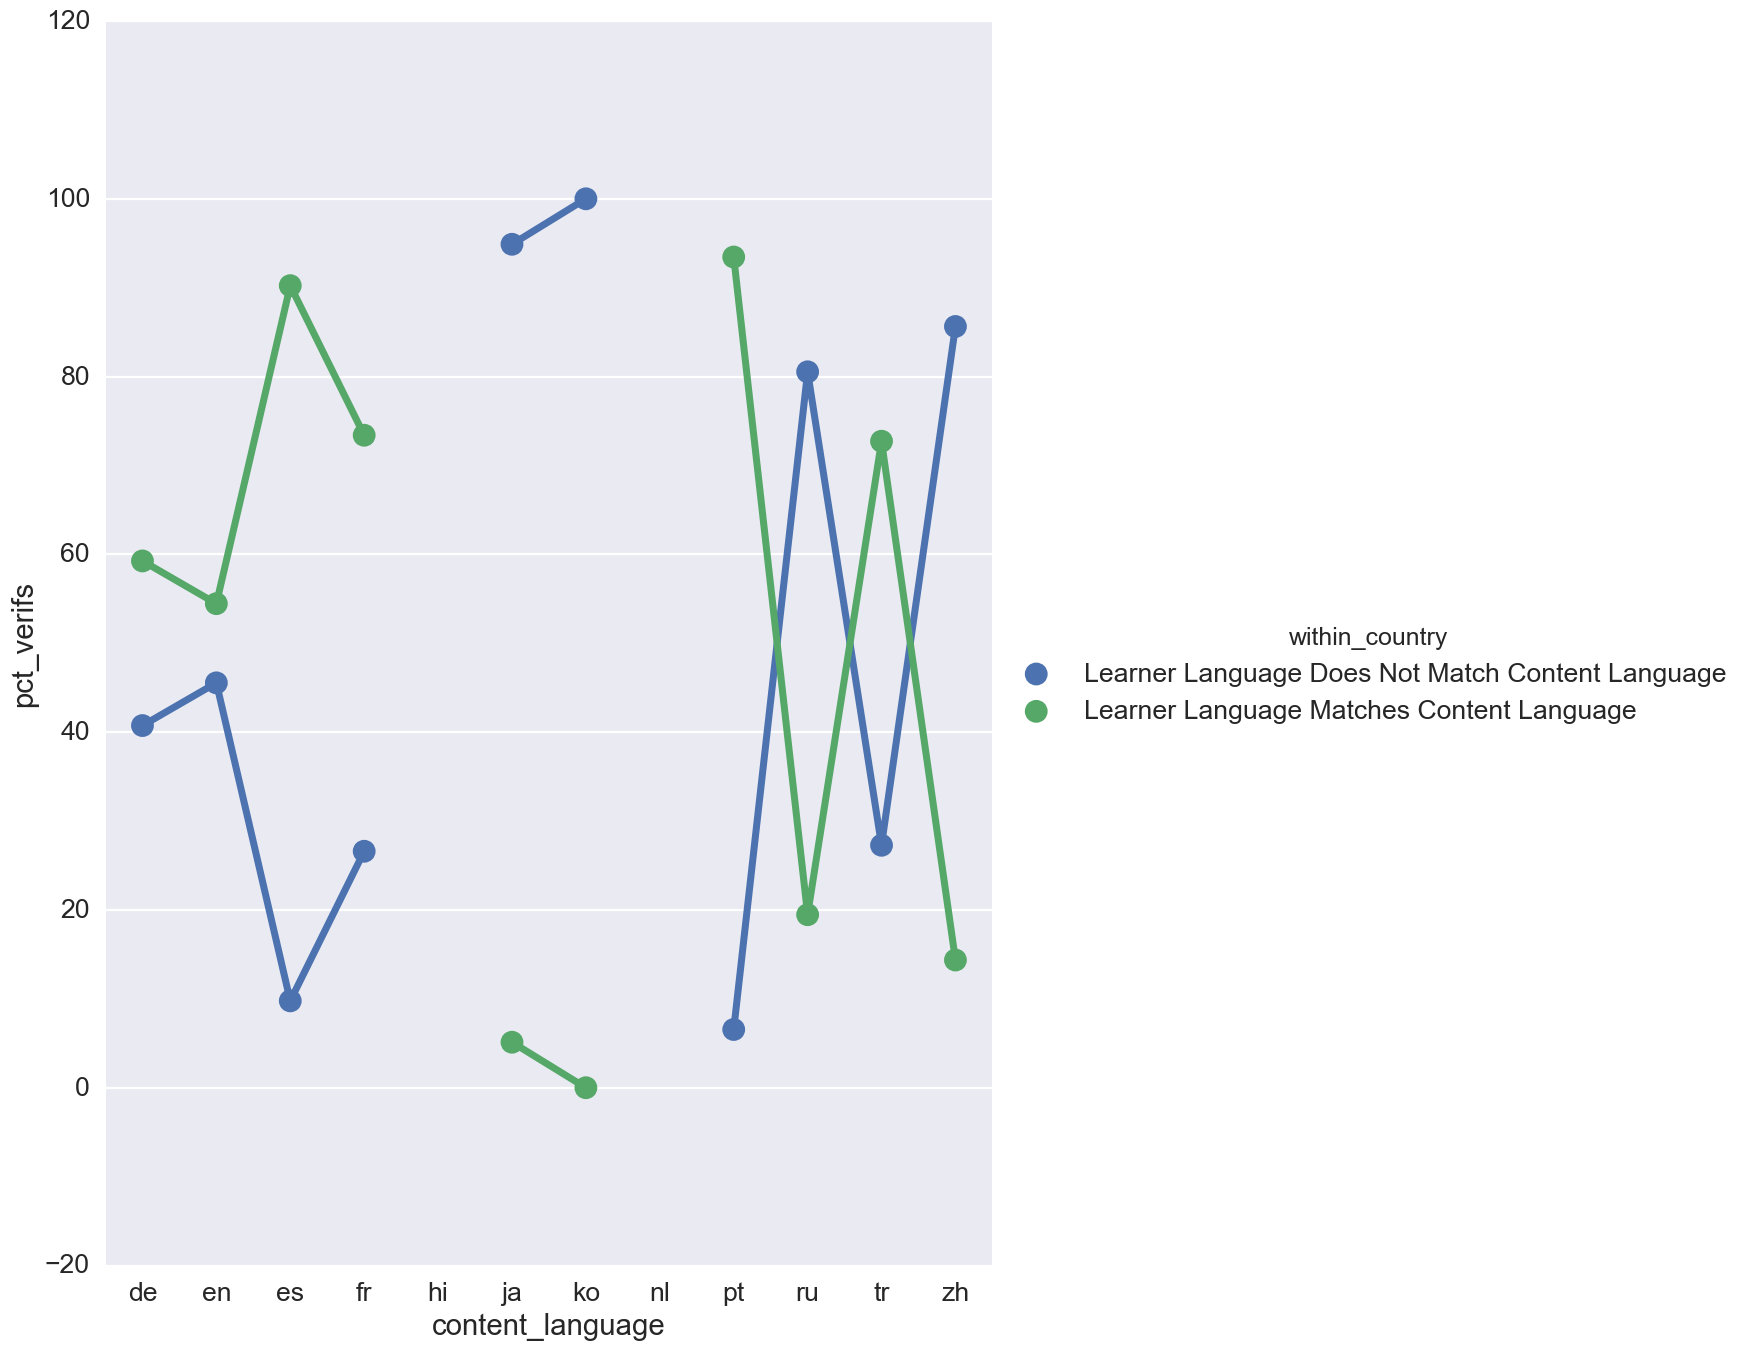

In [505]:
sns.factorplot(data=content_language_df_plot[content_language_df_plot['content_language'].isin(content_filter_list)],
               x='content_language', y = 'pct_verifs', hue = 'within_country', size = 14, aspect = 0.8)

In [508]:
content_language_df_merge[content_language_df_merge.content_language=='hi'].sort_values('pct_verifs', ascending = False)

cnt_enrolls  cnt_verifs content_language learner_country  \
1475            1           0               hi              RU   
1476           10           0               hi              PK   
1477            1           0               hi              NL   
1478        15729           0               hi              IN   
1479        13694           0               hi              CA   
1480            1           0               hi              EG   
1481            1           0               hi              UG   
1482            6           0               hi              CN   
1483            1           0               hi              LK   
1484            1           0               hi              PE   
1485            4           0               hi              AE   
1486            2           0               hi              HK   
1487           17           0               hi              AU   
1488            3           0               hi              NP   
1489            1           0               hi              PG   
1490            2           0               hi              BD   
1491           10           0               hi              DE   
1492            1           0               hi              MY   
1493            2           0               hi              RO   
1494            1           0               hi              IT   
1495            1           0               hi              UA   
1496           13           0               hi              ID   
1497            1           0               hi              FJ   
1498         3753           0               hi              US   
1499            3           0               hi              KR   
1500            1           0               hi              VN   
1501            1           0               hi              SR   
1502            7           0               hi              PH   
1503           10           0               hi              GB   
1504            1           0               hi              GE   
1505            1           0               hi              ES   
1506            1           0               hi              QA   
1507            1           0               hi              MU   
1508           36           0               hi              JP   
1509            1           0               hi              SG   

     learner_language                                    within_country  \
1475               ru  Learner Language Does Not Match Content Language   
1476               en  Learner Language Does Not Match Content Language   
1477               nl  Learner Language Does Not Match Content Language   
1478               hi         Learner Language Matches Content Language   
1479               en  Learner Language Does Not Match Content Language   
1480               ar  Learner Language Does Not Match Content Language   
1481               en  Learner Language Does Not Match Content Language   
1482               zh  Learner Language Does Not Match Content Language   
1483               si  Learner Language Does Not Match Content Language   
1484               es  Learner Language Does Not Match Content Language   
1485               ar  Learner Language Does Not Match Content Language   
1486               zh  Learner Language Does Not Match Content Language   
1487               en  Learner Language Does Not Match Content Language   
1488               ne  Learner Language Does Not Match Content Language   
1489               en  Learner Language Does Not Match Content Language   
1490               bn  Learner Language Does Not Match Content Language   
1491               de  Learner Language Does Not Match Content Language   
1492                   Learner Language Does Not Match Content Language   
1493               ro  Learner Language Does Not Match Content Language   
1494               it  Learner Language Does Not Match Content Language   
1495               uk  Learner Language Does Not Match

In [471]:
# make_plots('language', 10)

## Enrolls and Verifs, by University Continent, Subject

In [237]:
continent_list = master_df.university_continent.unique()

In [ ]:
def make_plots_subject(comparison, num_bars = 100):
    df = master_df
    df = df[df[comparison] == i]
    df_agg = df.groupby('subject_title').sum()
    df_agg['pct_enrolls'] = df_agg.cnt_enrolls * 100.0/df.sum()['cnt_enrolls']
    df_agg['pct_verifs'] = df_agg.cnt_verifs * 100.0/df.sum()['cnt_verifs']
    
    ax = sns.factorplot(data = df_agg.reset_index().sort_values('pct_enrolls', ascending=False).head(10), y = 'pct_enrolls', x = 'subject_title',
              kind = 'bar', size = 10) 
    ax.set(title=i)
    ax.set_xticklabels(rotation=90)

In [442]:
df_agg = df.groupby(['subject_title','university_continent']).sum().reset_index()
df_agg_merge = df_agg.merge(df.groupby(['university_continent']).sum().reset_index(), on = 'university_continent'
                           , suffixes = ('', '_aggregate'))
df_agg_merge['pct_enrolls'] = df_agg_merge.cnt_enrolls * 100.0/df_agg_merge.cnt_enrolls_aggregate
df_agg_merge['pct_verifs'] = df_agg_merge.cnt_verifs * 100.0/df_agg_merge.cnt_verifs_aggregate

In [451]:
subject_list_filter = df.groupby(['subject_title']).sum().reset_index().sort_values('cnt_enrolls',ascending=False).head(10).subject_title

In [444]:
df_agg_merge.head()

subject_title university_continent  cnt_enrolls  cnt_verifs  \
0             Architecture                   AS        24546         310   
1            Art & Culture                   AS        27507         185   
2  Biology & Life Sciences                   AS        36791         479   
3    Business & Management                   AS       161830        1524   
4                Chemistry                   AS        13143          92   

   cnt_enrolls_aggregate  cnt_verifs_aggregate  pct_enrolls  pct_verifs  
0                 626995                  4484     3.914864    6.913470  
1                 626995                  4484     4.387116    4.125781  
2                 626995                  4484     5.867830   10.682426  
3                 626995                  4484    25.810413   33.987511  
4                 626995                  4484     2.096189    2.051740

In [466]:
# ax = sns.factorplot(data = df_agg_merge[df_agg_merge['subject_title'].isin(subject_list_filter)], x = 'subject_title', y = 'pct_enrolls', 
#                row = 'university_continent',
#                kind = 'bar', size = 10)
# ax.set_xticklabels(rotation=90)

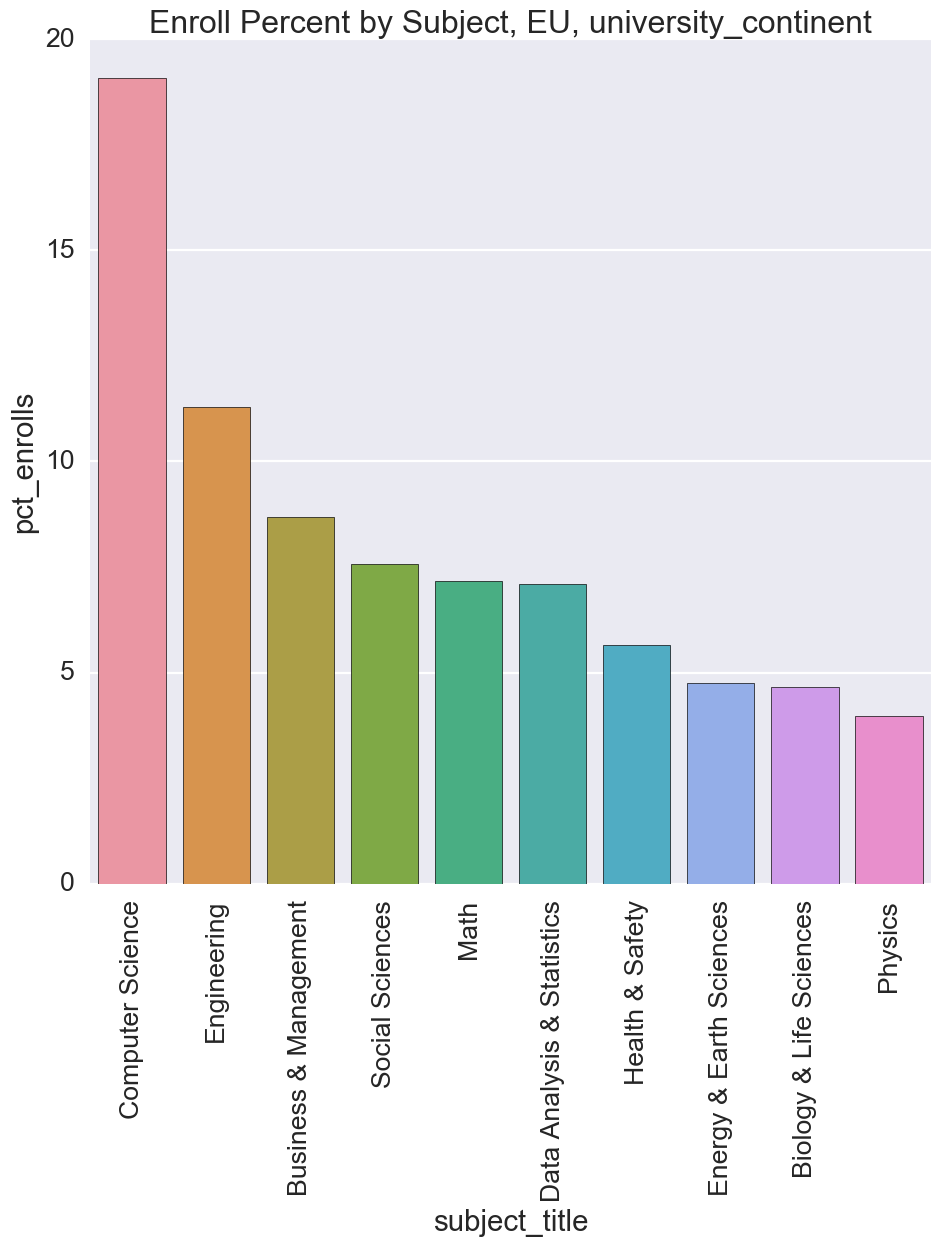

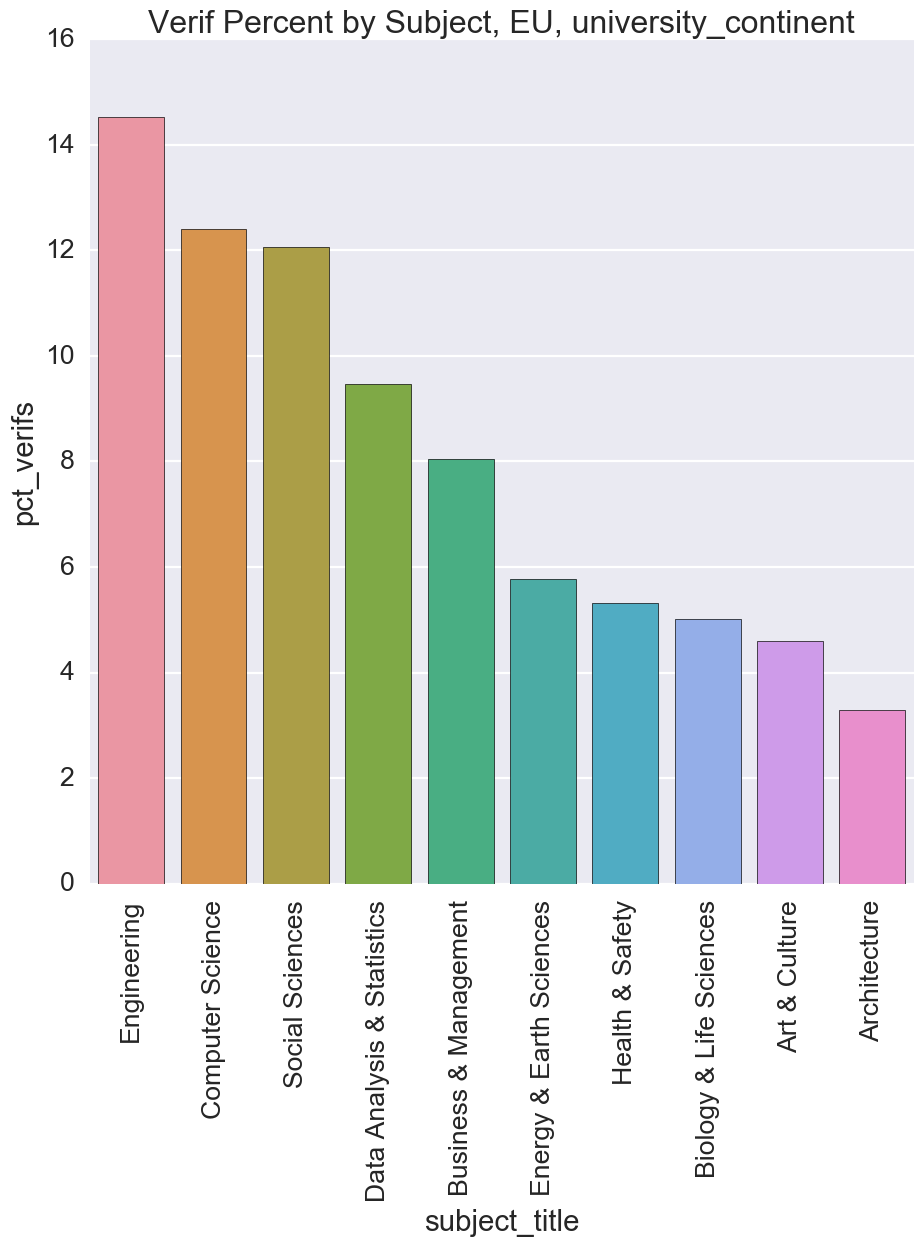

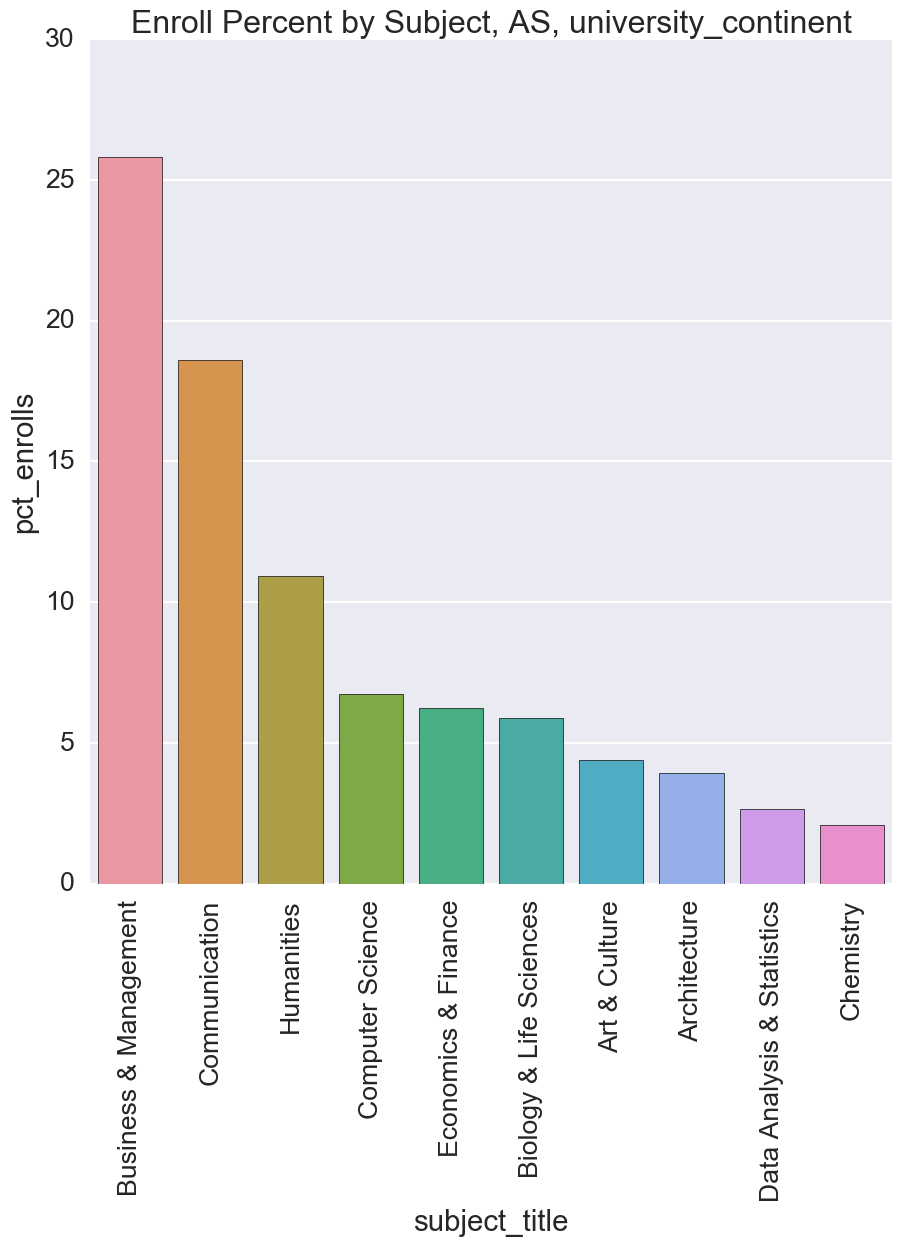

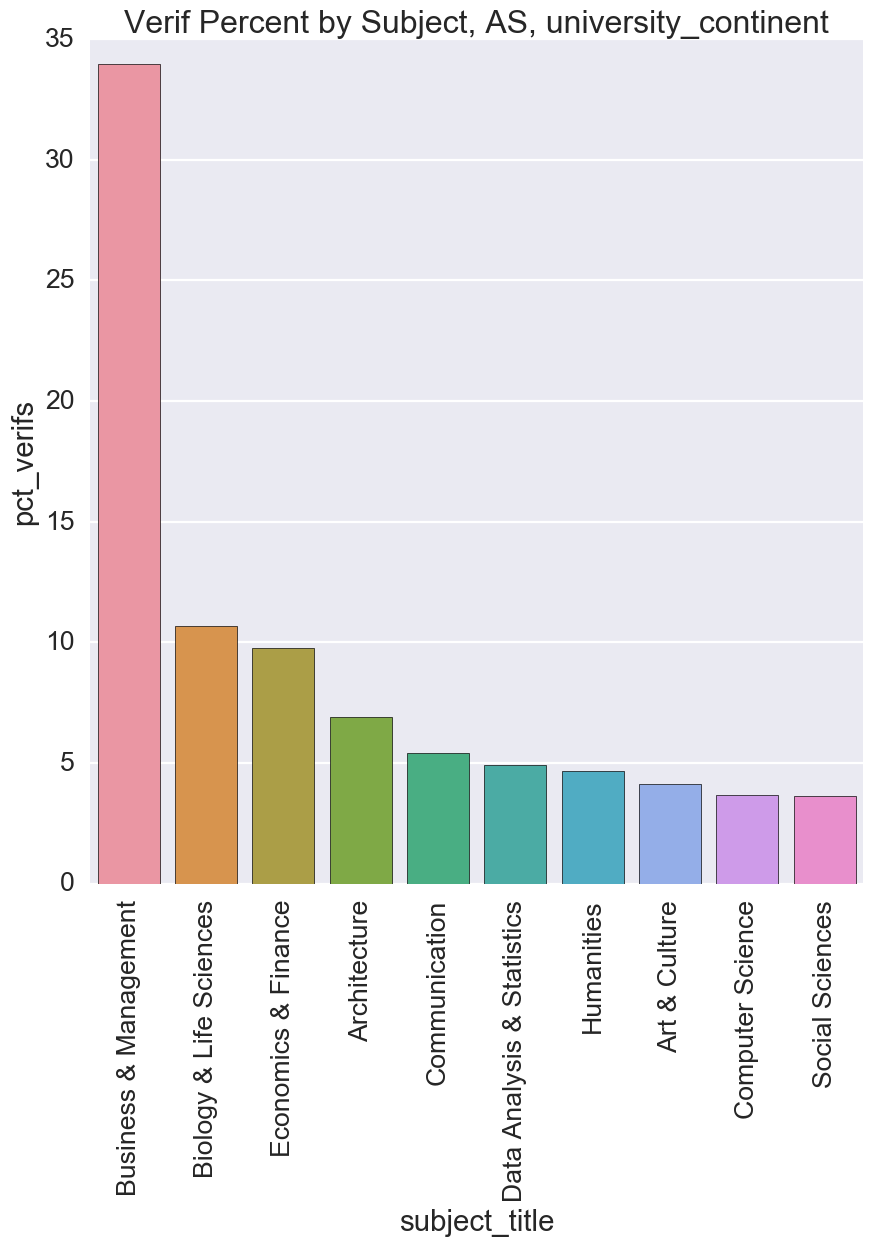

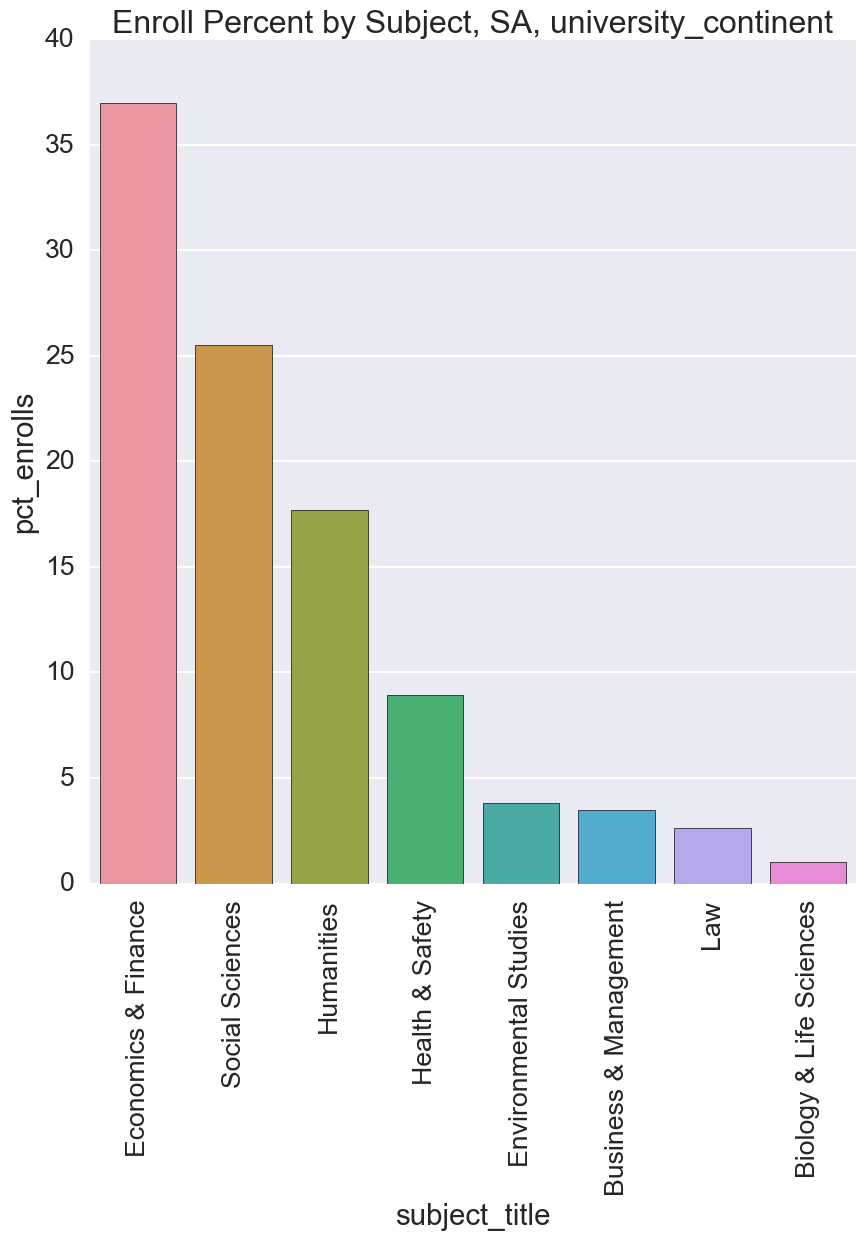

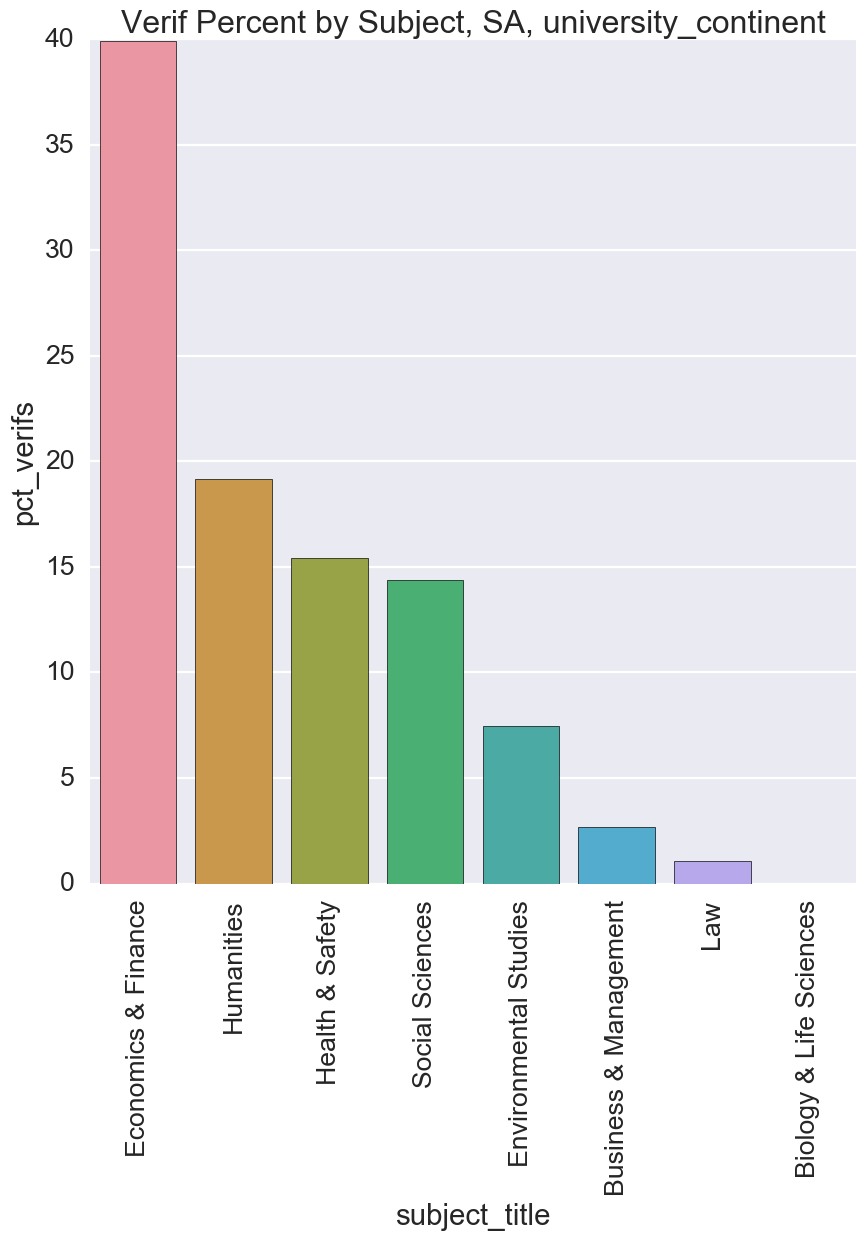

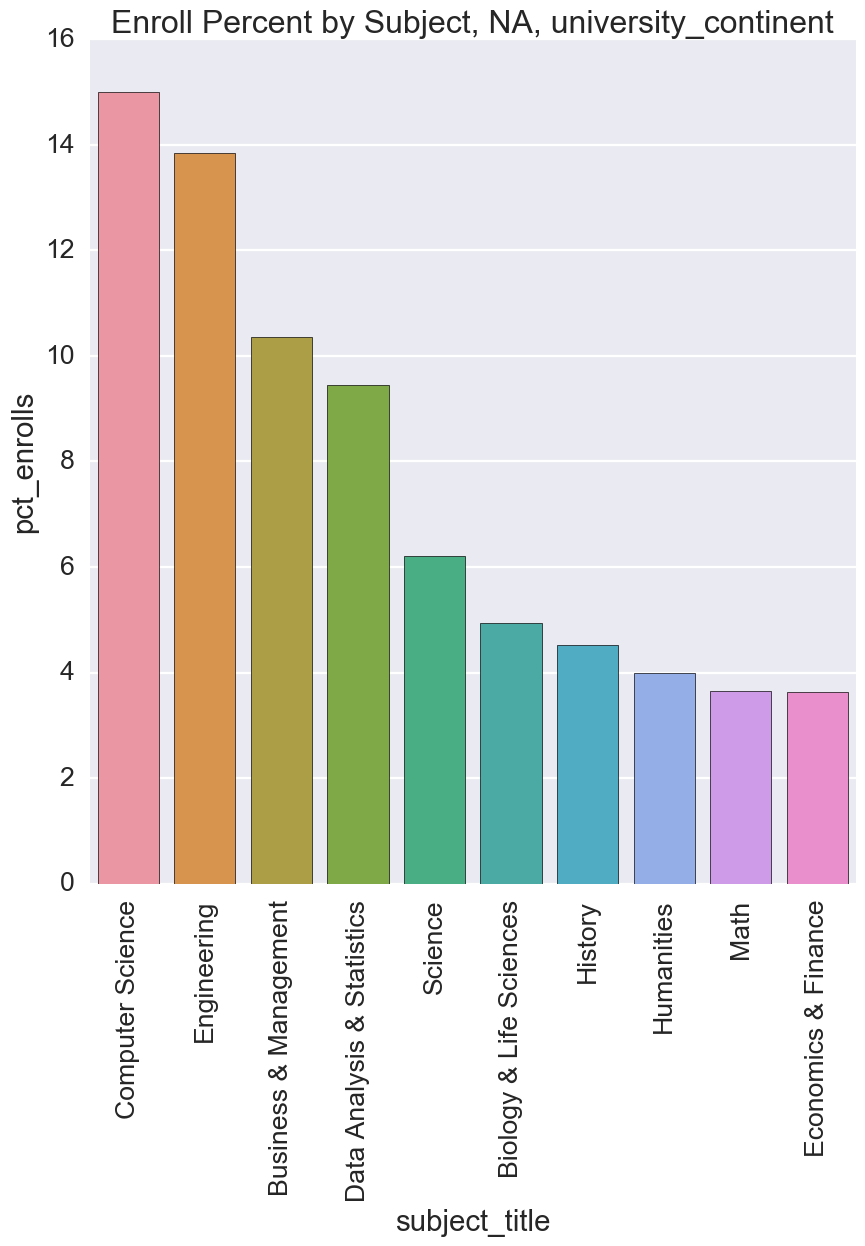

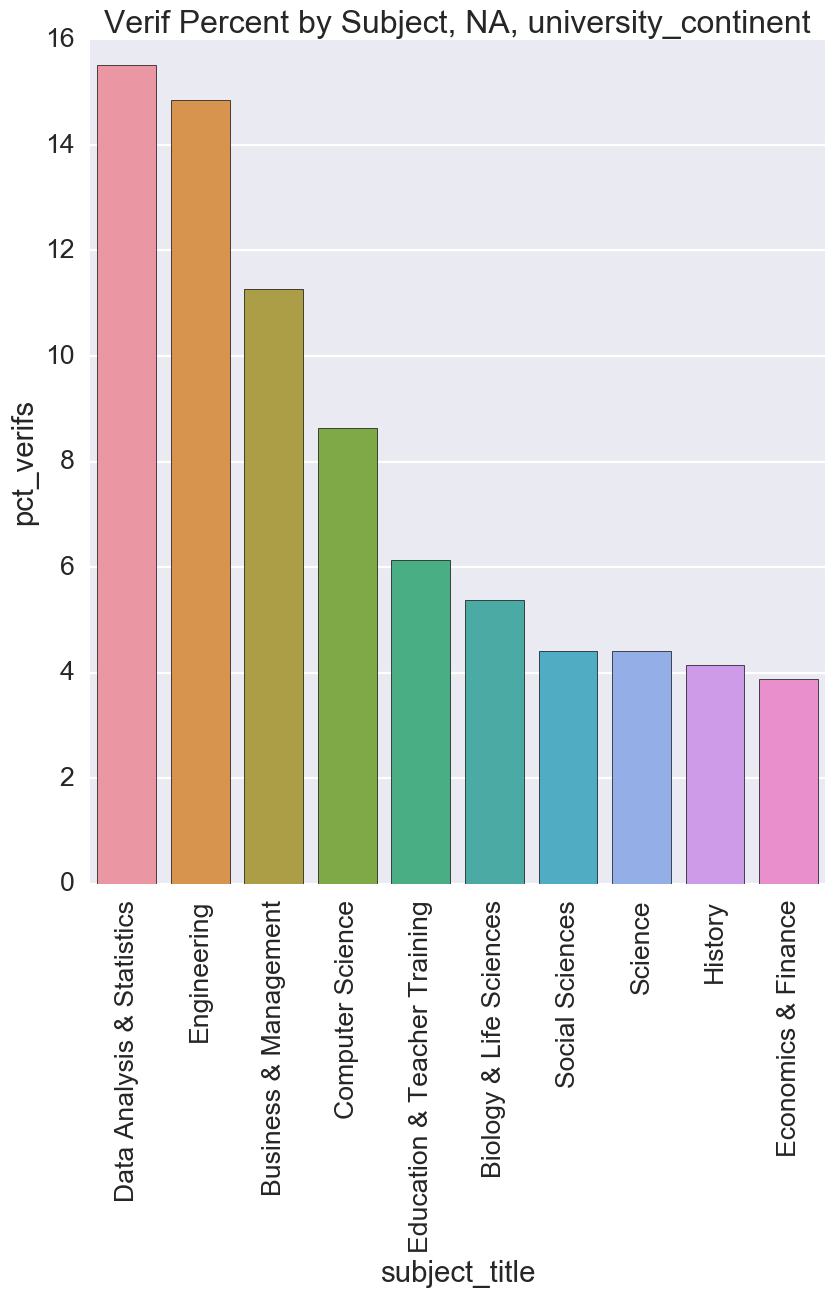

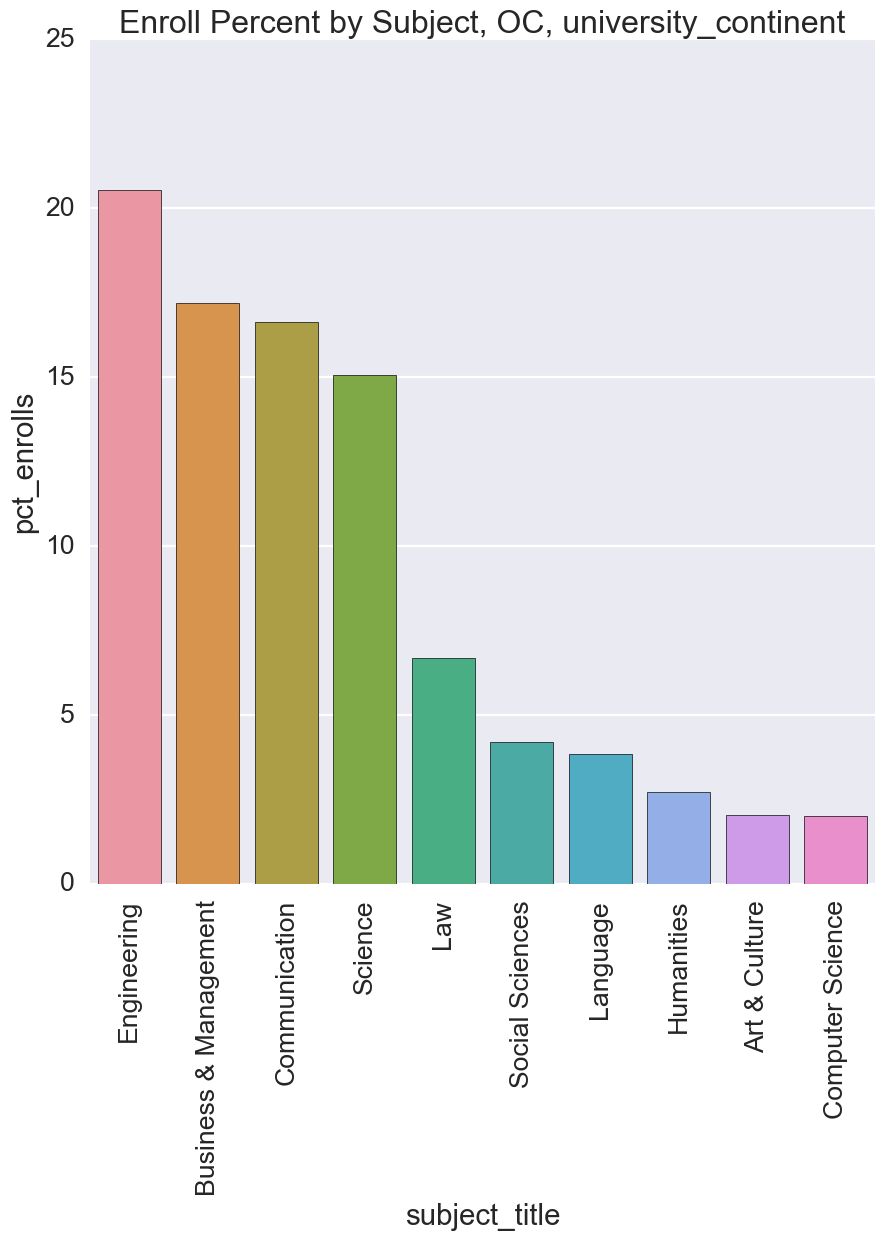

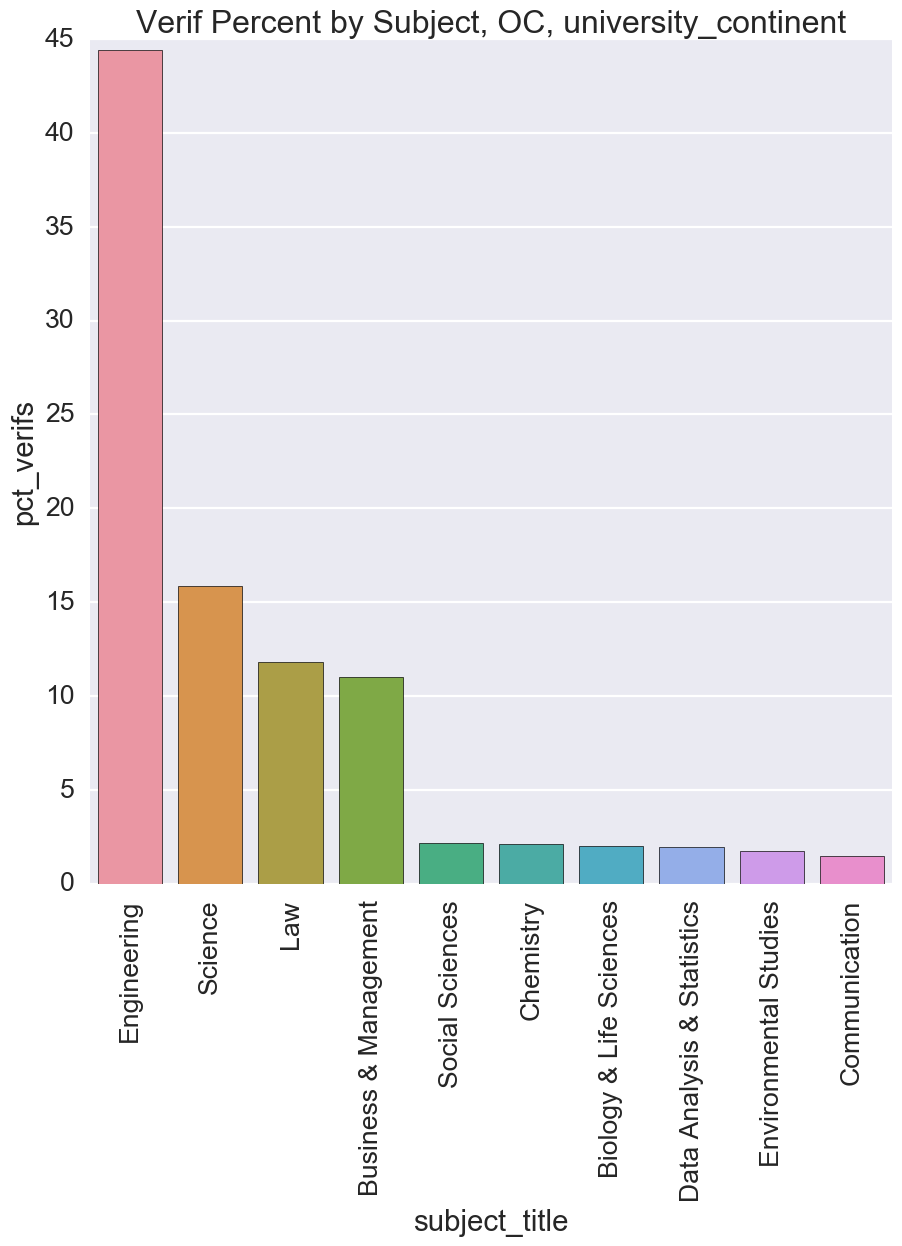

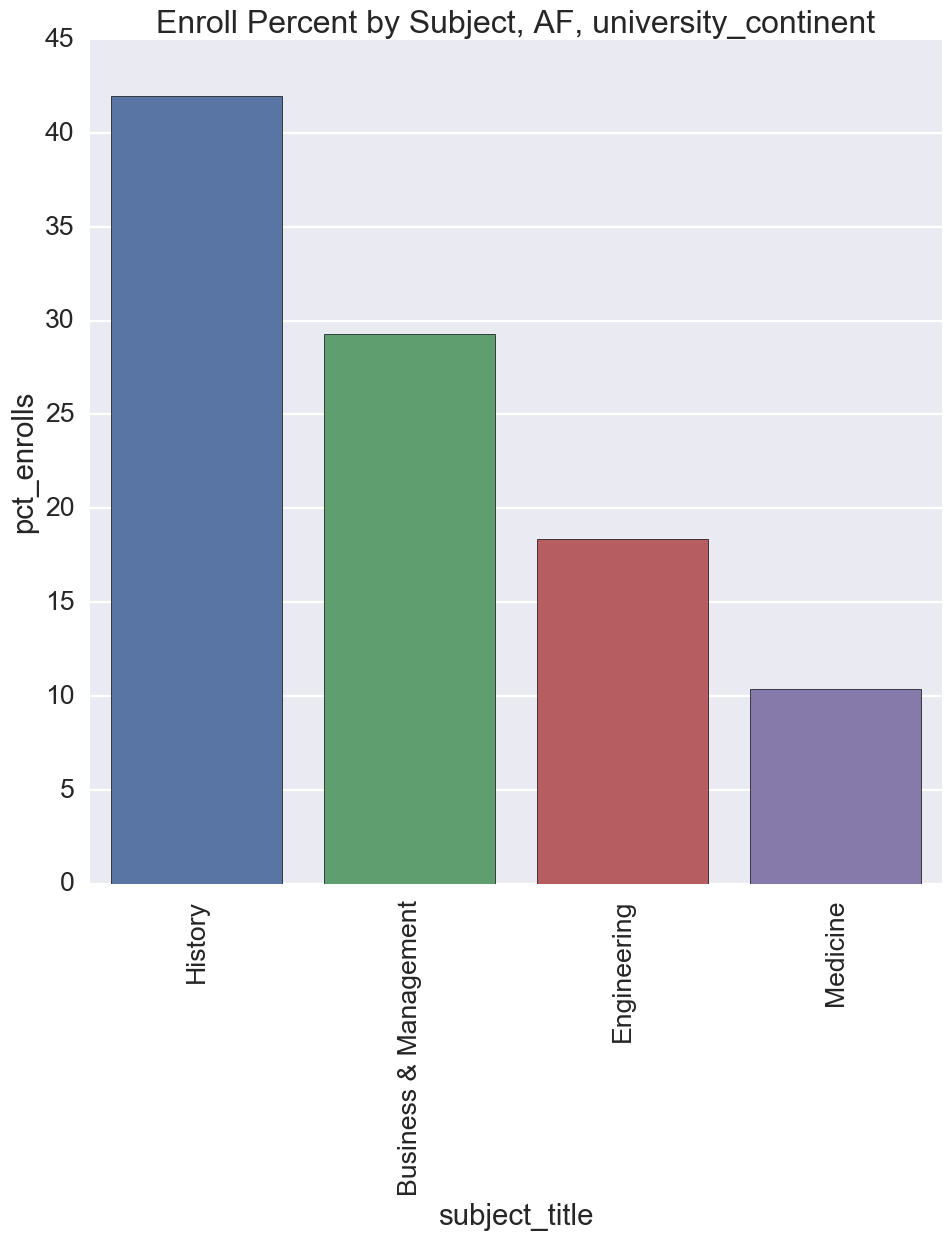

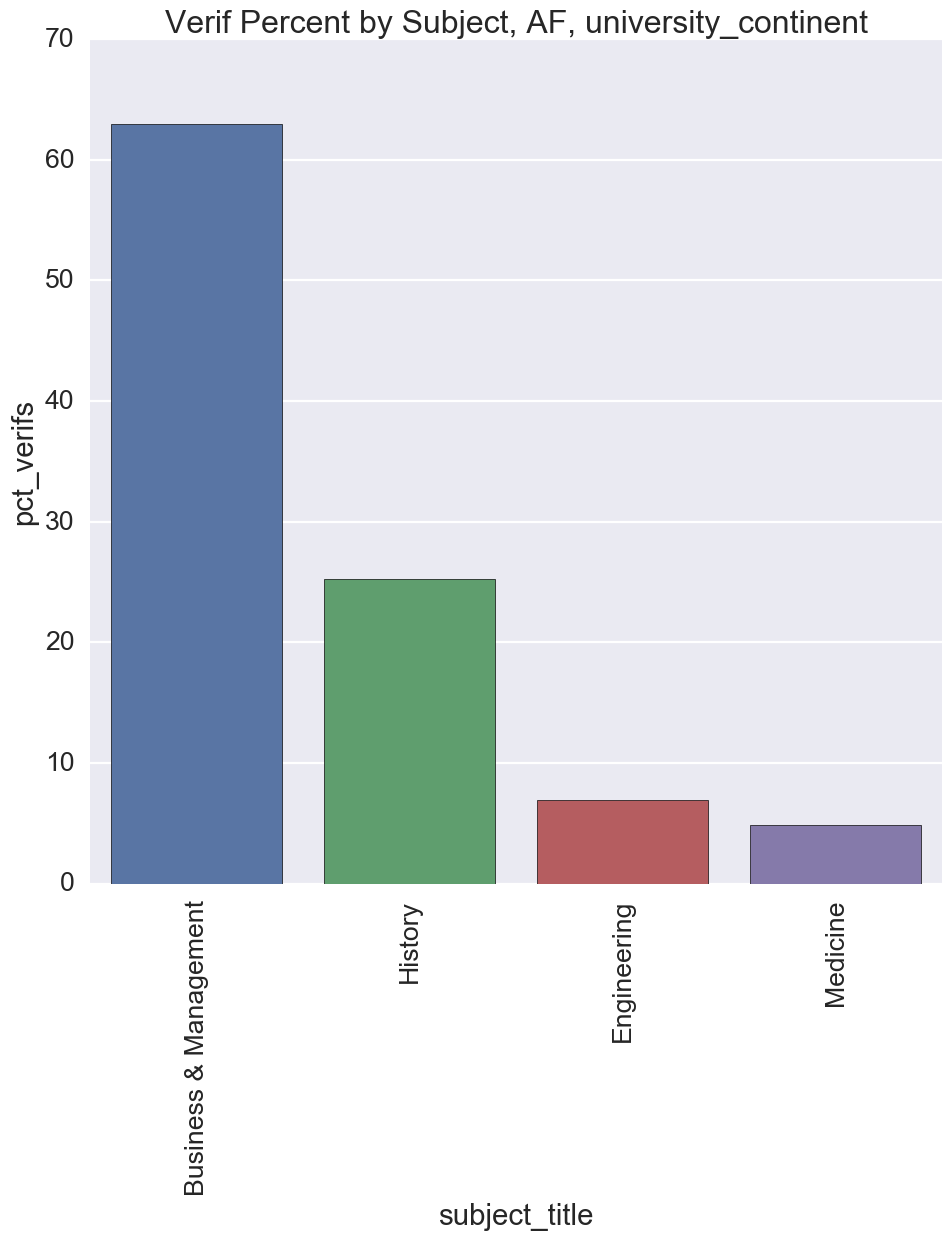

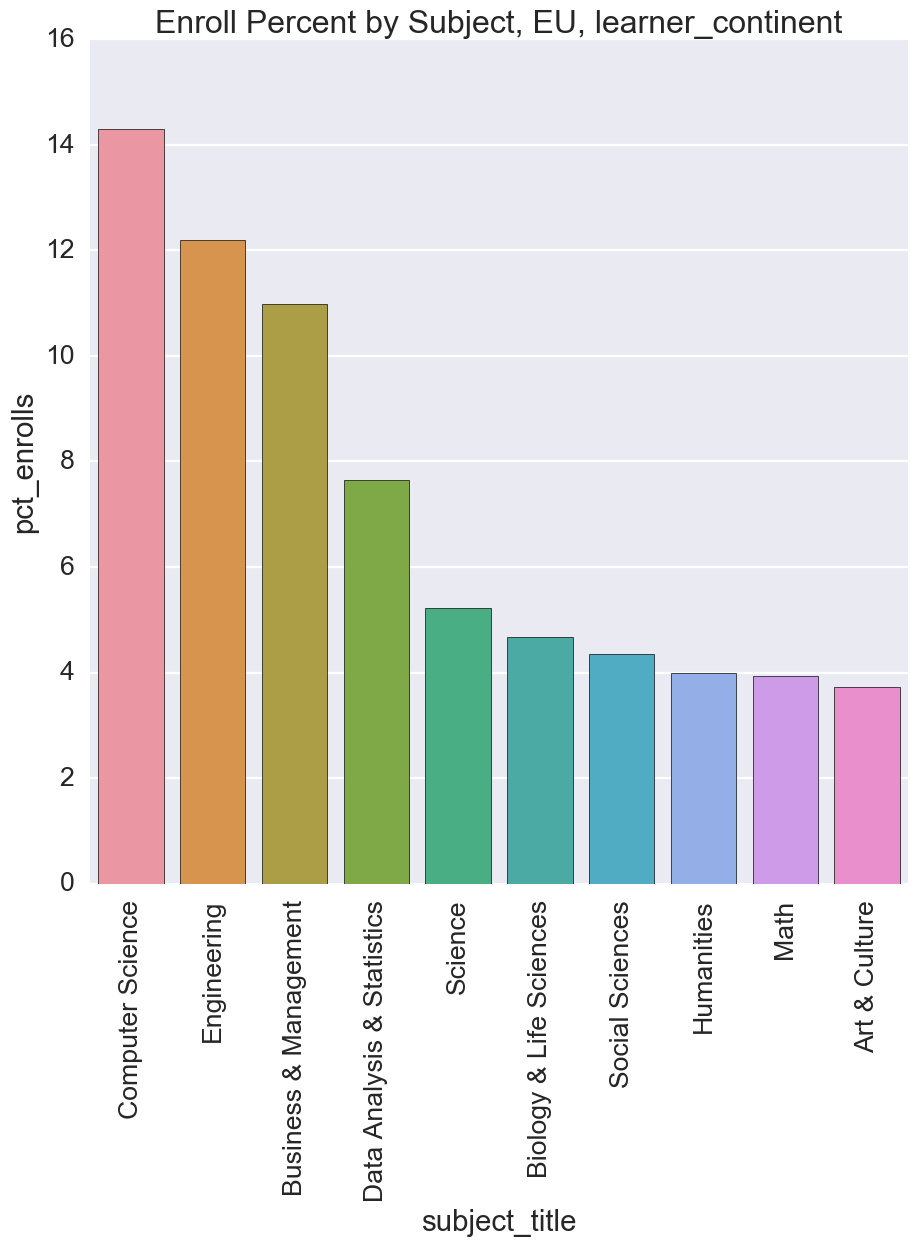

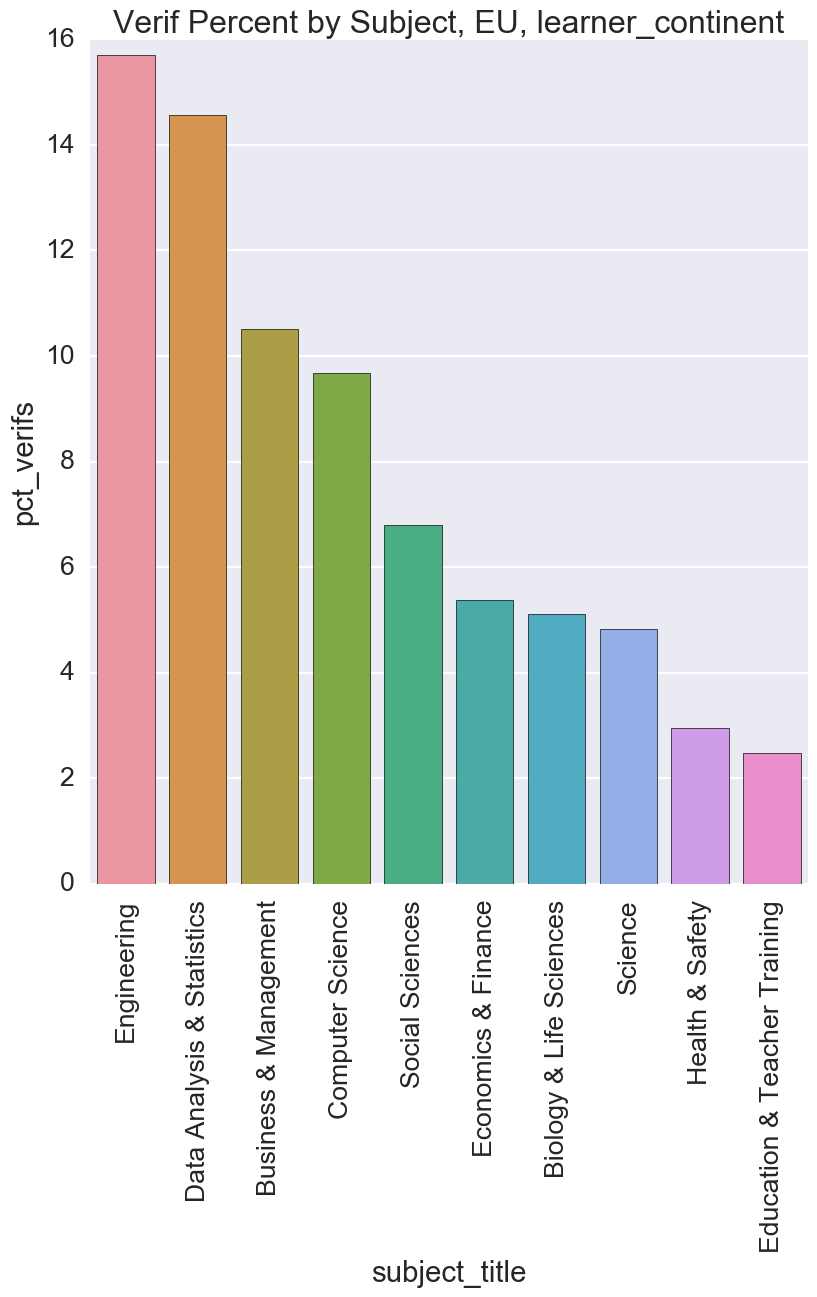

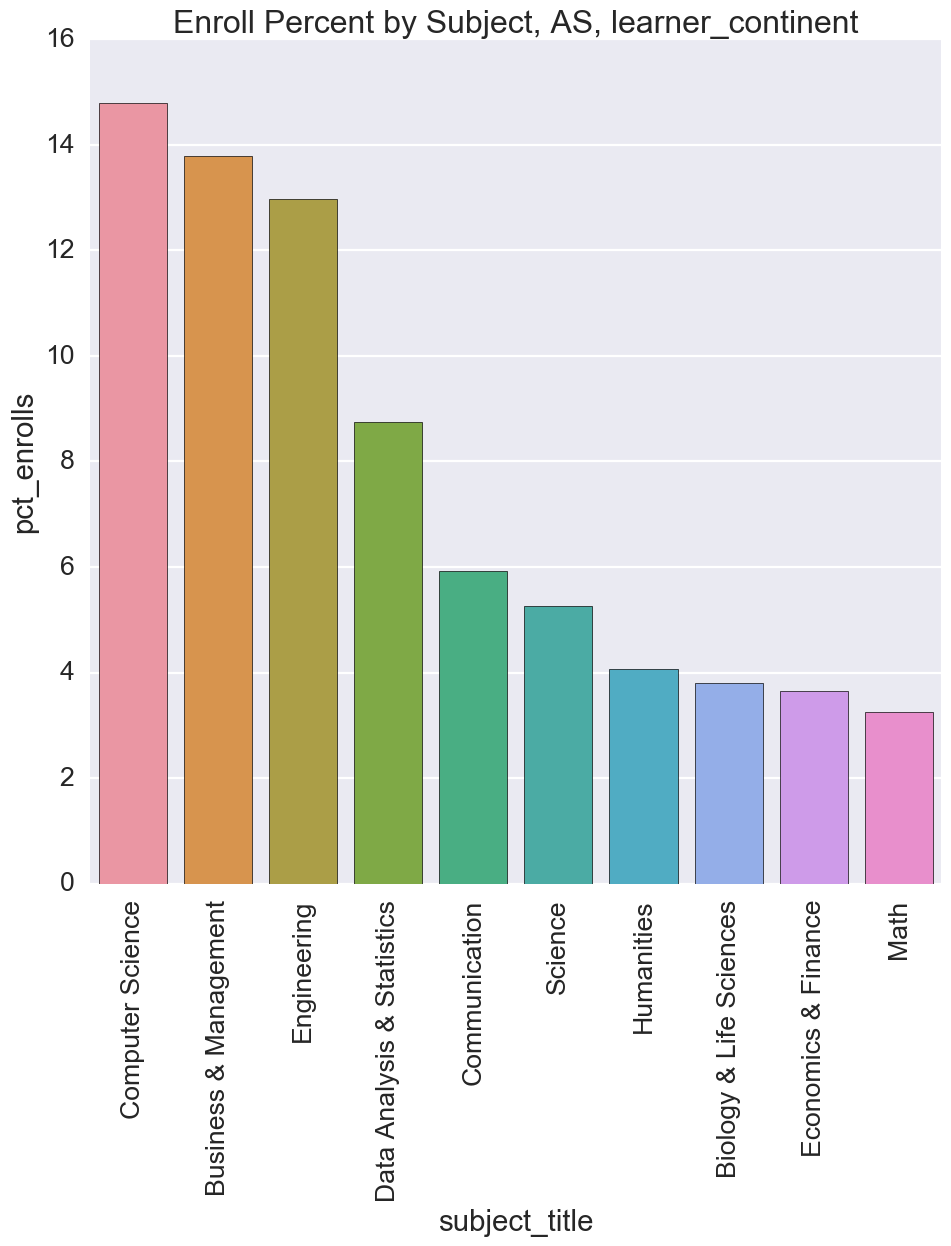

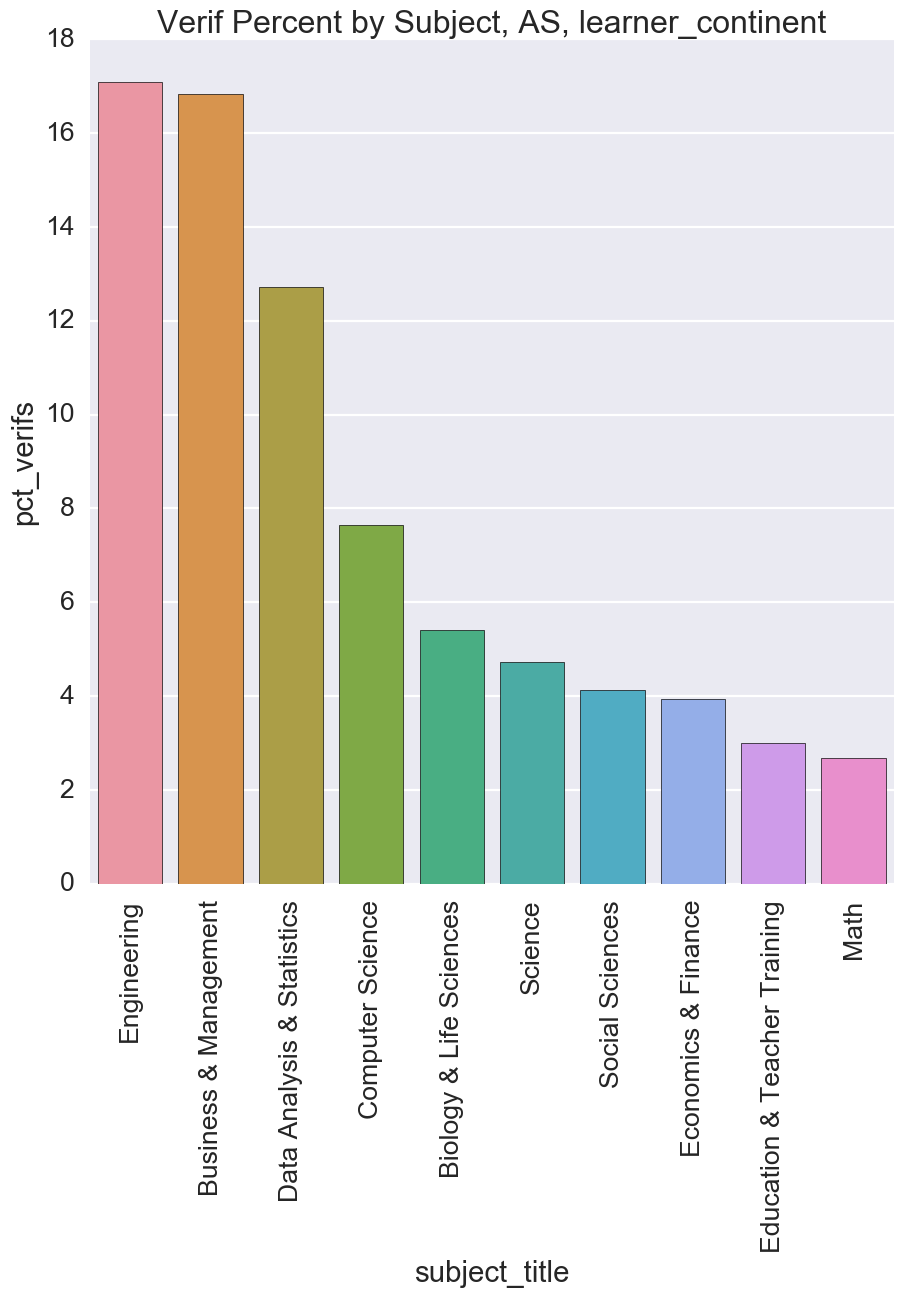

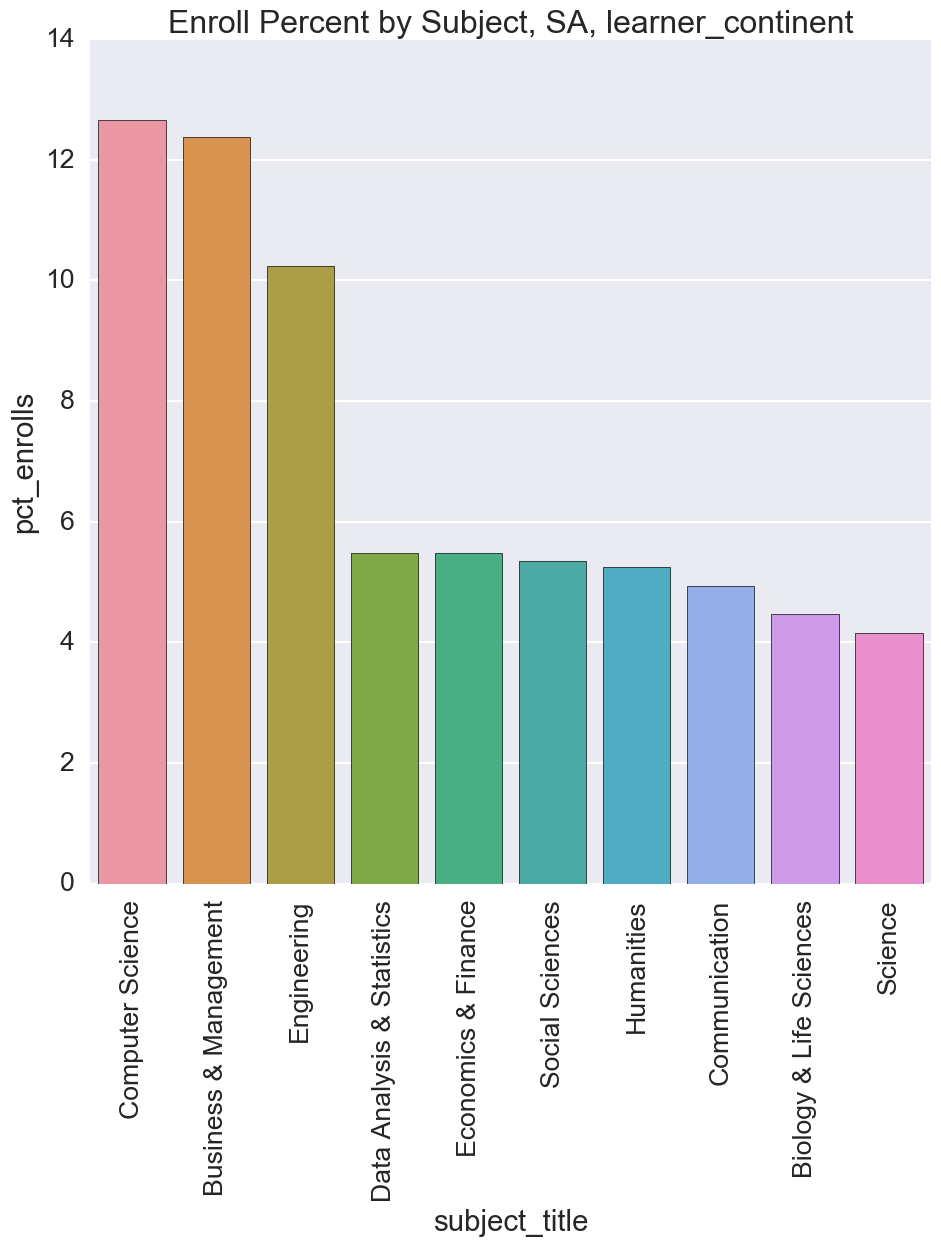

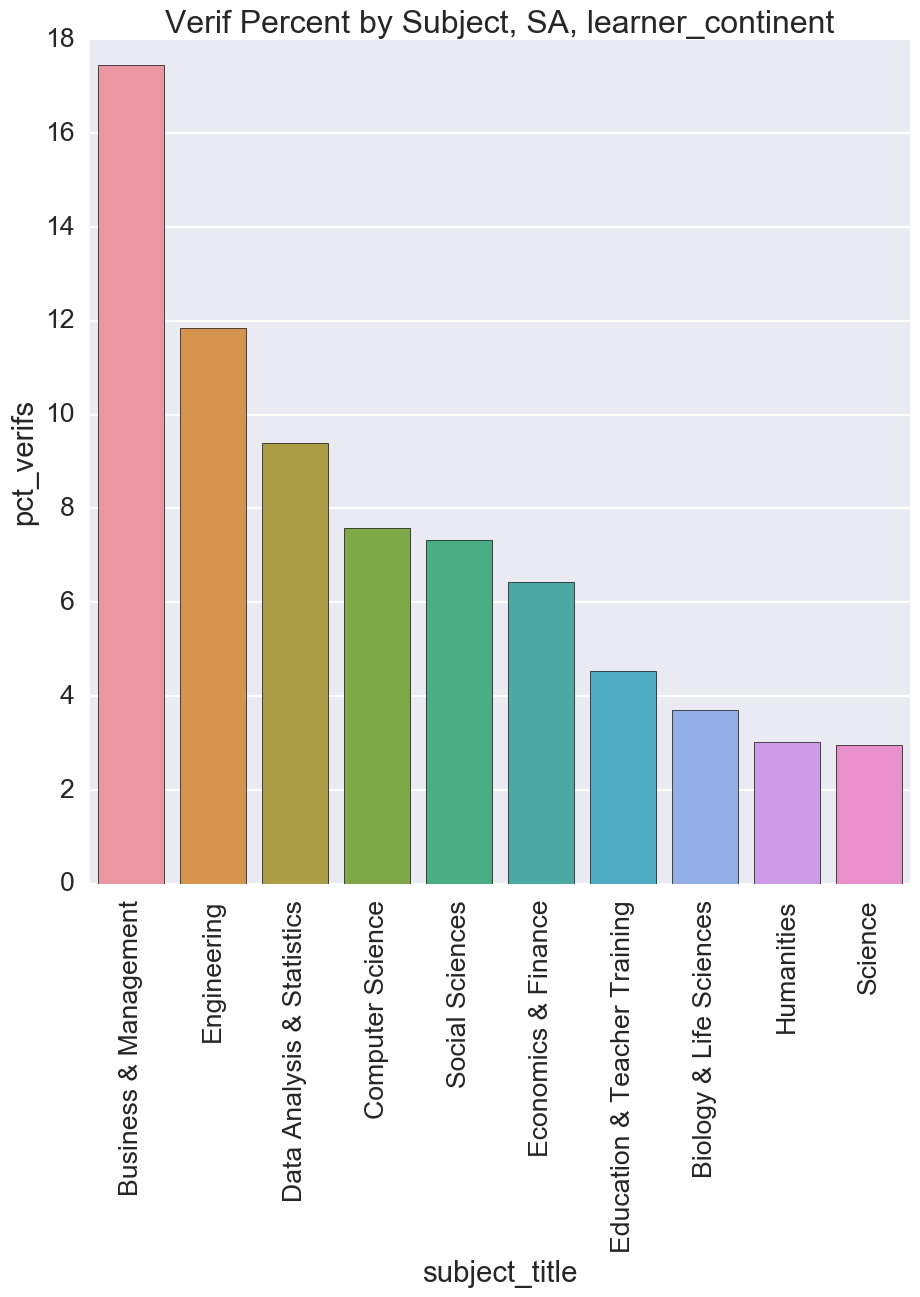

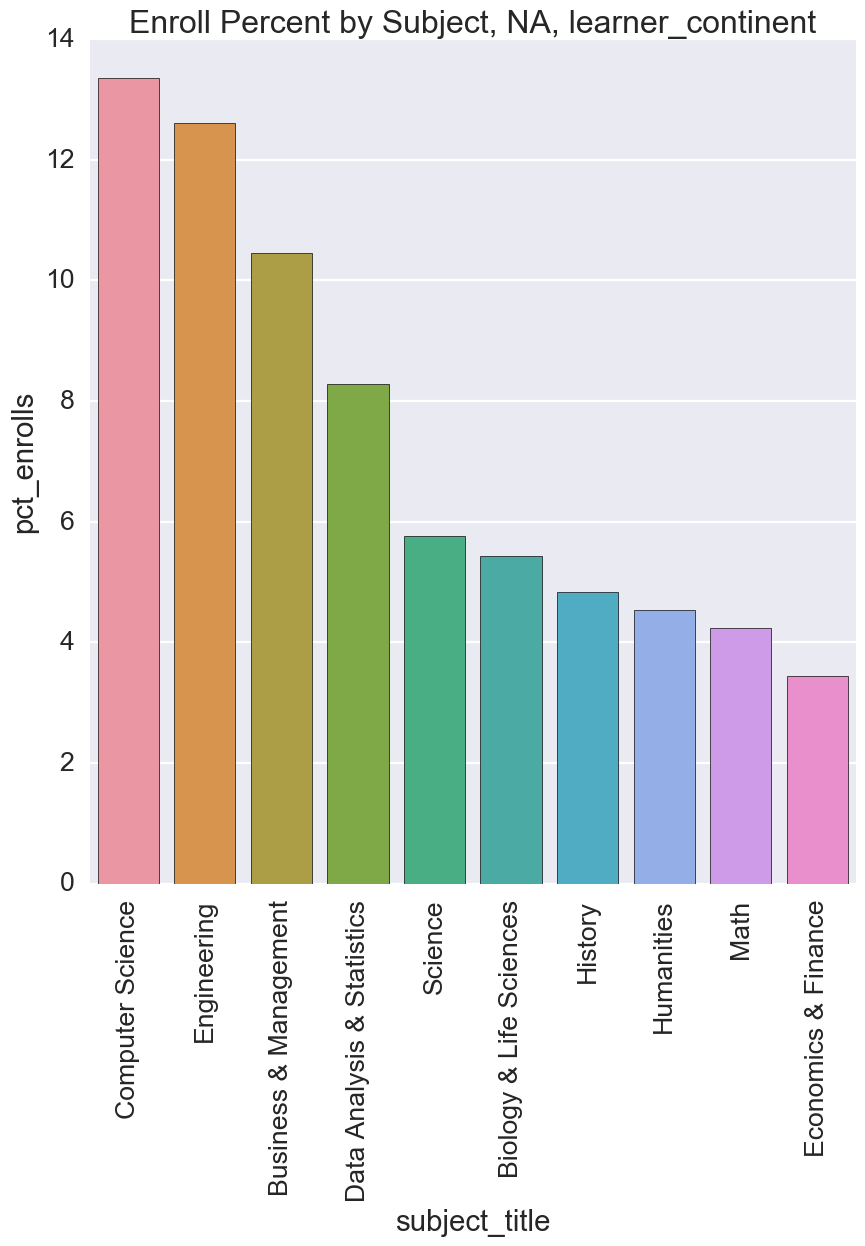

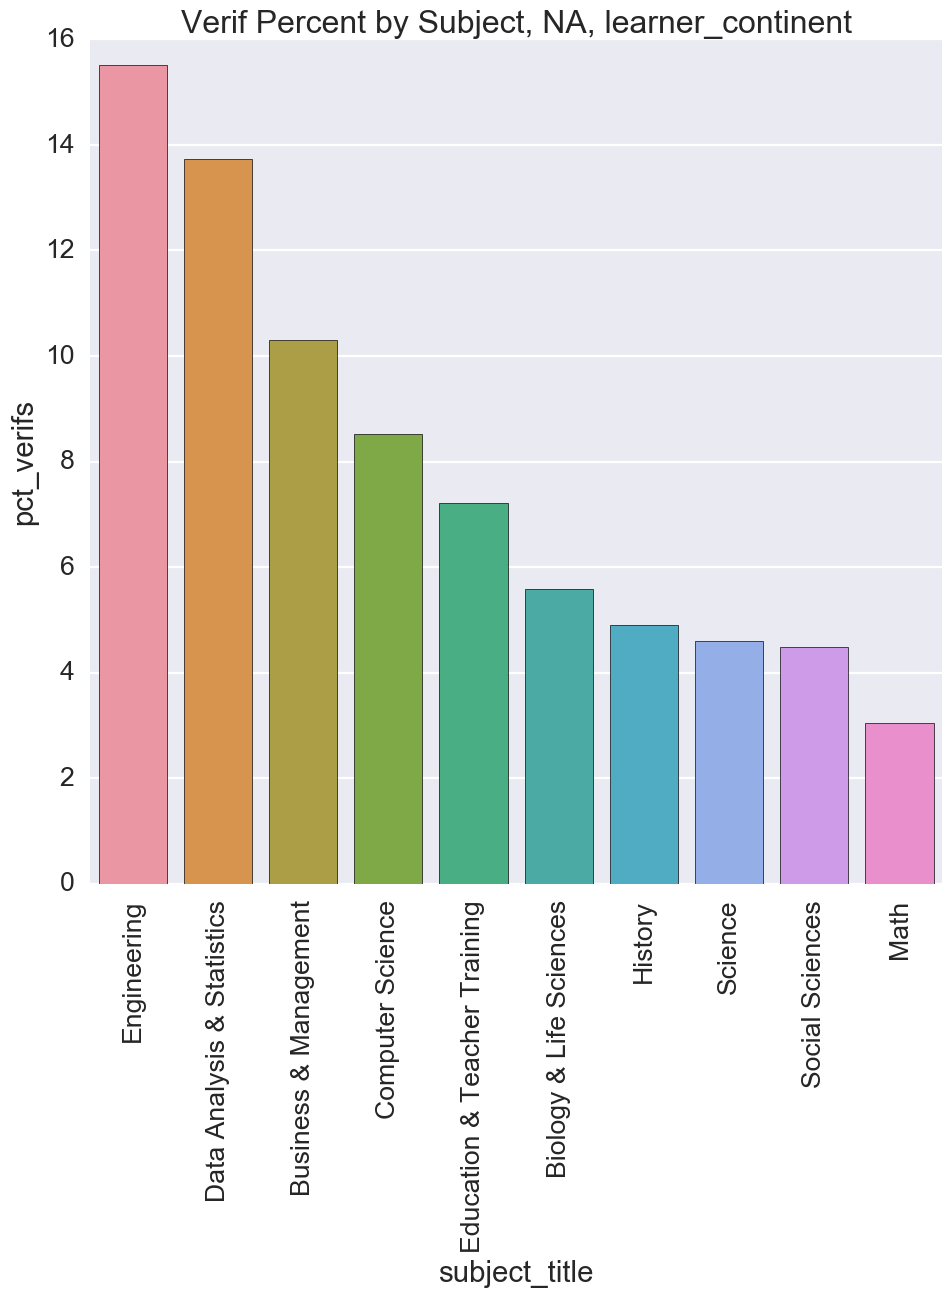

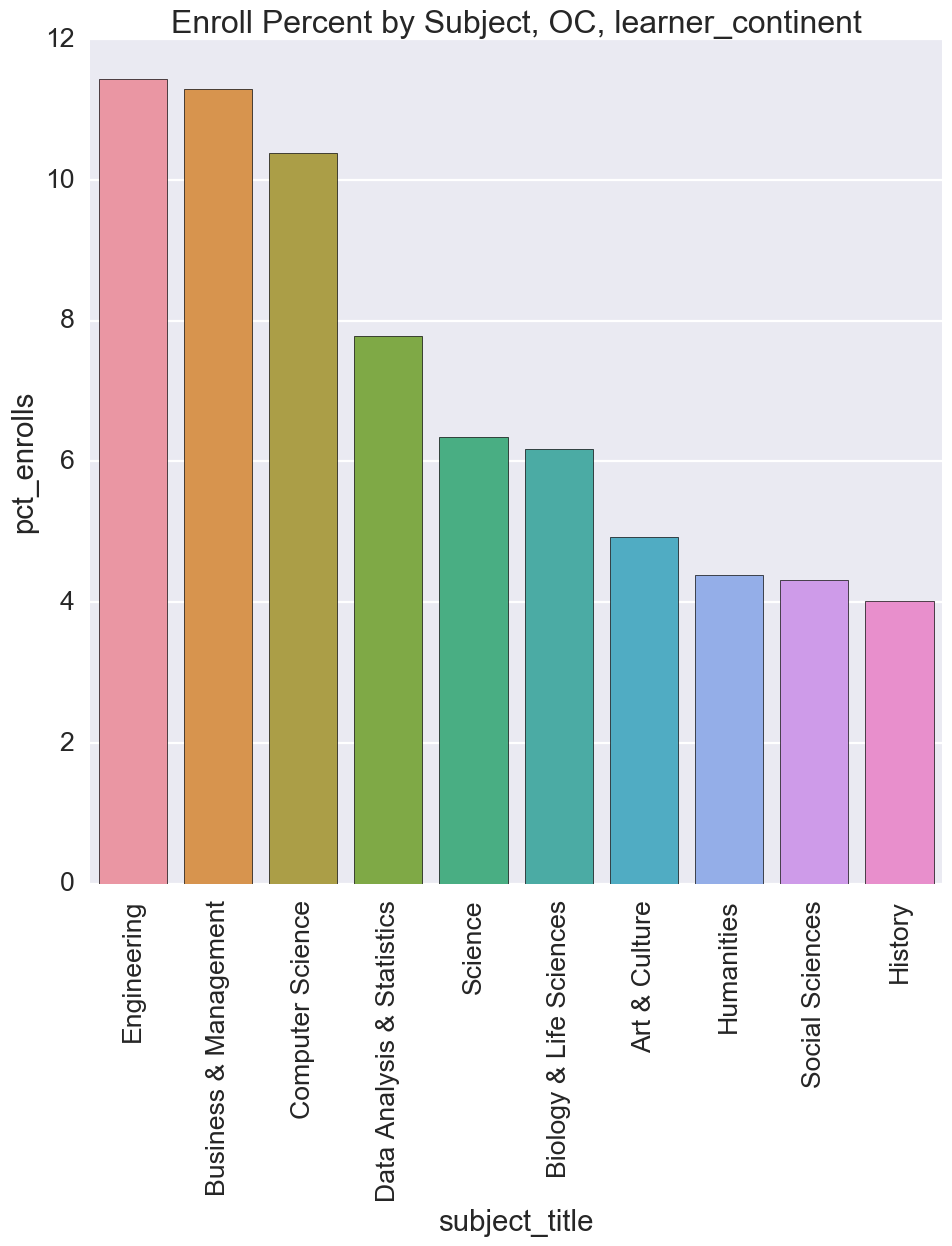

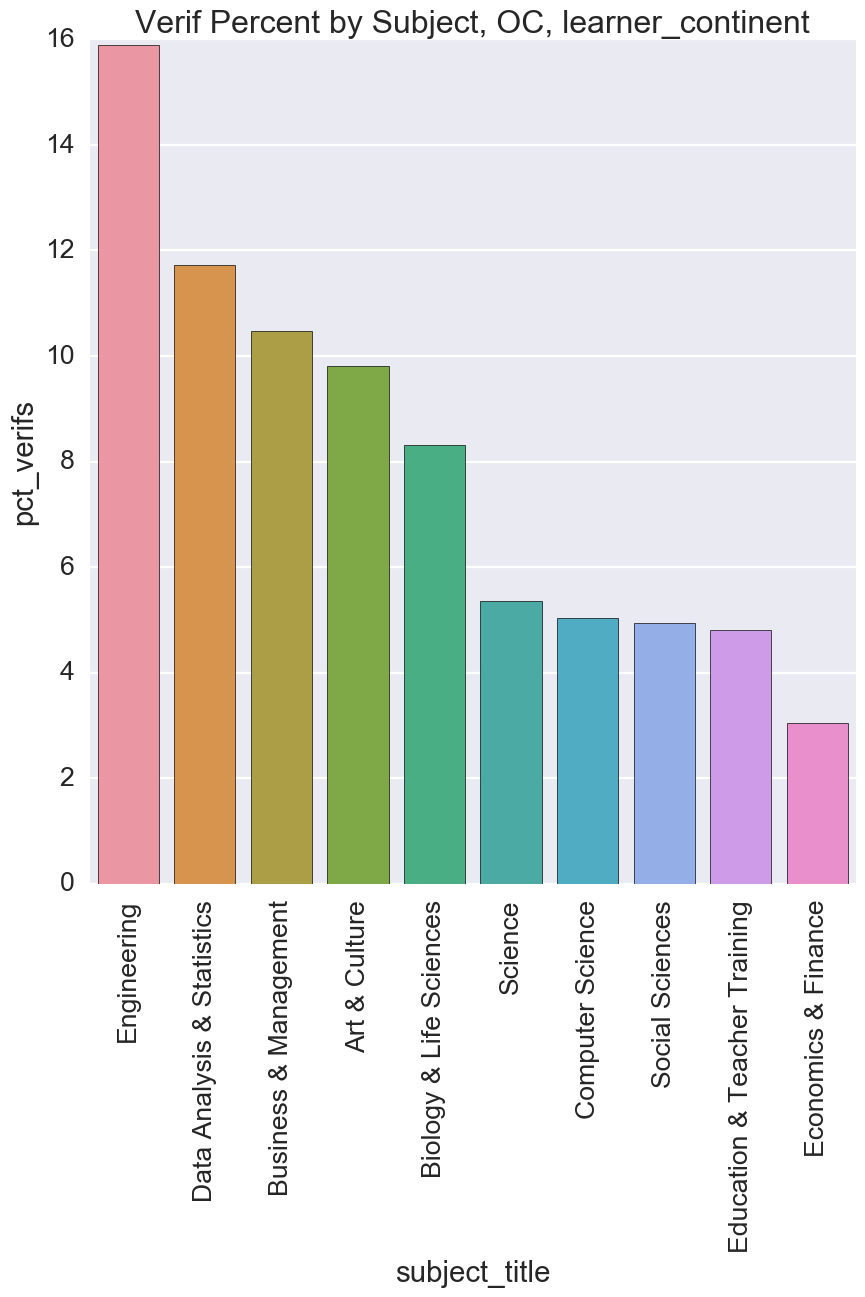

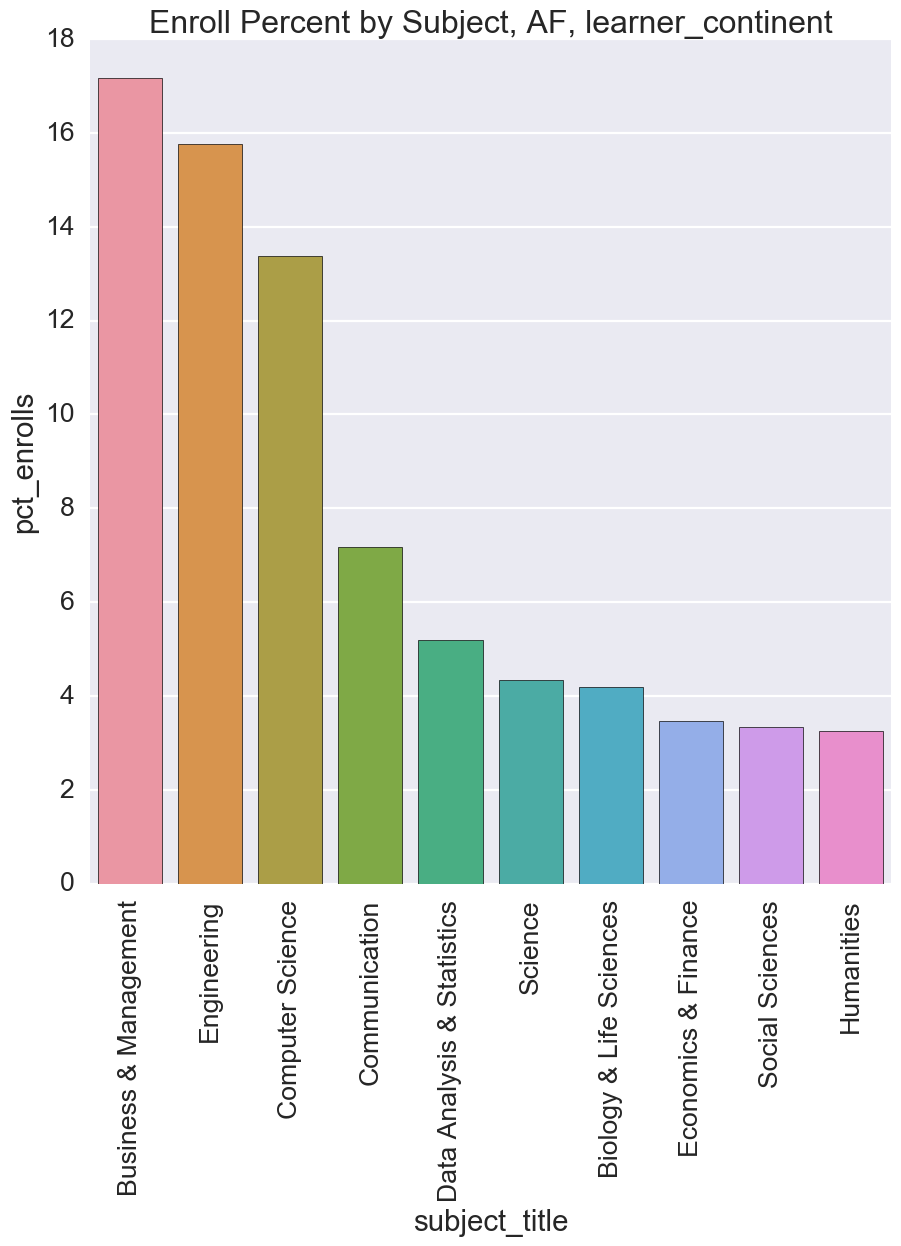

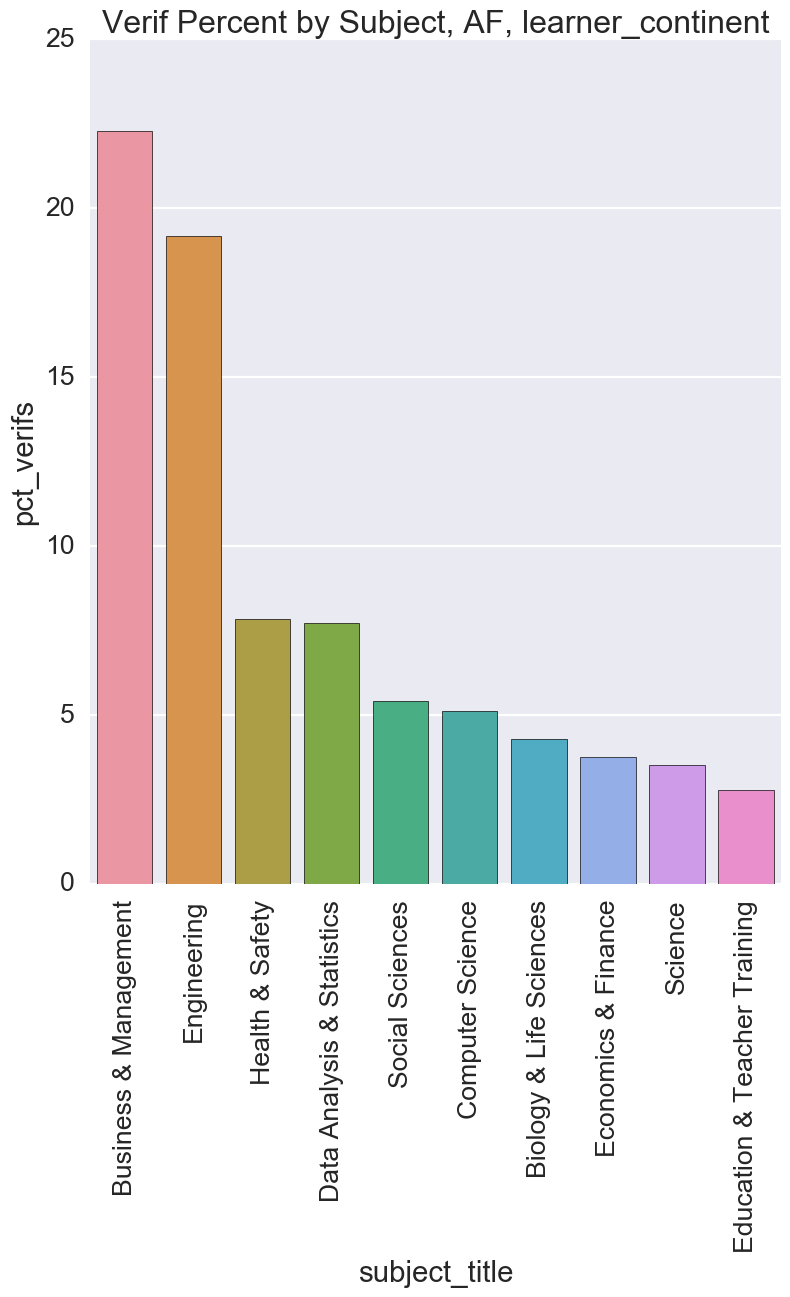

In [465]:
for j in ['university_continent', 'learner_continent']:
    for i in continent_list:
        df = master_df
        df = df[df[j] == i]
        df_agg = df.groupby(['subject_title',j]).sum().reset_index()
        df_agg['pct_enrolls'] = df_agg.cnt_enrolls * 100.0/df.sum()['cnt_enrolls']
        df_agg['pct_verifs'] = df_agg.cnt_verifs * 100.0/df.sum()['cnt_verifs']

        ax = sns.factorplot(data = df_agg.reset_index().sort_values('pct_enrolls', ascending=False).head(10), y = 'pct_enrolls', x = 'subject_title',
                  kind = 'bar', size = 10) 
        ax.set(title='Enroll Percent by Subject, %s, %s' % (i,j))
        ax.set_xticklabels(rotation=90)

        ax = sns.factorplot(data = df_agg.reset_index().sort_values('pct_verifs', ascending=False).head(10), y = 'pct_verifs', x = 'subject_title',
                  kind = 'bar', size = 10) 
        ax.set(title='Verif Percent by Subject, %s, %s' % (i,j))
        ax.set_xticklabels(rotation=90)

## Enrolls and Verifs, Learner Demographics

In [329]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [415]:
def make_plot_age(comparison, num_bars = 100):
    
    temp_enroll_df = pd.DataFrame()
    temp_verif_df = pd.DataFrame()
    master_age_df = pd.DataFrame()

    temp_enroll_df['mean_age'] = age_df.groupby(comparison).apply(wavg, "learner_age", "cnt_enrolls")
    temp_enroll_df['type'] = 'enrollment'

    temp_verif_df['mean_age'] = age_df.groupby(comparison).apply(wavg, "learner_age", "cnt_verifs")
    temp_verif_df['type'] = 'verification'

    master_age_df = temp_enroll_df.append(temp_verif_df).reset_index()

    filter_list = age_df.groupby(comparison).sum().reset_index().sort_values('cnt_enrolls', ascending = False).head(num_bars)[comparison]
    
    ax = sns.factorplot(data=master_age_df[master_age_df[comparison].isin(filter_list)], x=comparison, y='mean_age', kind='point',hue='type', size=10)
    ax.set(title = 'Mean Age across %s' % comparison,
          xlabel = comparison,
          ylabel = 'Mean Age') 


In [416]:
def make_plots_demographics(df, dimension, filter_list, comparison, num_bars = 100):
    
    df_agg_temp = df.groupby([comparison, dimension]).sum().reset_index()
    df_agg = df_agg_temp.merge(df.groupby([comparison]).sum().reset_index(), 
                                      on =comparison, suffixes = ('_individual', '_aggregate'))
    df_agg['pct_enrolls'] = df_agg['cnt_enrolls_individual'] * 100.0/df_agg['cnt_enrolls_aggregate']
    df_agg['pct_verifs'] = df_agg['cnt_verifs_individual'] * 100.0/df_agg['cnt_verifs_aggregate']
    
    num_filter_list = df.groupby([comparison]).sum().reset_index().sort_values('cnt_enrolls', ascending=False).head(num_bars)[comparison]
    
    df_agg = df_agg[df_agg[dimension].isin(filter_list)]
    
    ax = sns.factorplot(data = df_agg[df_agg[comparison].isin(num_filter_list)], 
                       x = comparison, y = 'pct_enrolls', 
                       hue = dimension, kind = 'point', size = 10)
    ax.set(title = 'Pct of Enrolls, split by %s, across %s' % (dimension, comparison), 
          xlabel = comparison,
          ylabel = 'Pct of Enrolls (%)')

    ax = sns.factorplot(data = df_agg[df_agg[comparison].isin(num_filter_list)], 
                       x = comparison, y = 'pct_verifs', 
                       hue = dimension, kind = 'point', size = 10)
    ax.set(title = 'Pct of Verifications, split by %s, across %s' % (dimension, comparison),
          xlabel = comparison,
          ylabel = 'Pct of Verifs (%)')

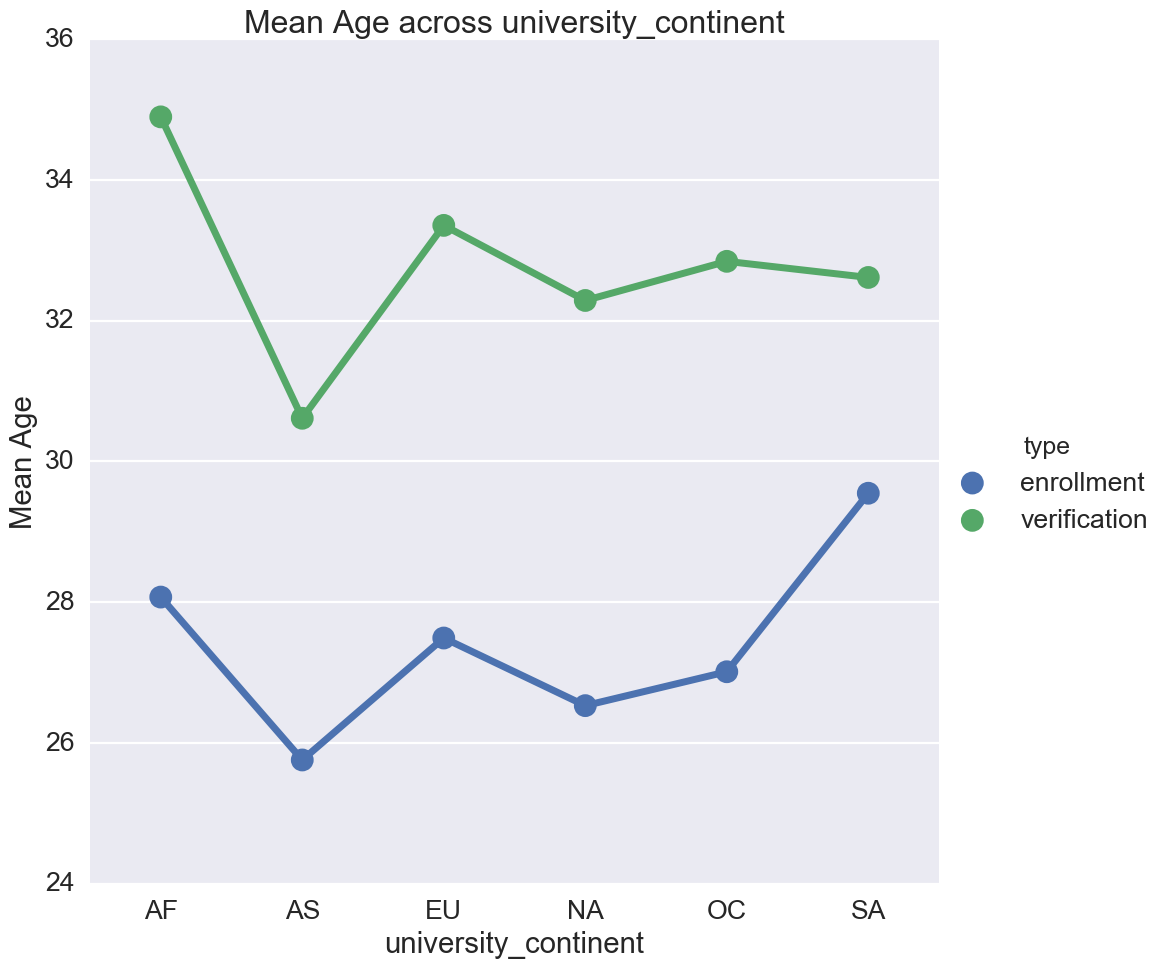

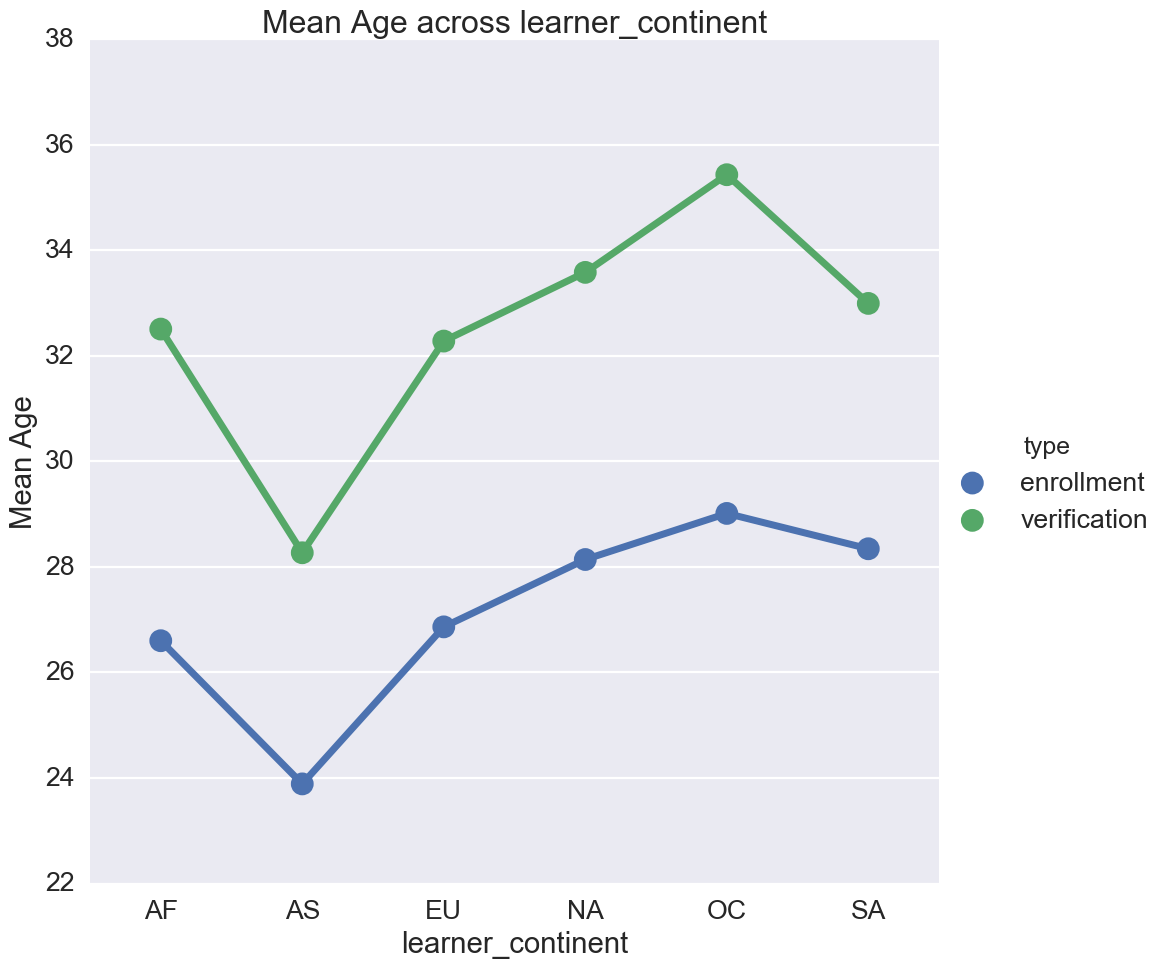

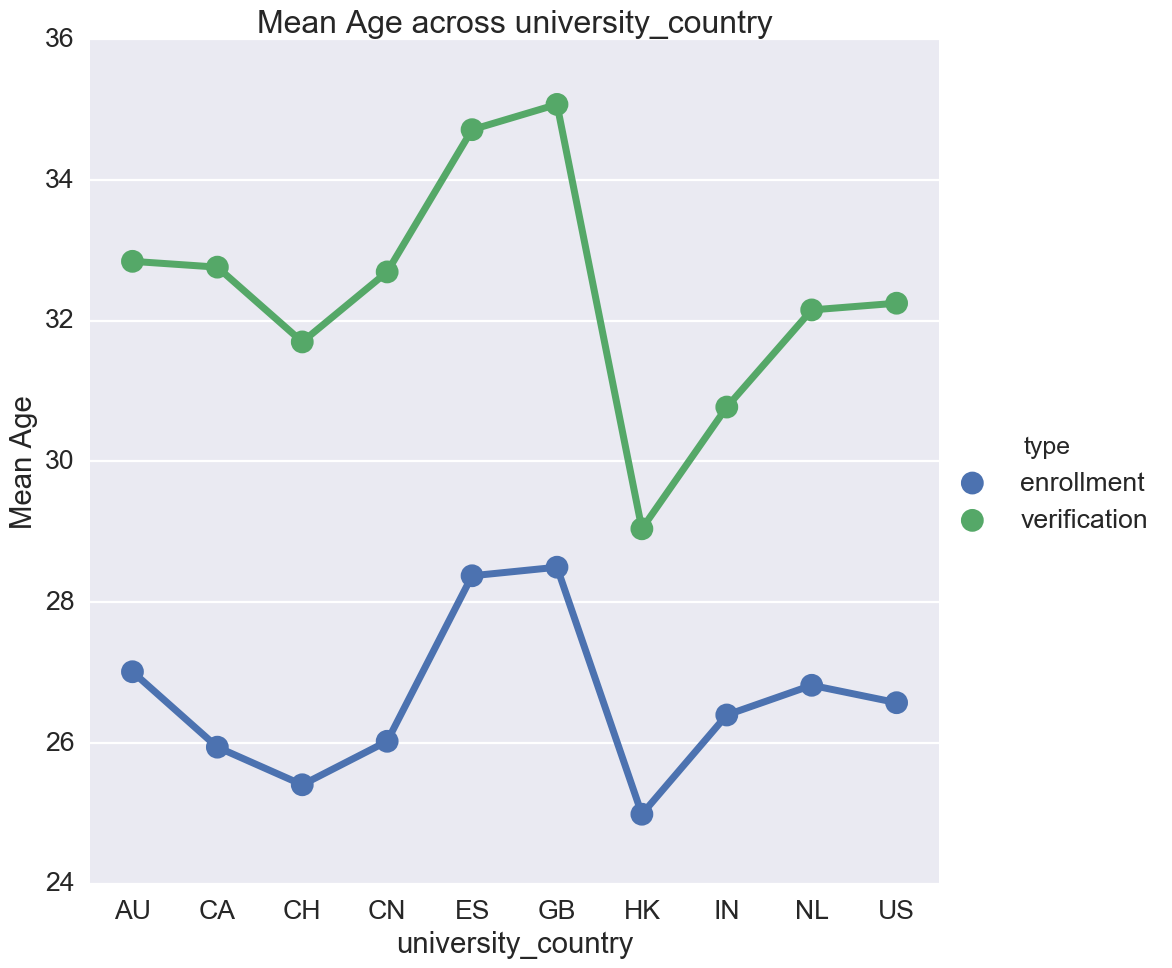

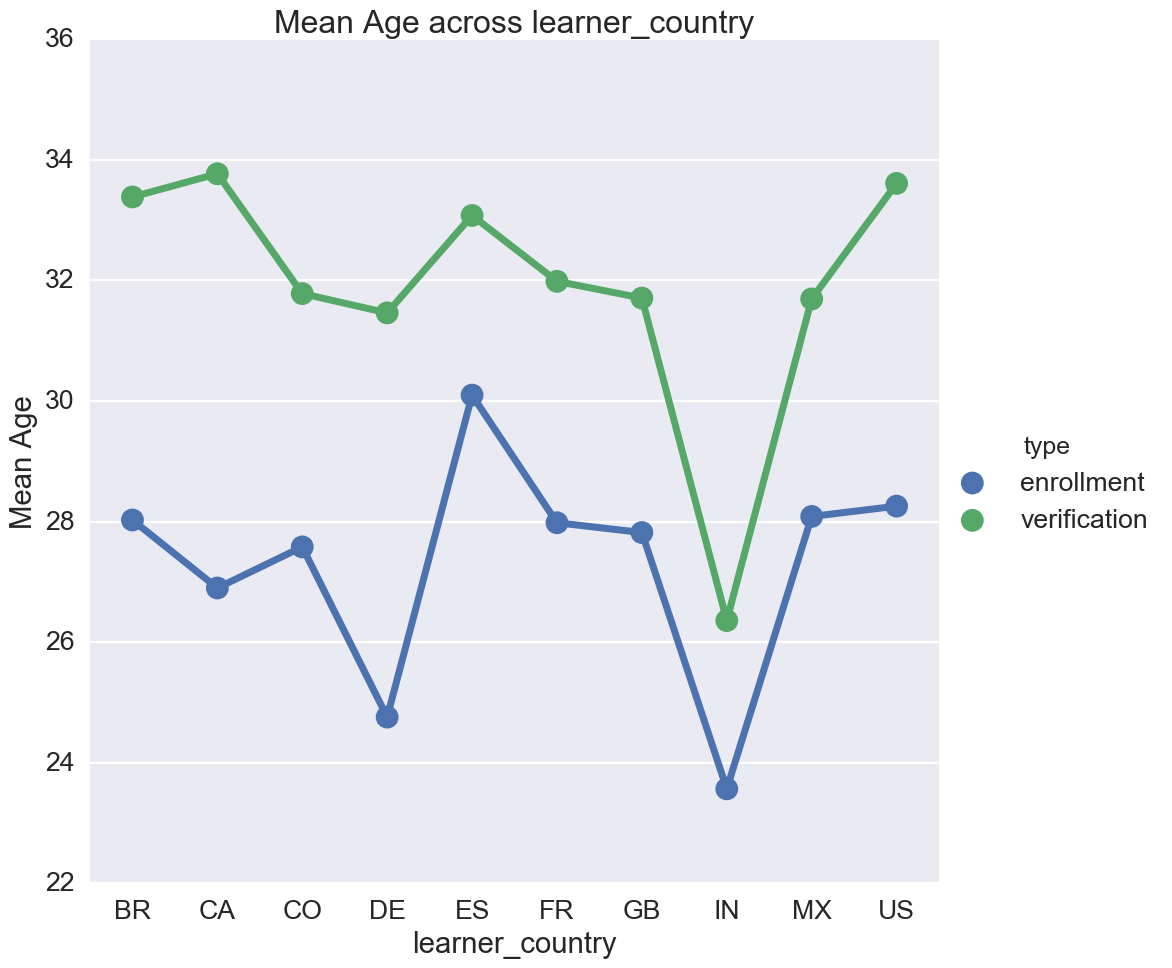

In [384]:
make_plot_age('university_continent')
make_plot_age('learner_continent')
make_plot_age('university_country', 10)
make_plot_age('learner_country', 10)

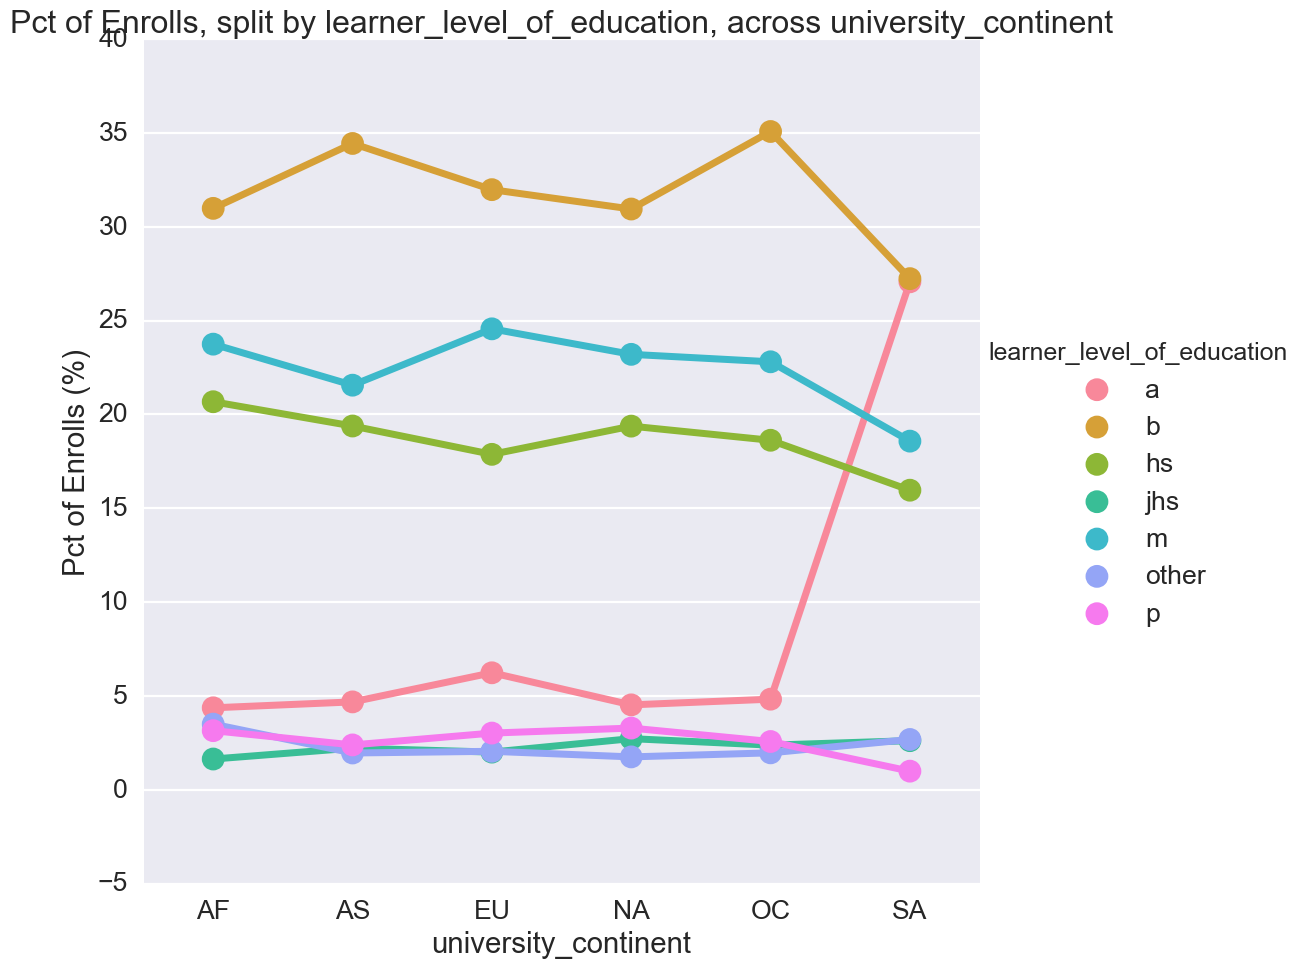

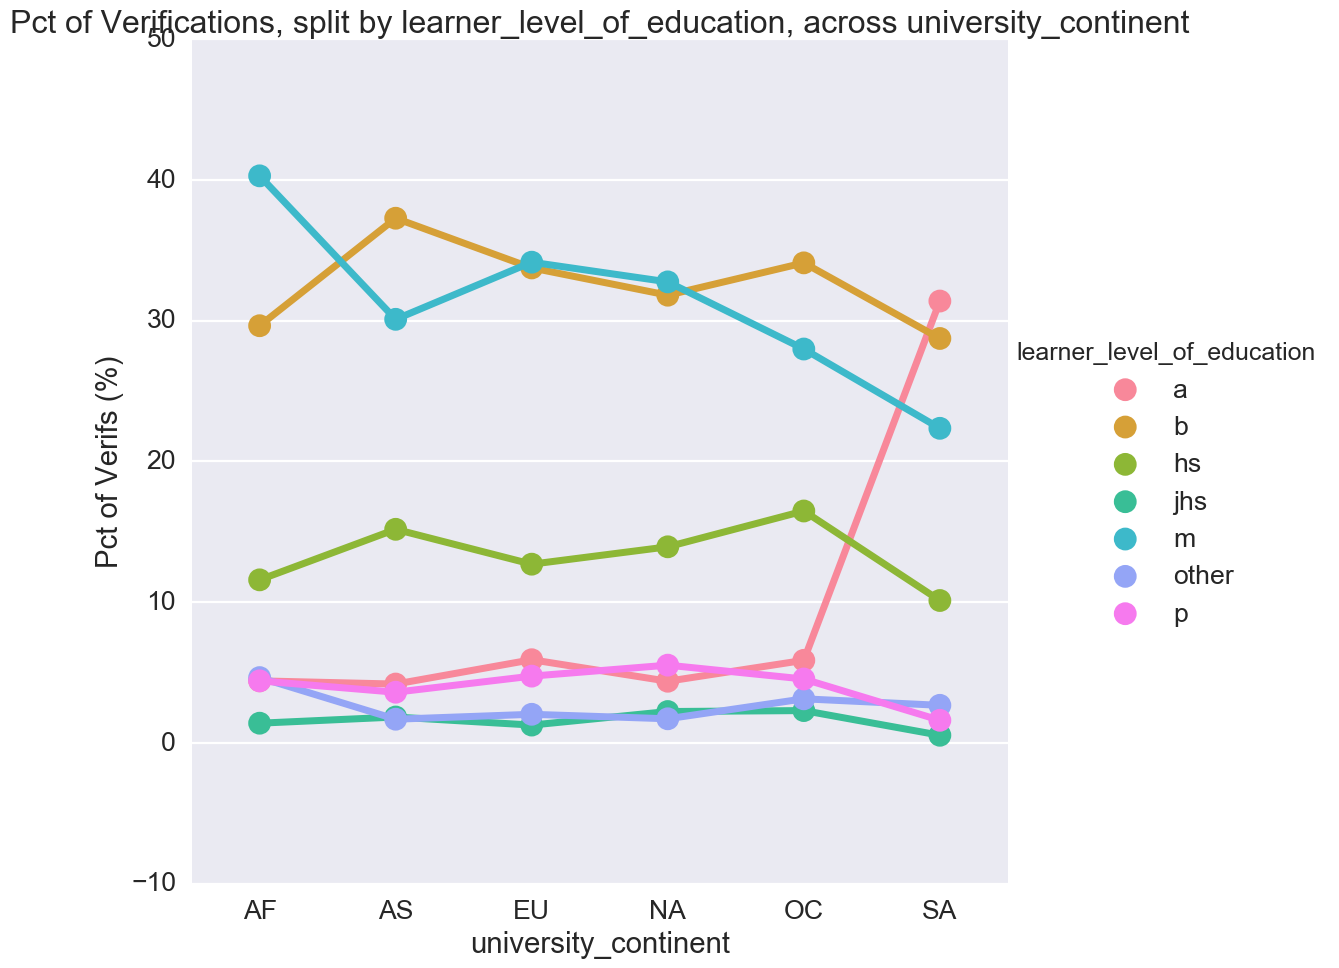

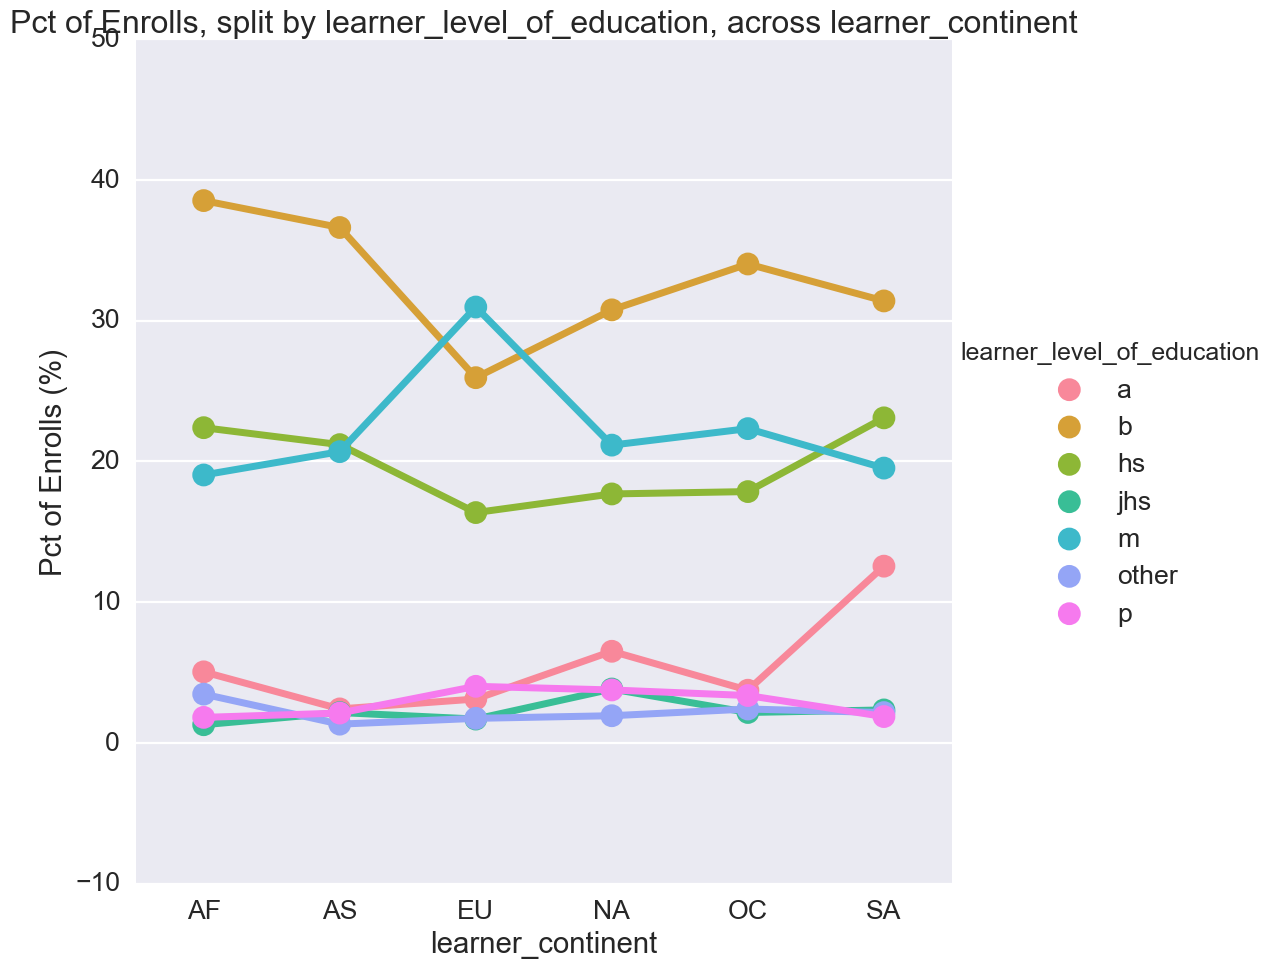

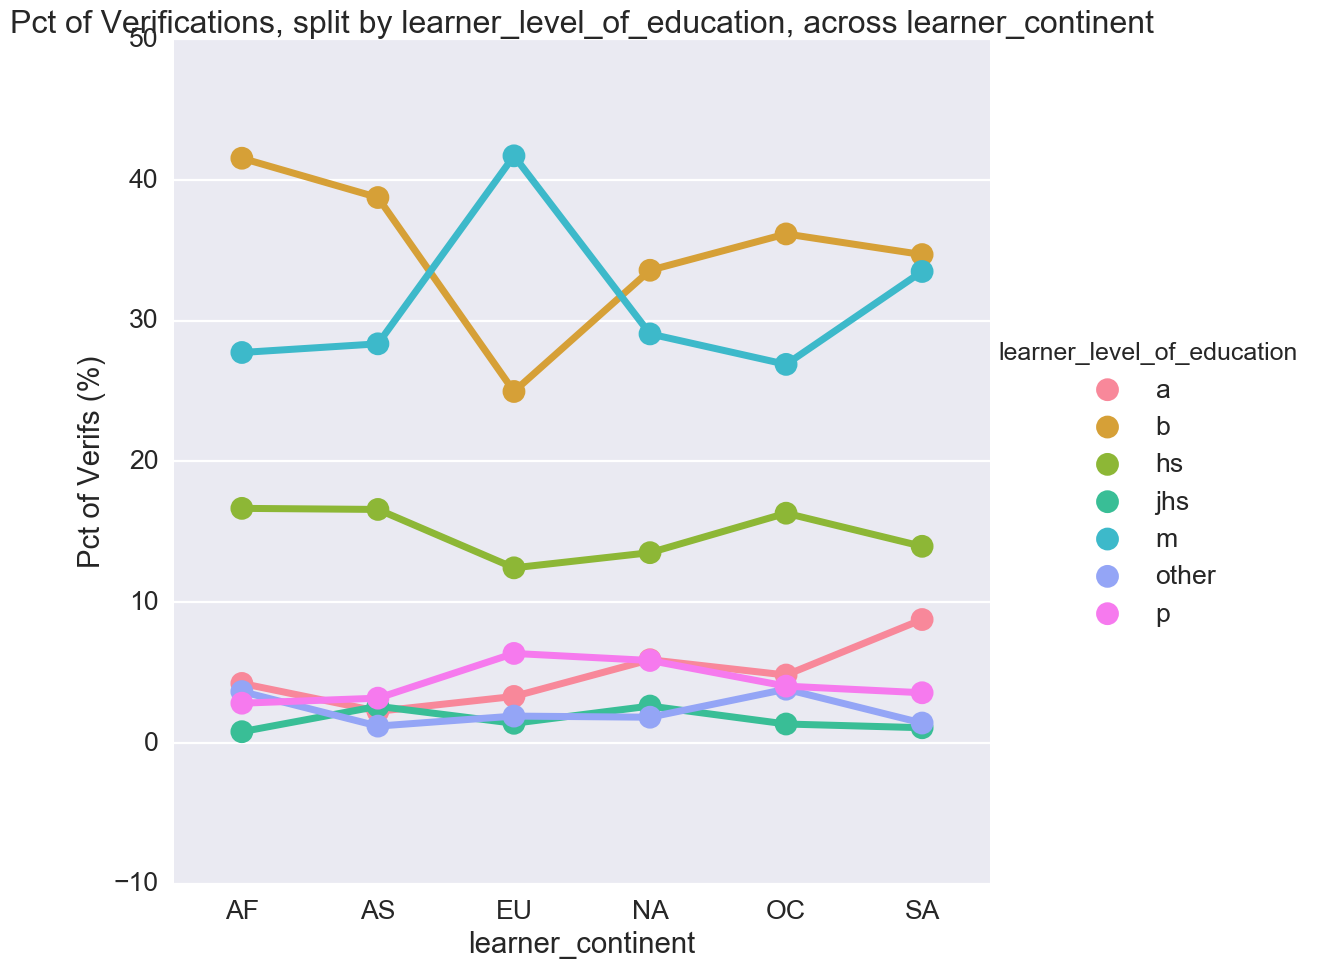

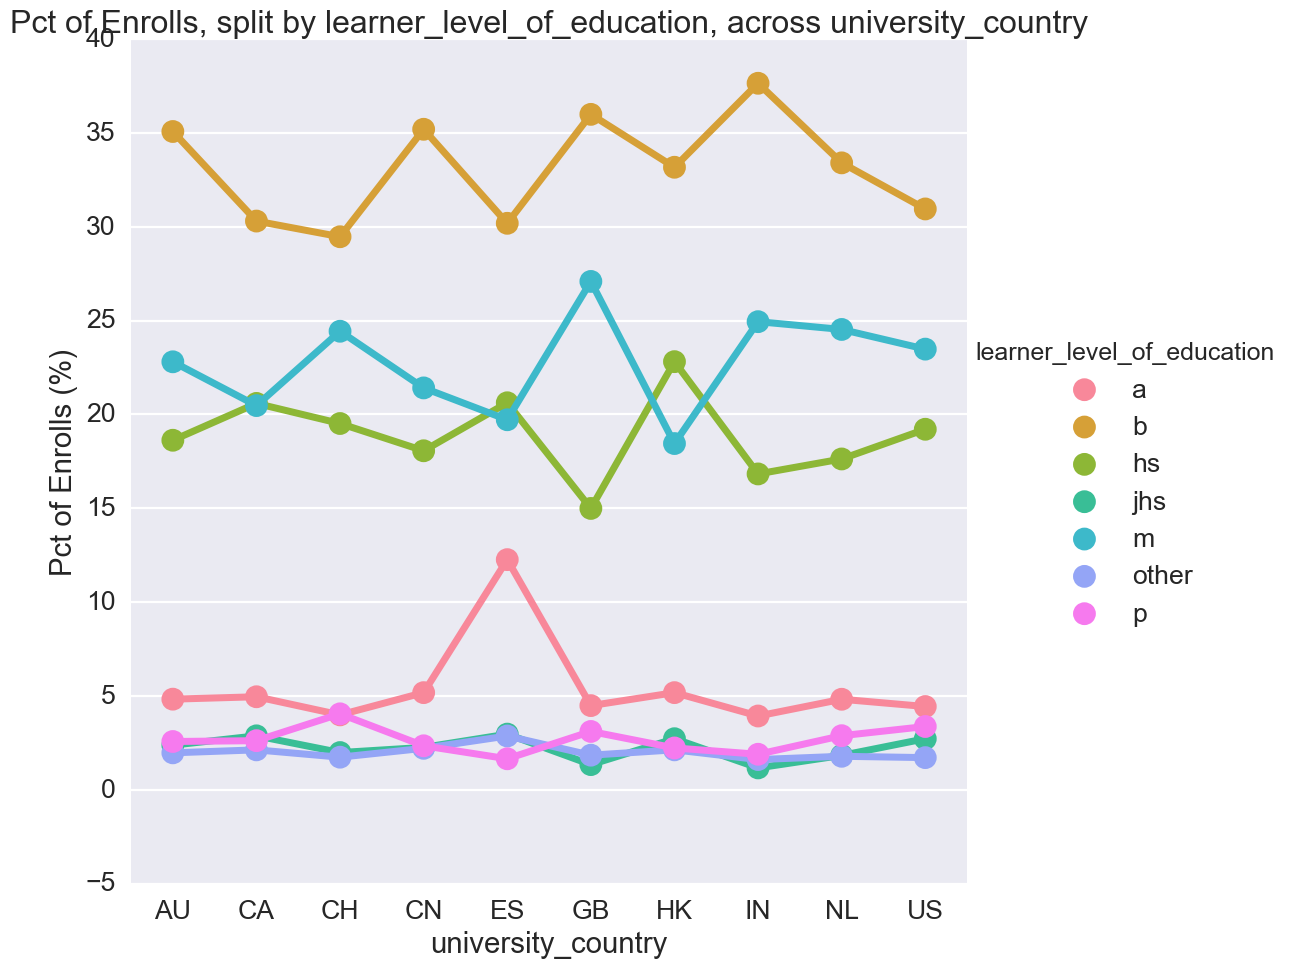

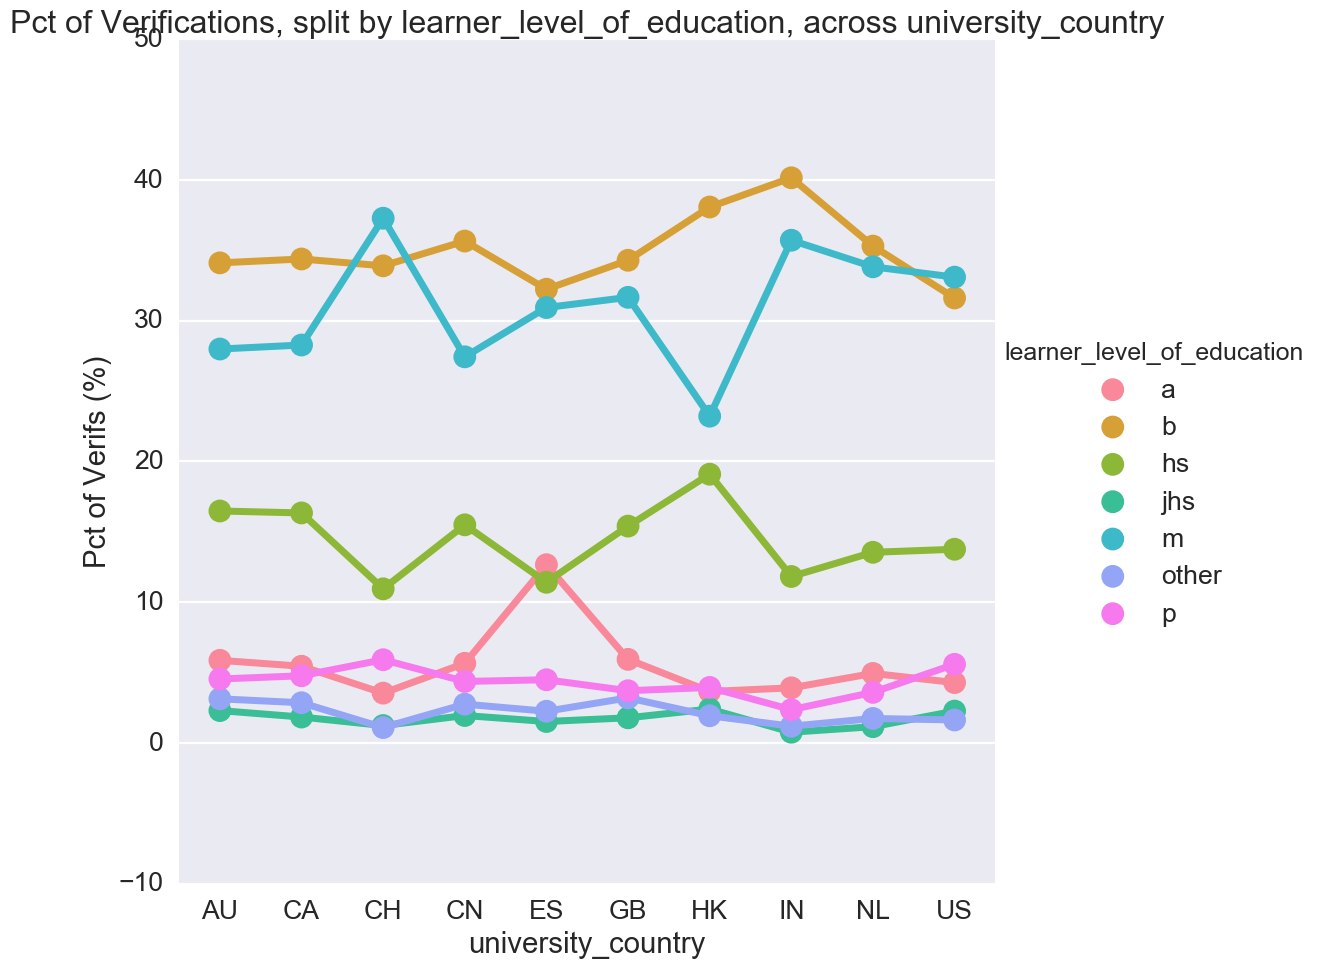

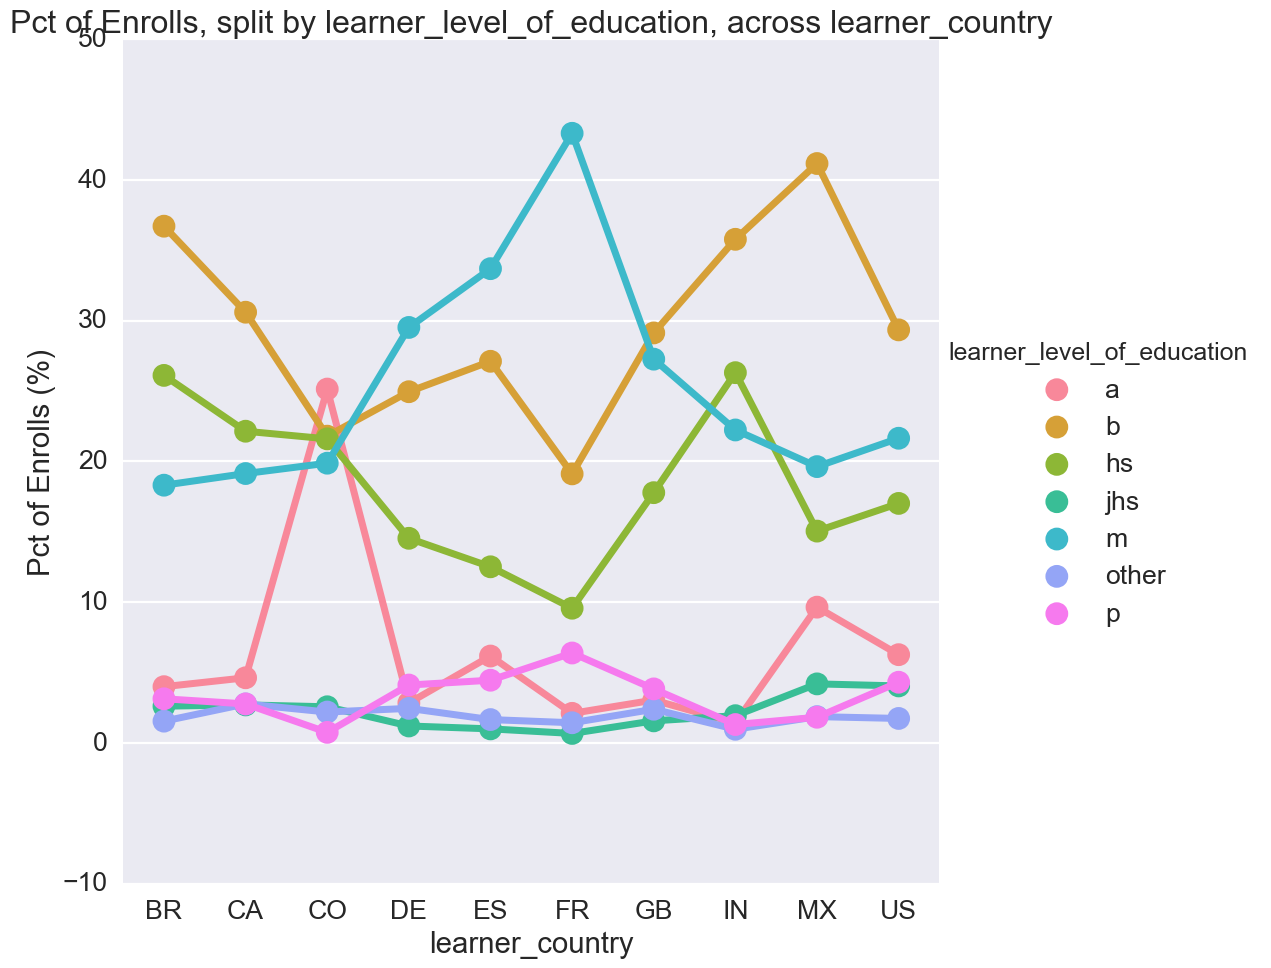

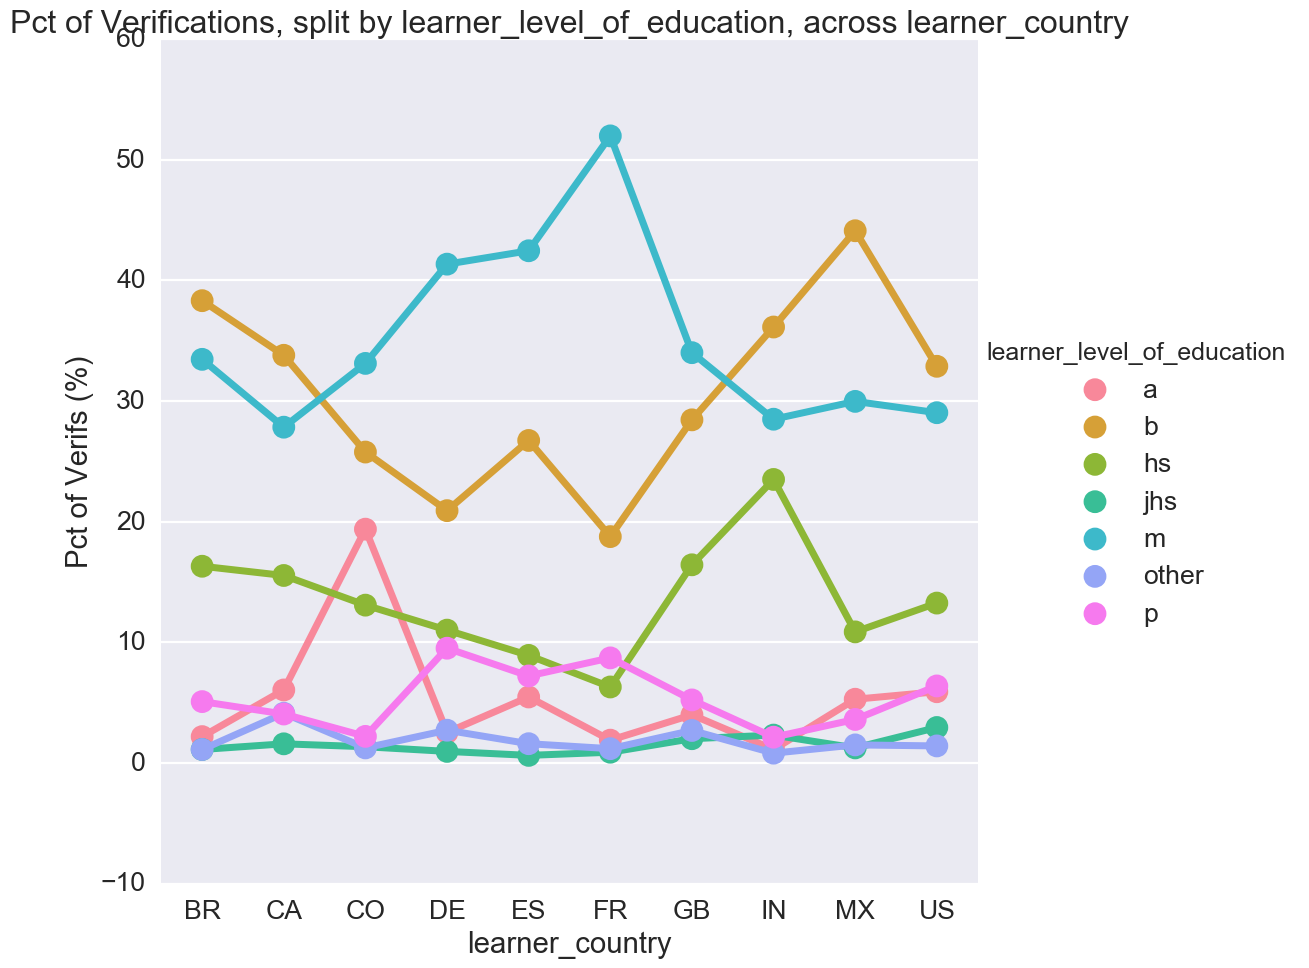

In [398]:
education_list = [
    'a',
    'b',
    'hs',
    'jhs',
    'm',
    'p',
    'other'
    
]
make_plots_demographics(education_df, 'learner_level_of_education', education_list, 'university_continent')
make_plots_demographics(education_df, 'learner_level_of_education', education_list, 'learner_continent')
make_plots_demographics(education_df, 'learner_level_of_education', education_list, 'university_country', 10)
make_plots_demographics(education_df, 'learner_level_of_education', education_list, 'learner_country', 10)


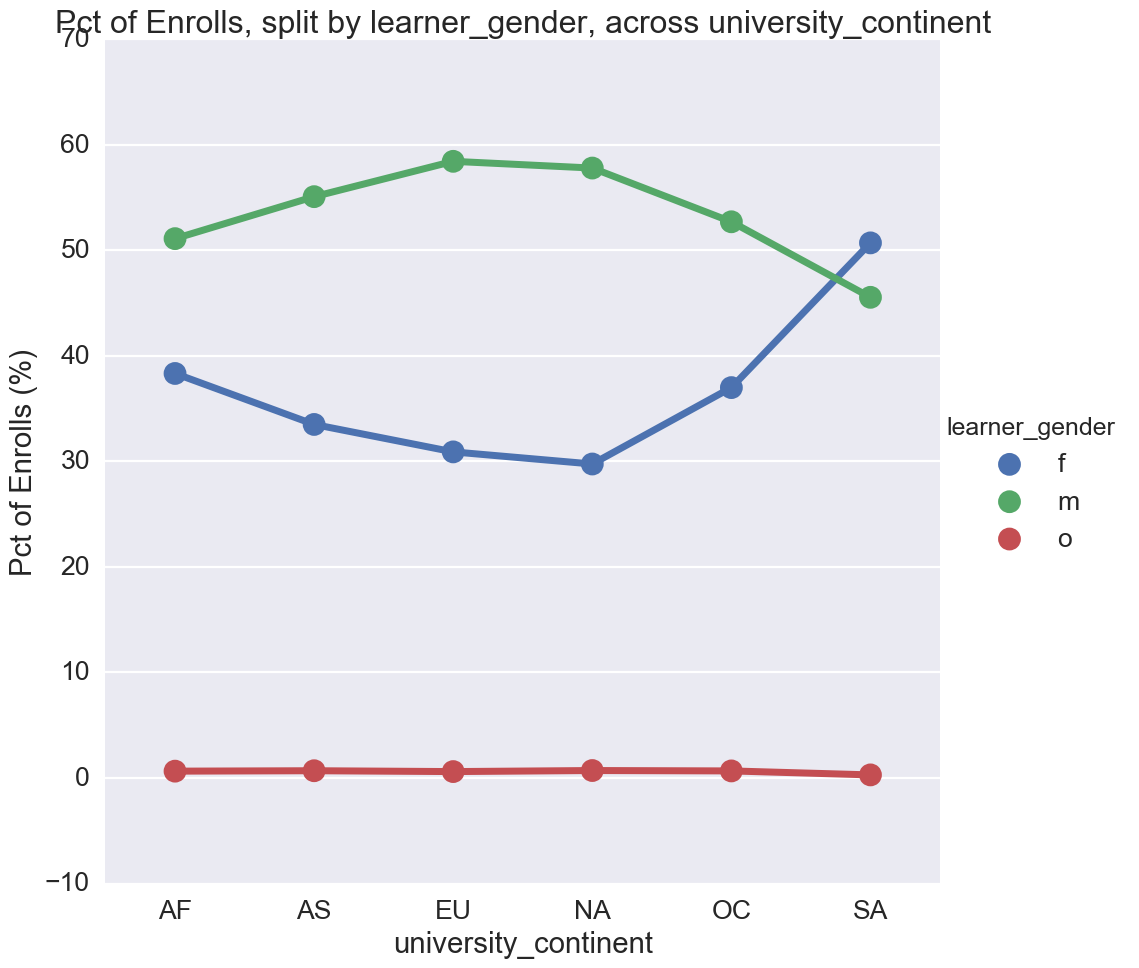

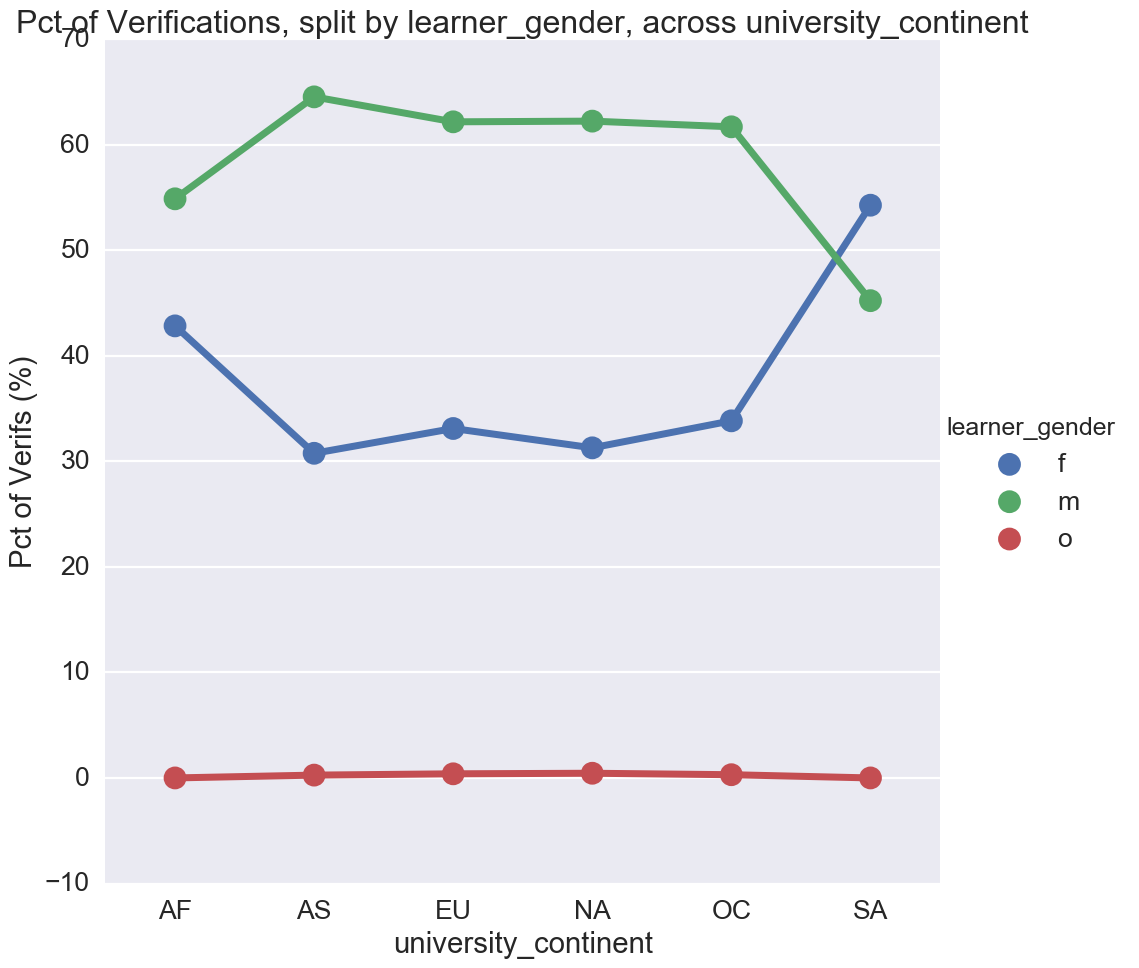

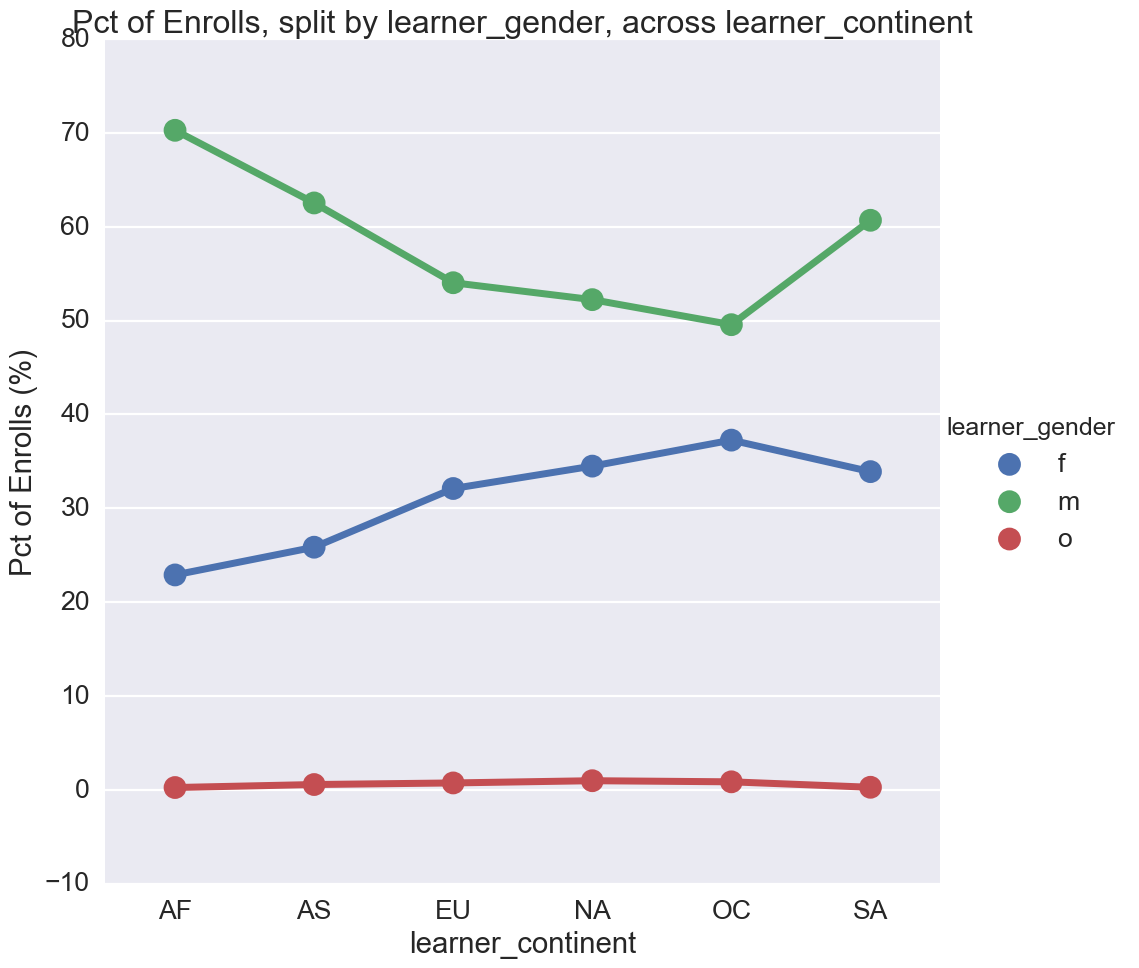

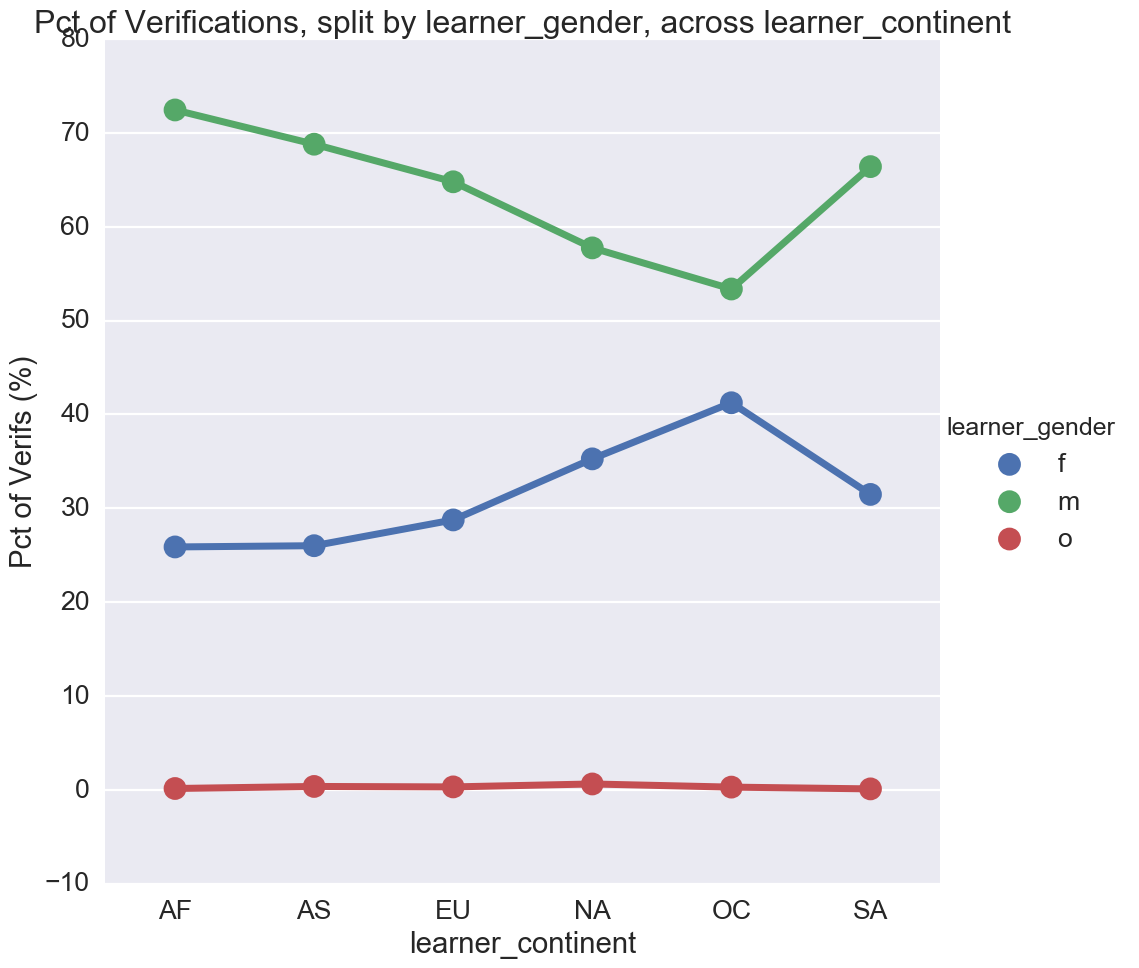

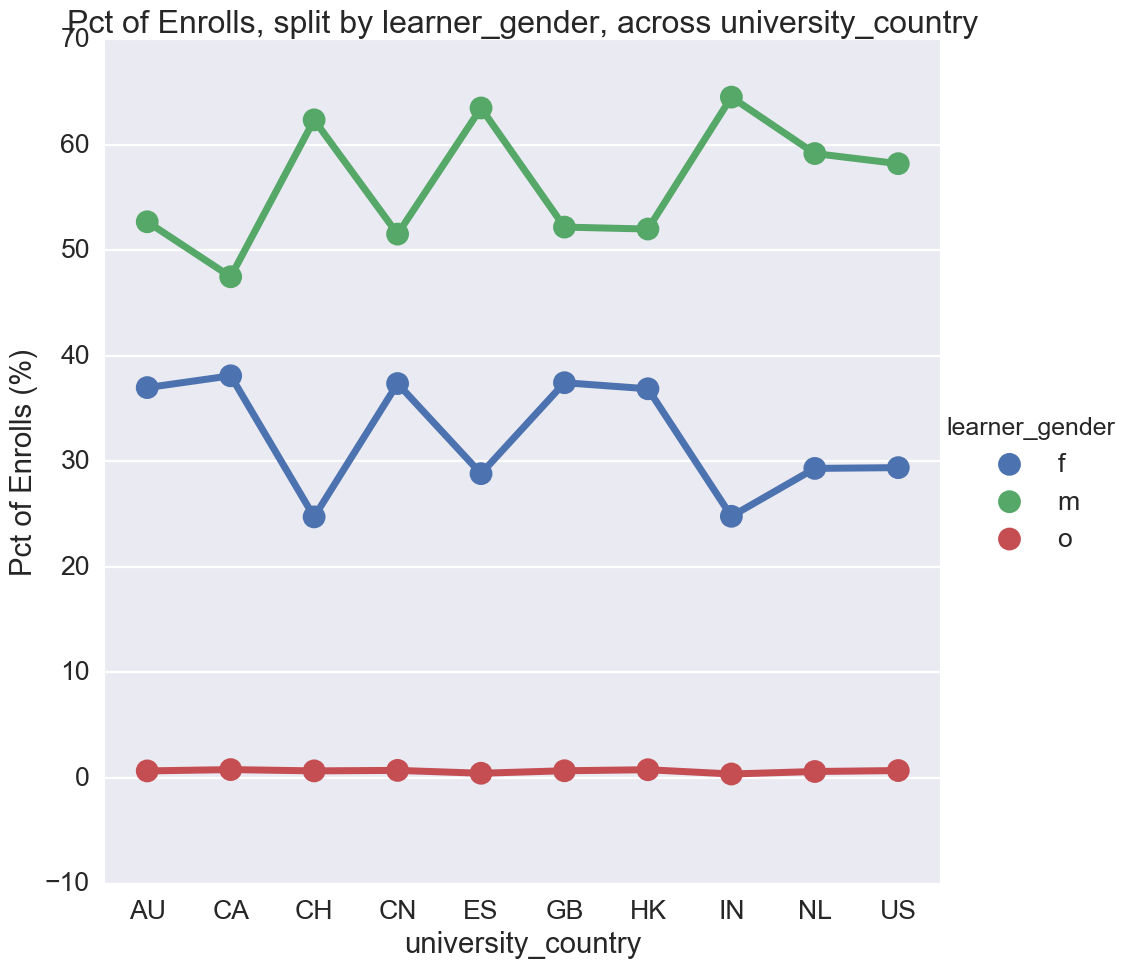

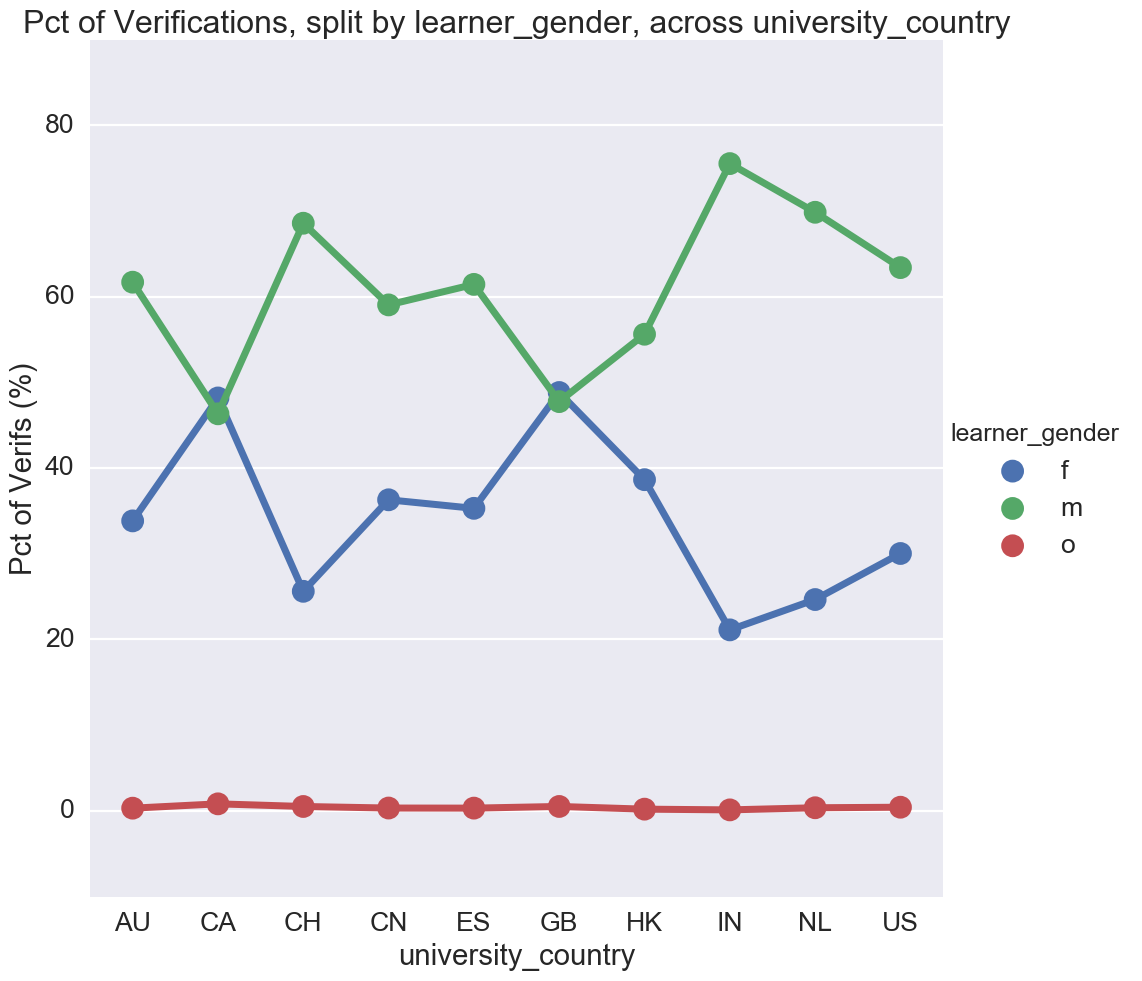

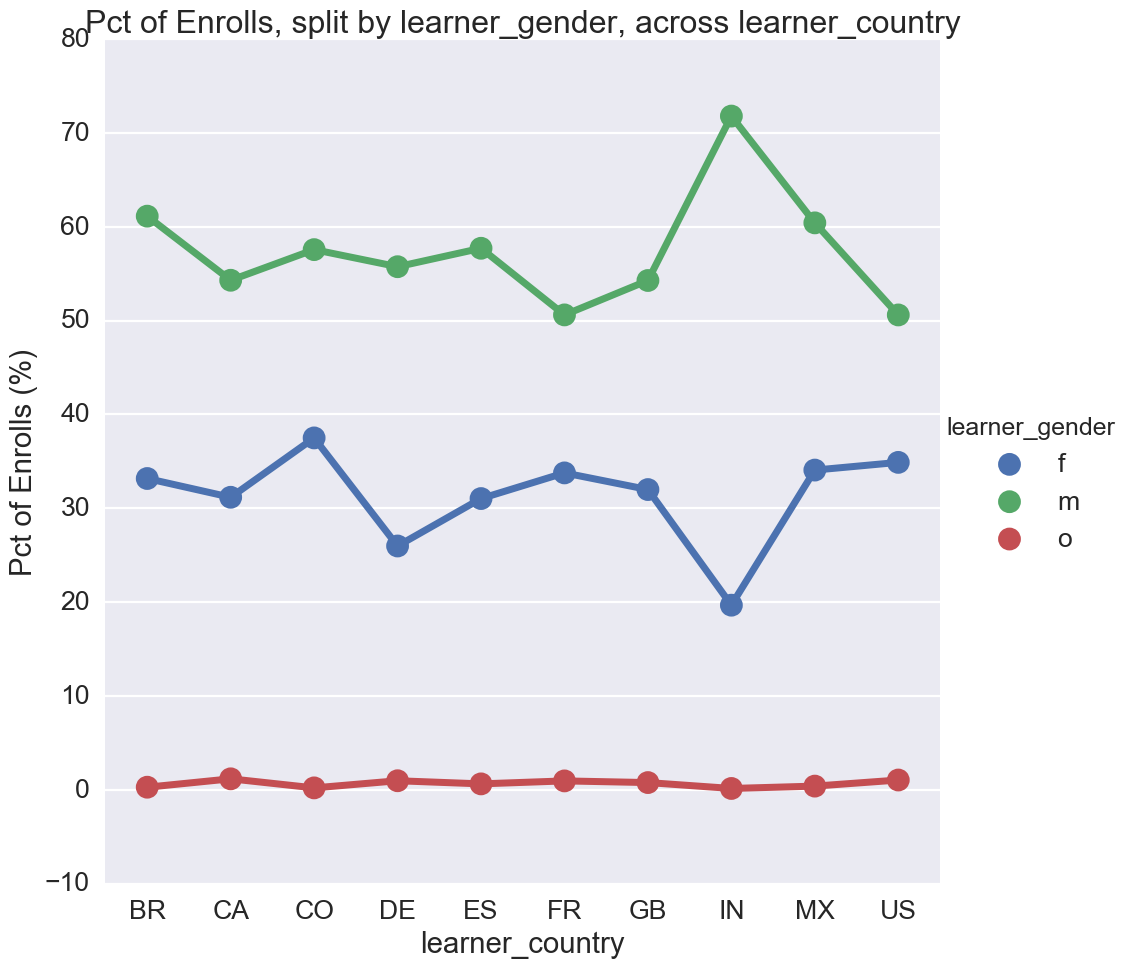

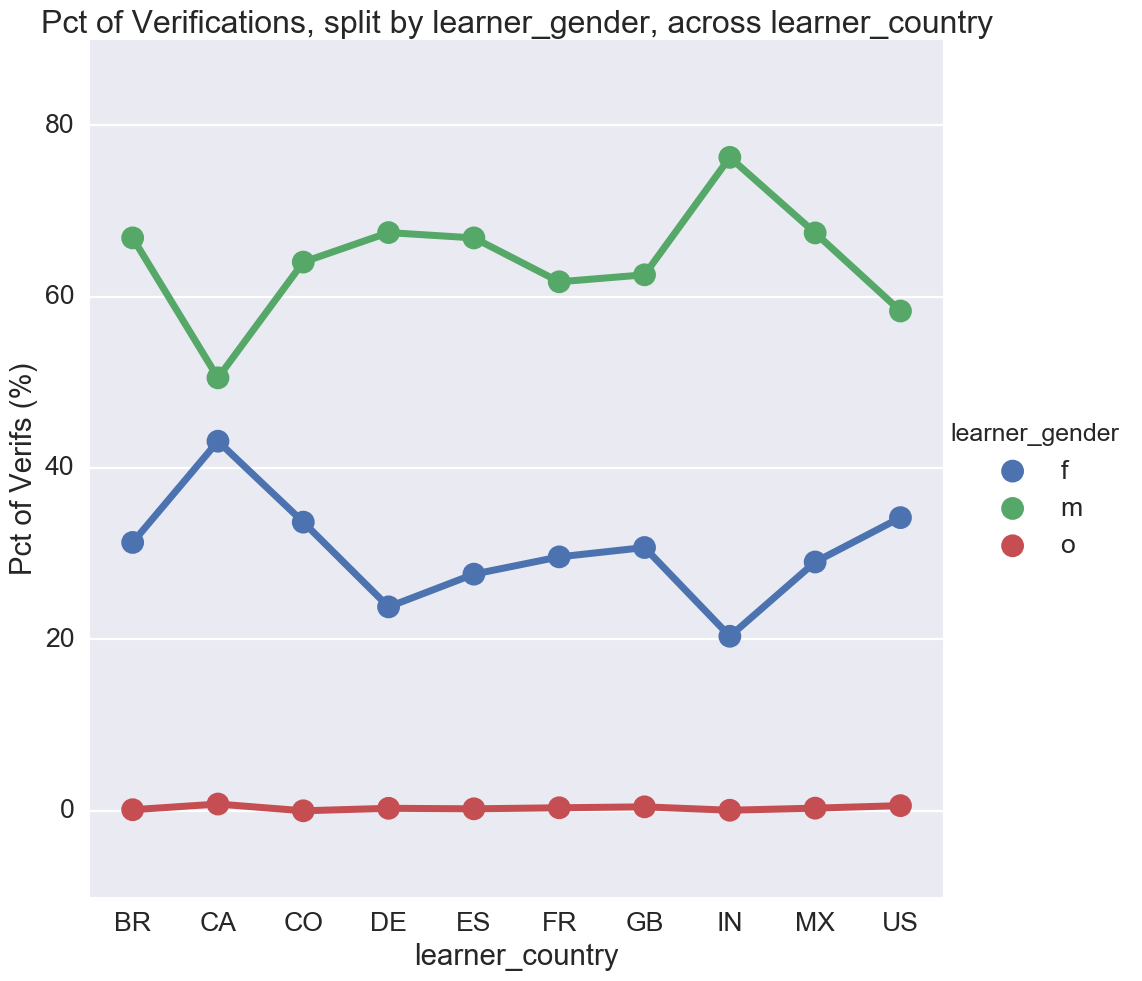

In [414]:
gender_list = ['m', 'f', 'o']

make_plots_demographics(gender_df, 'learner_gender', gender_list, 'university_continent')
make_plots_demographics(gender_df, 'learner_gender', gender_list, 'learner_continent')
make_plots_demographics(gender_df, 'learner_gender', gender_list, 'university_country', 10)
make_plots_demographics(gender_df, 'learner_gender', gender_list, 'learner_country', 10)

## VTR by University Continent (courses > 1000 enrollments)

In [305]:
course_filter_list = master_w_course_df.groupby(['course_id']).sum().reset_index()[master_w_course_df.groupby(['course_id']).sum().reset_index().cnt_enrolls > 1000]
course_filter_list = course_filter_list.course_id.unique()

In [315]:
subject_list = master_w_course_df.subject_title.unique()

In [308]:
vtr_agg = master_w_course_df.groupby(['university_continent', 'course_id']).sum().reset_index()
vtr_agg['vtr'] = vtr_agg.cnt_verifs*100.0/vtr_agg.cnt_enrolls

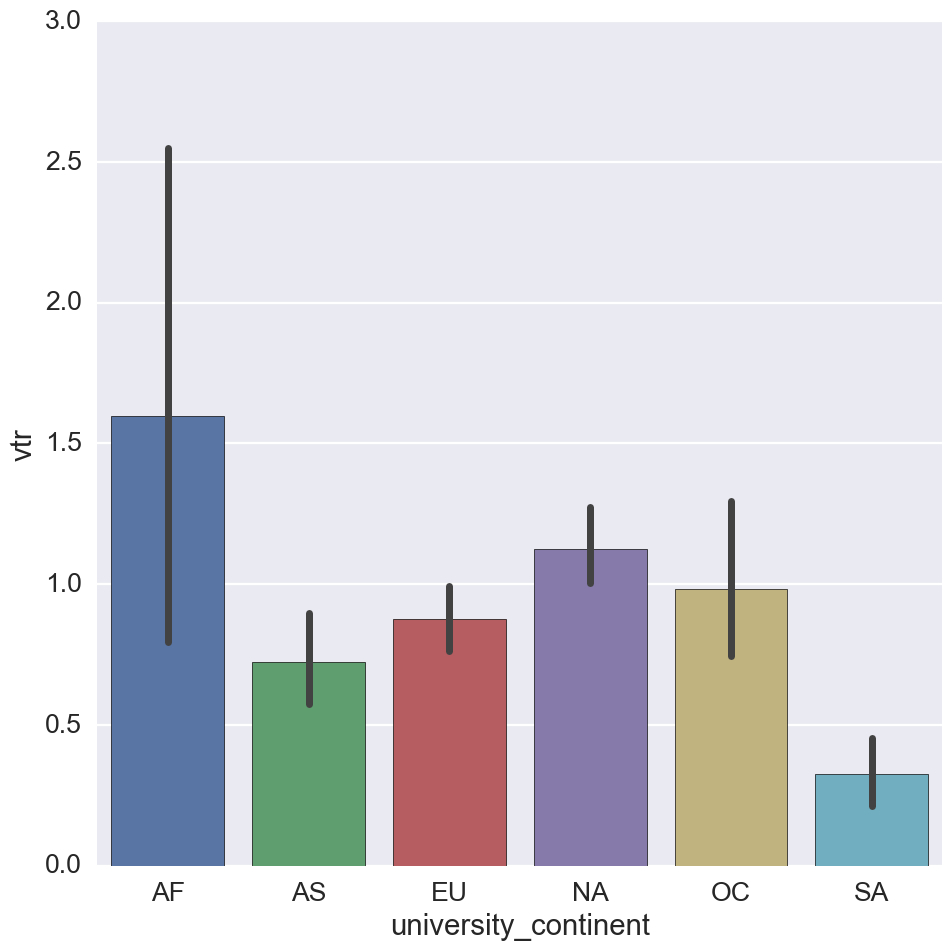

In [311]:
sns.factorplot(data = vtr_agg, x = 'university_continent', y = 'vtr', kind = 'bar', size = 10)

In [319]:
vtr_agg_subject = master_w_course_df.groupby(['university_continent', 'course_id', 'subject_title']).sum().reset_index()
vtr_agg_subject['vtr'] = vtr_agg_subject.cnt_verifs*100.0/vtr_agg_subject.cnt_enrolls

/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


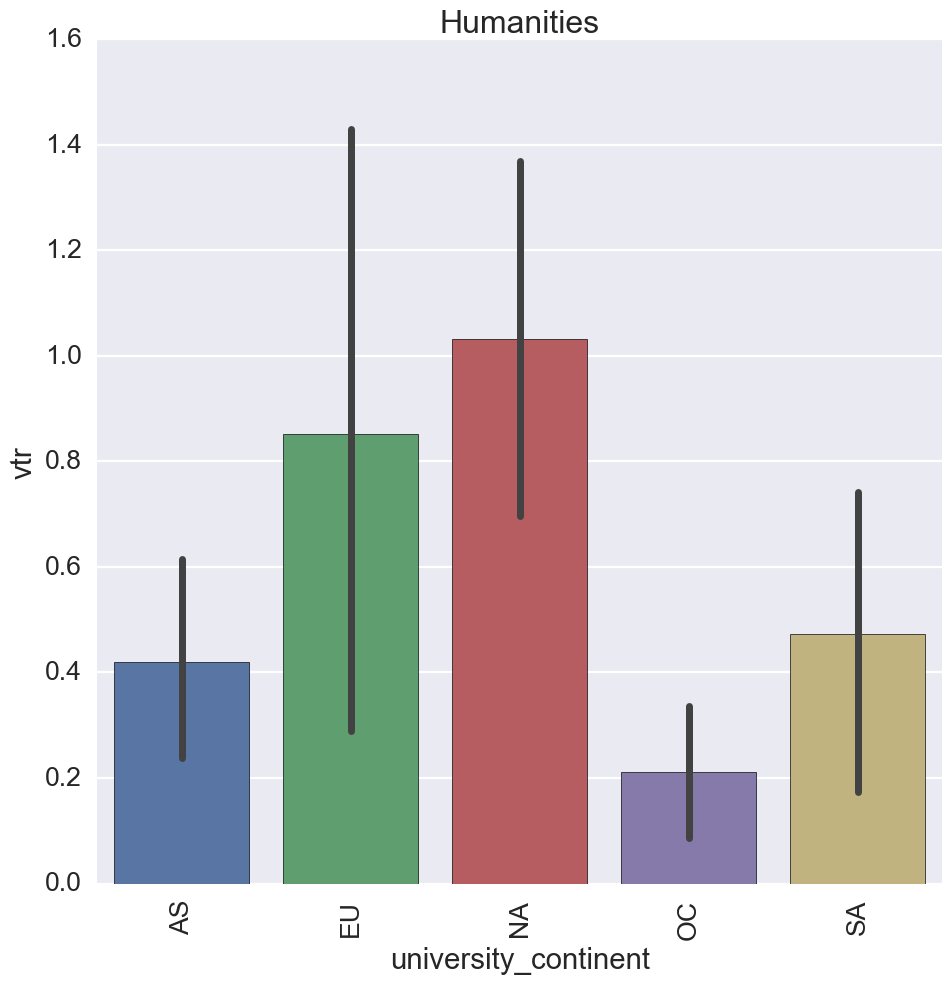

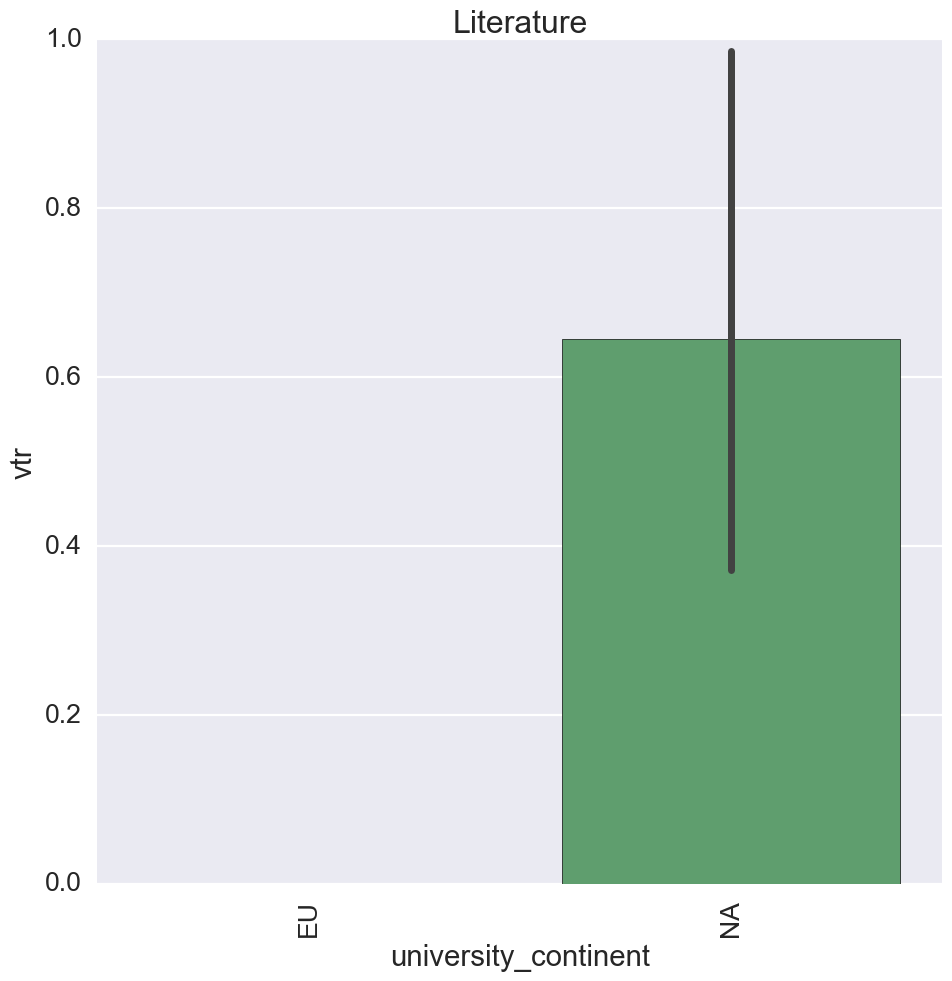

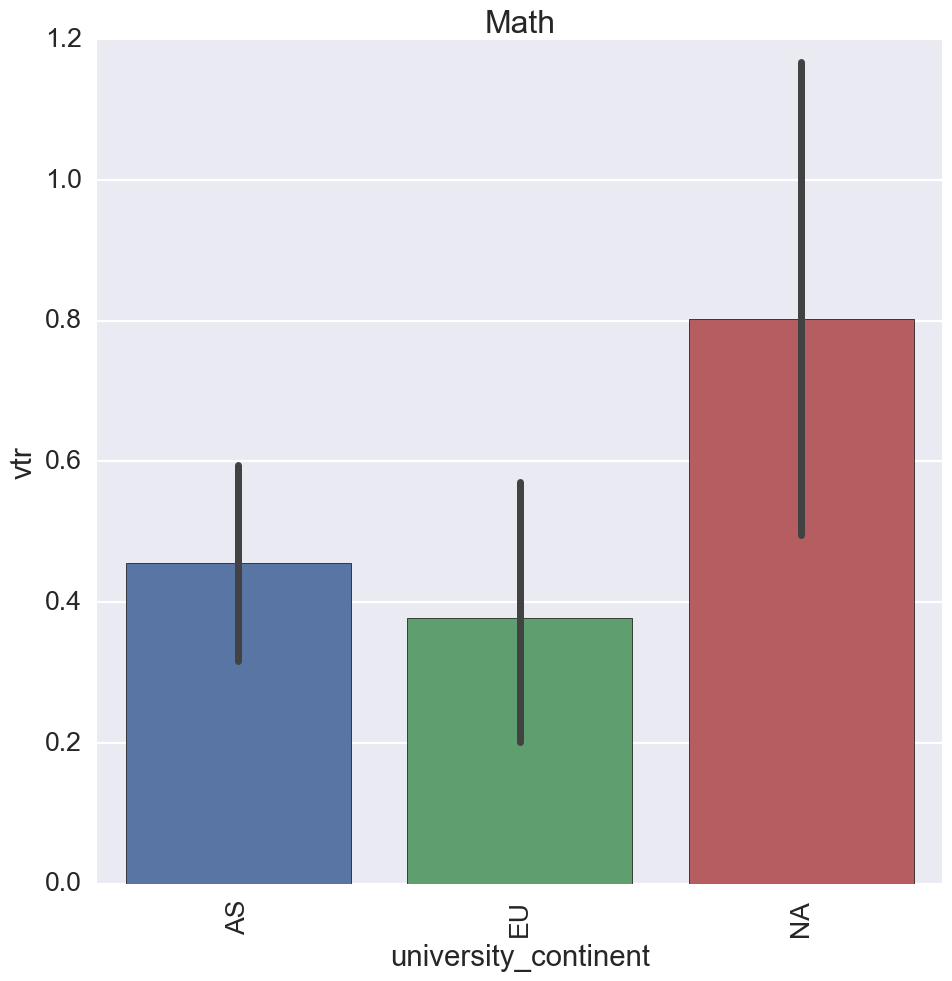

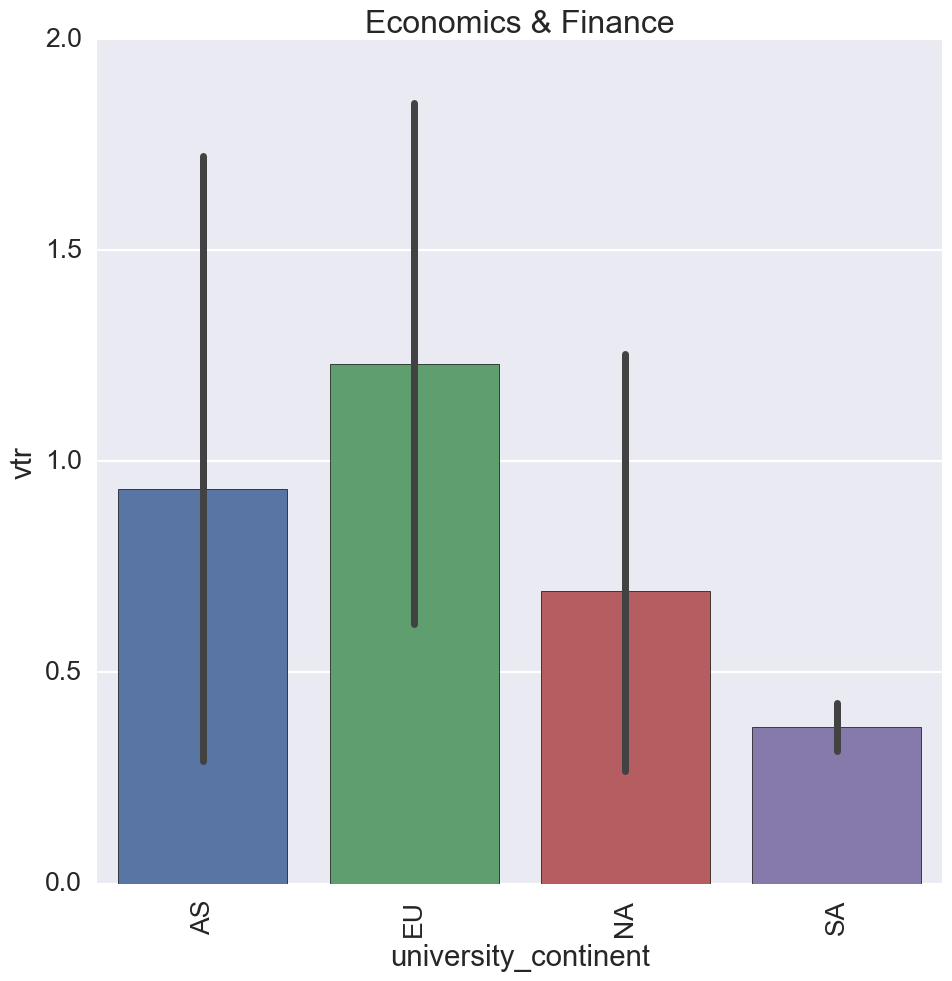

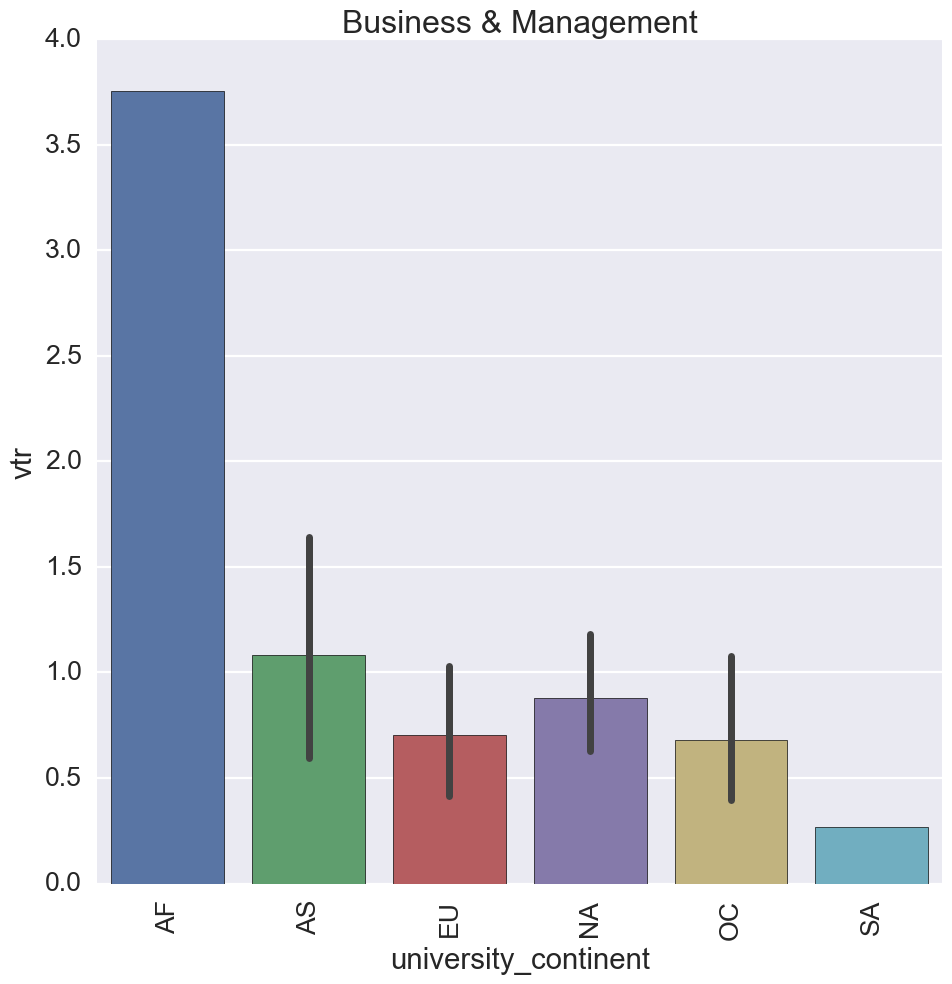

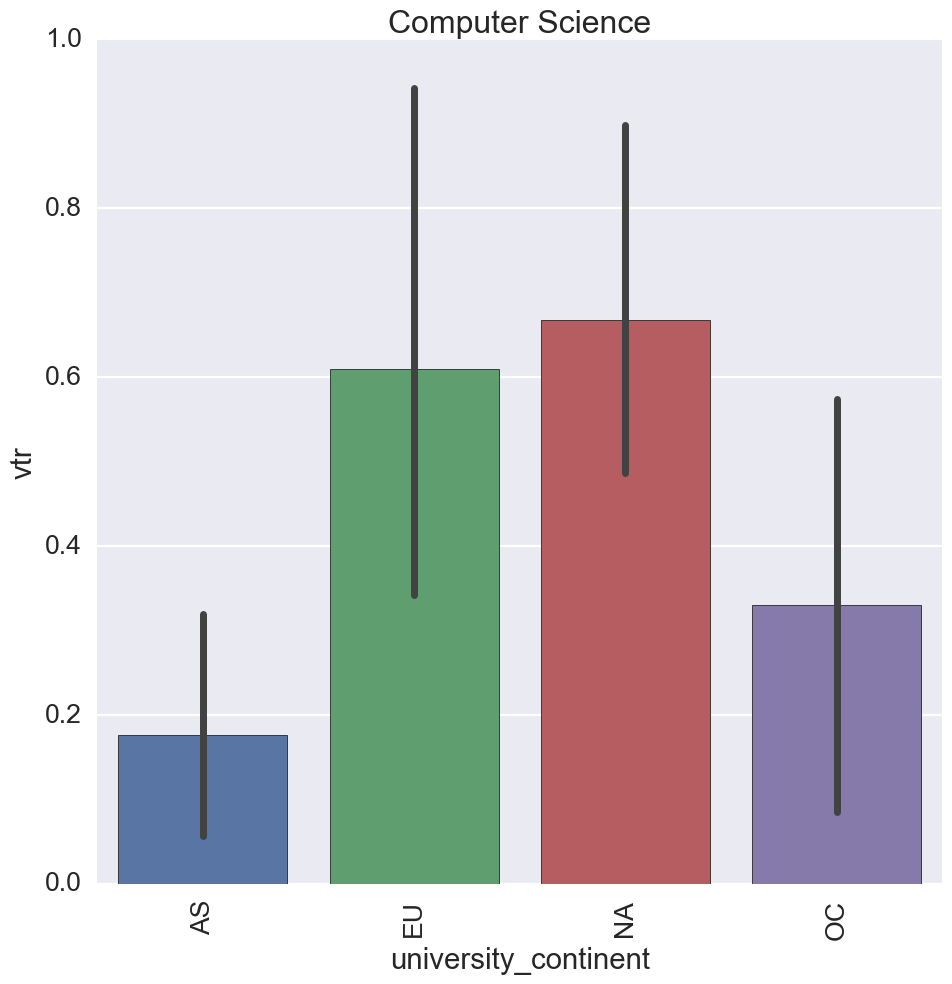

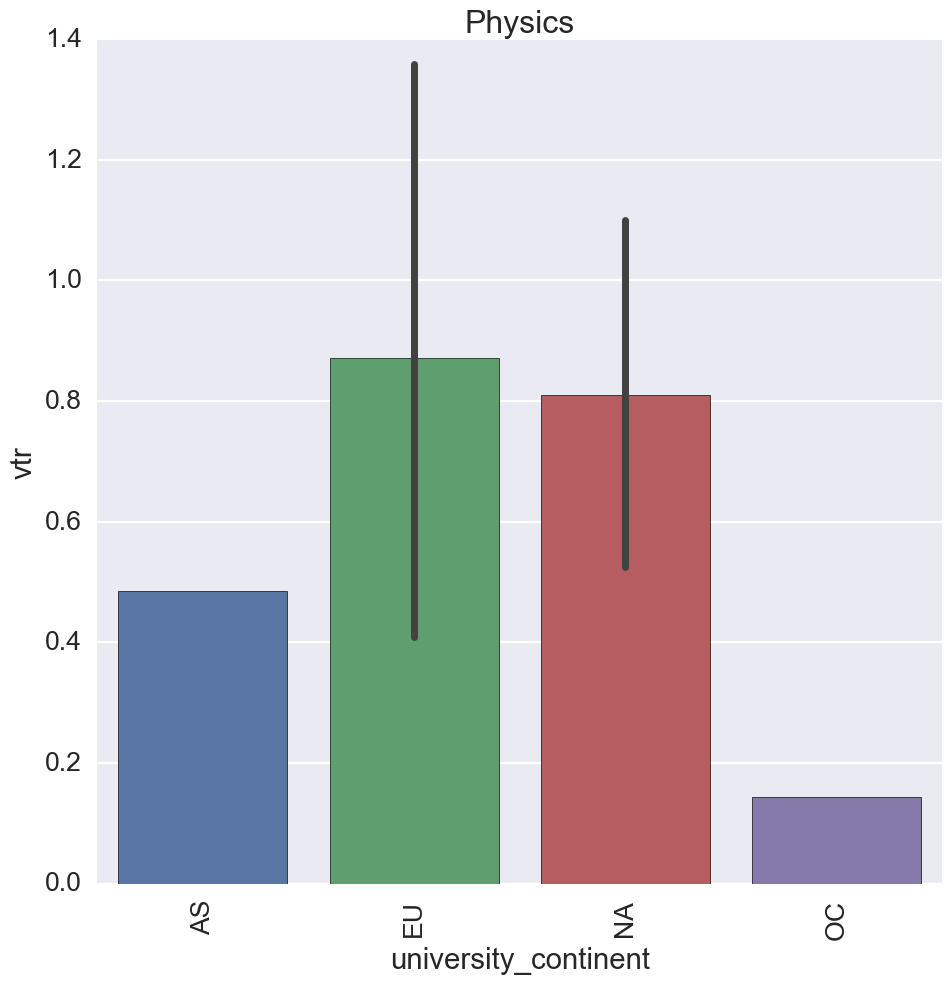

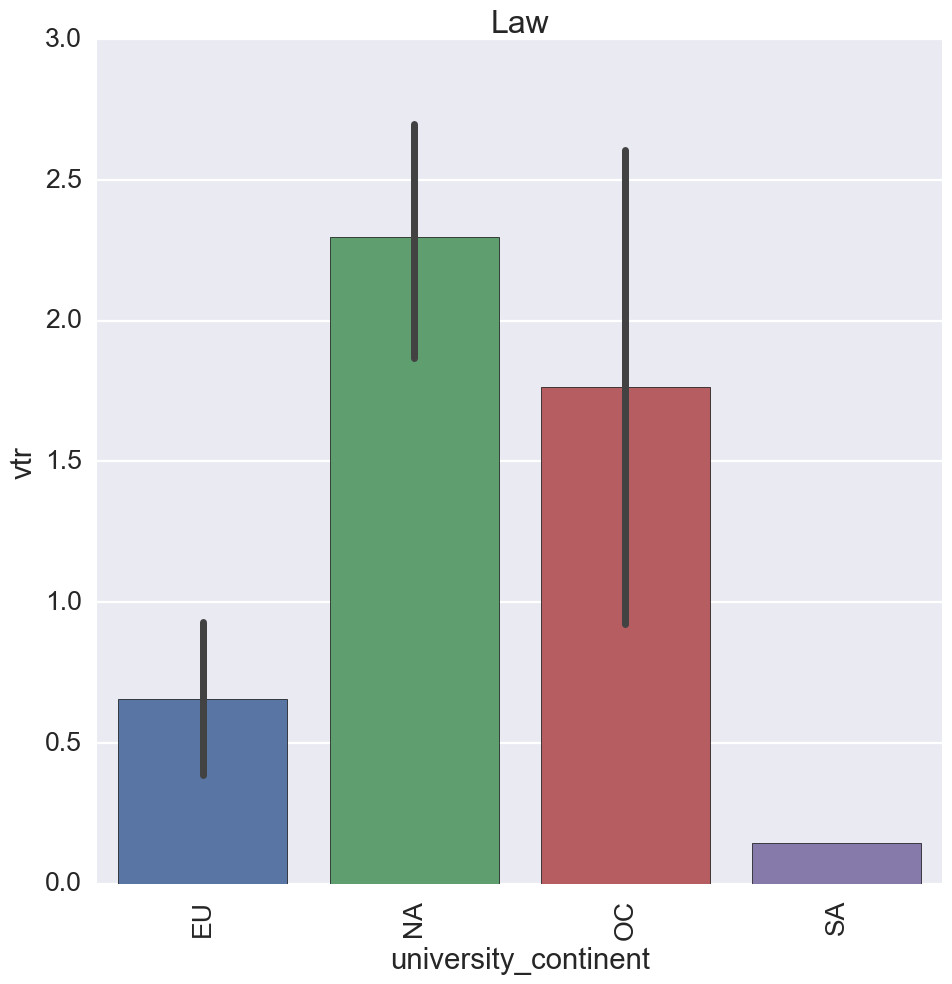

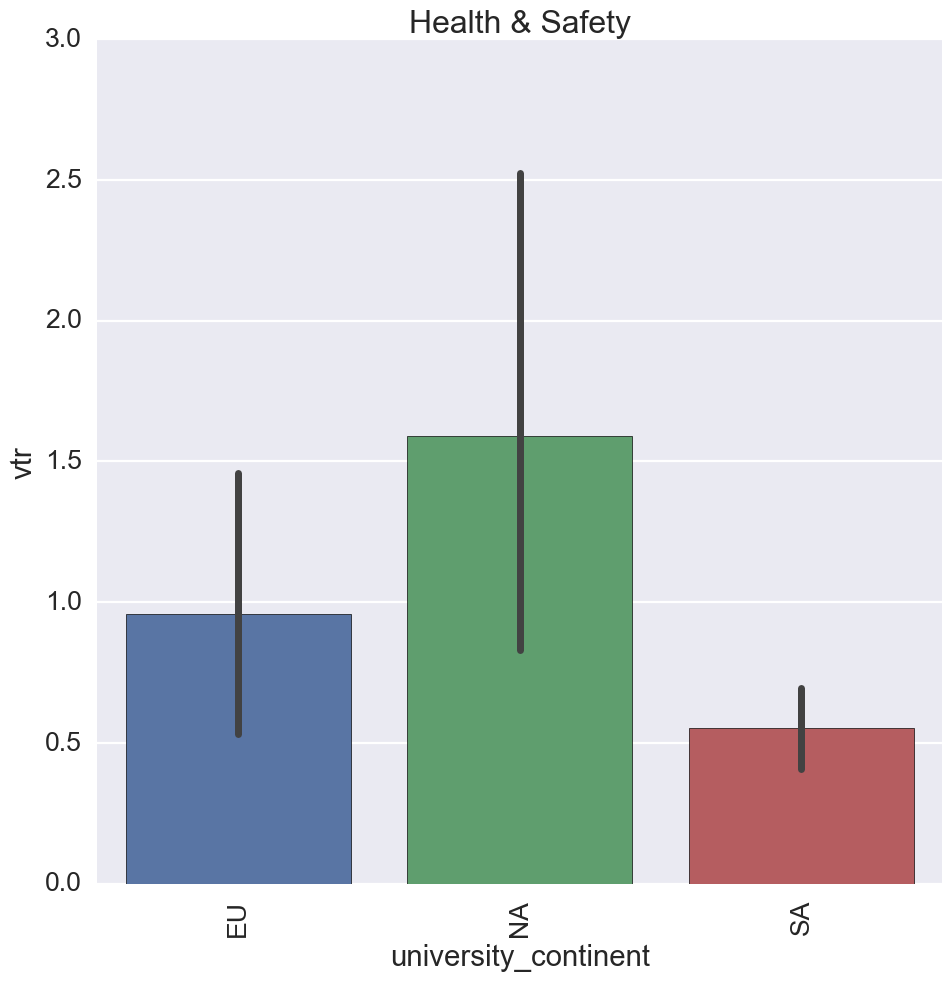

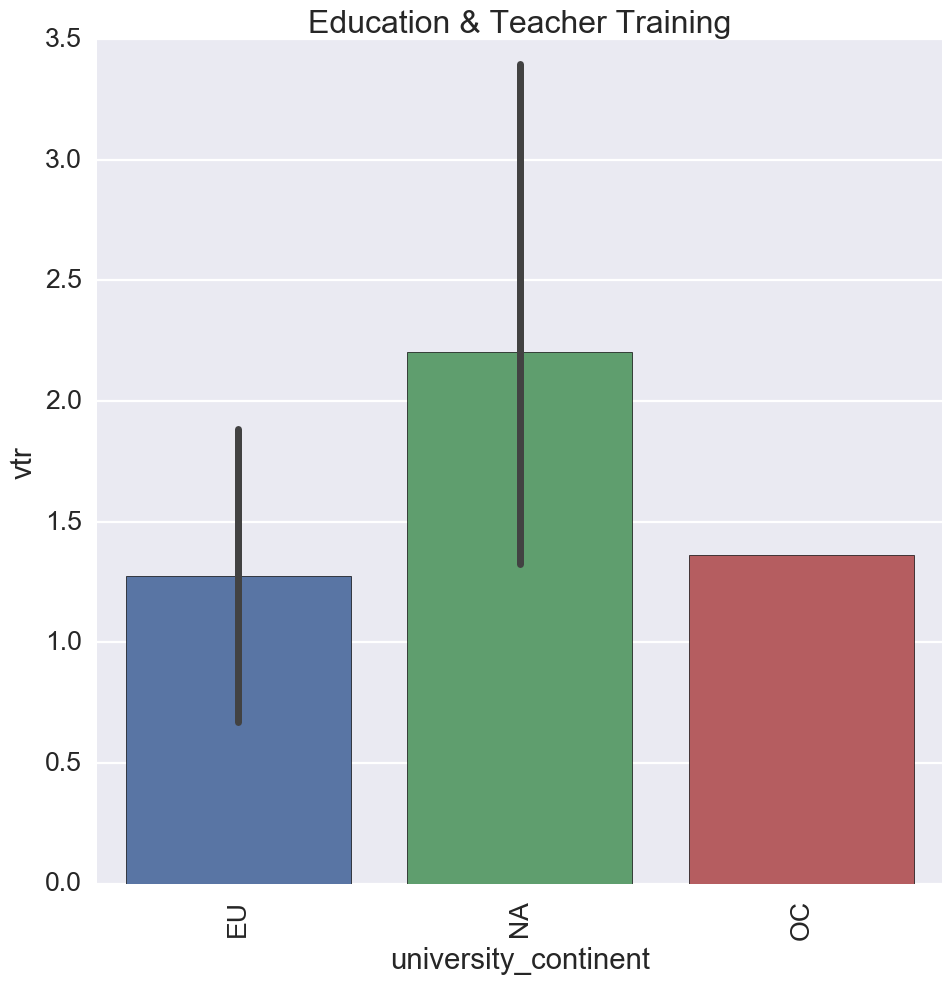

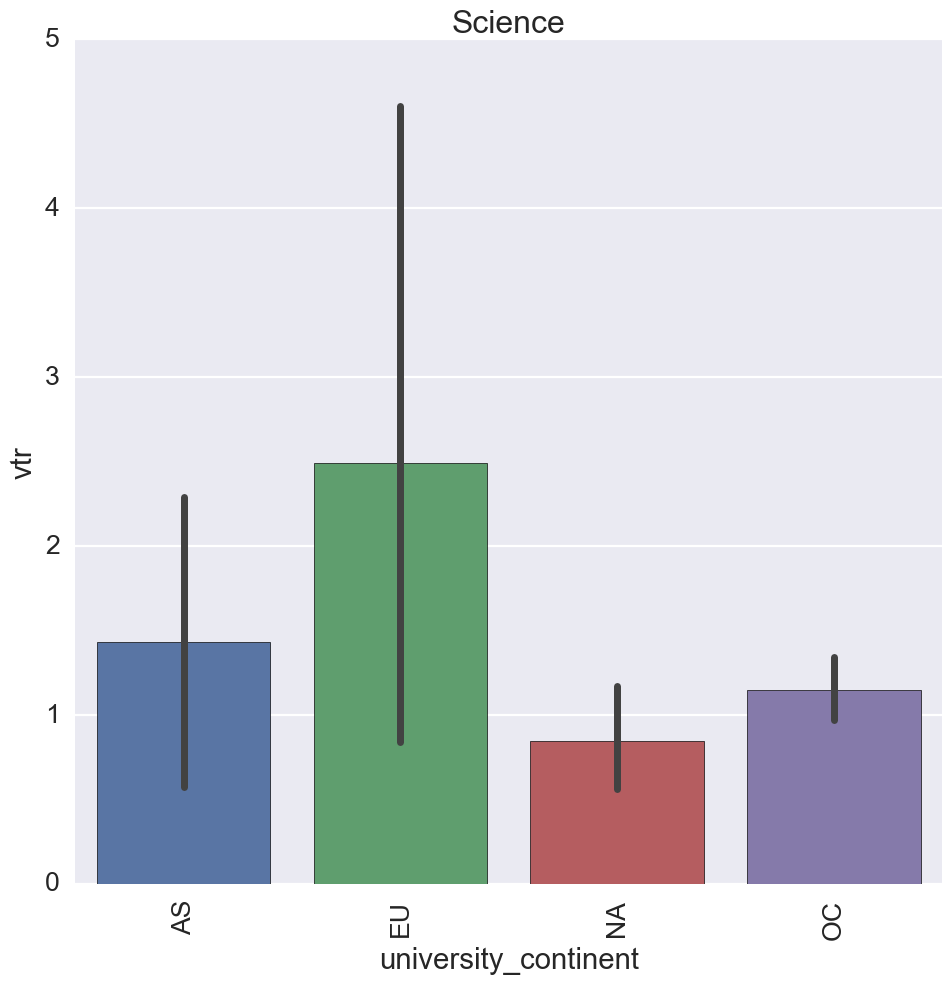

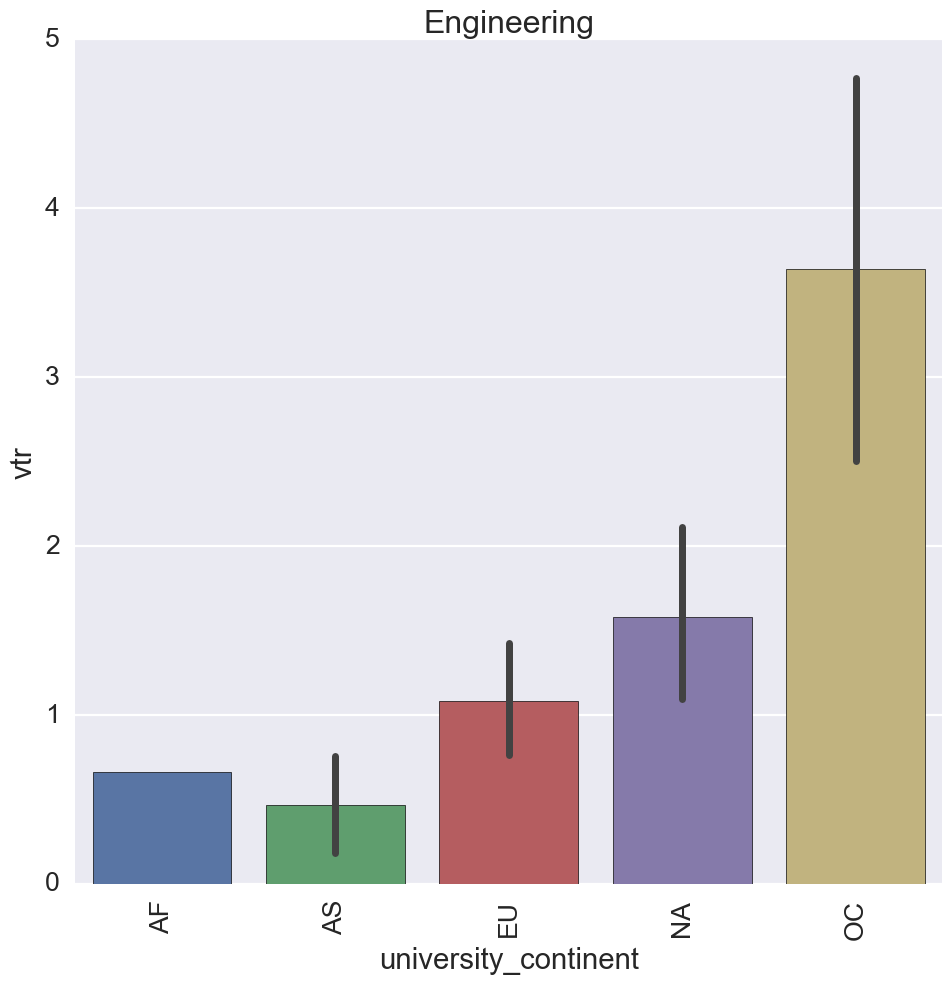

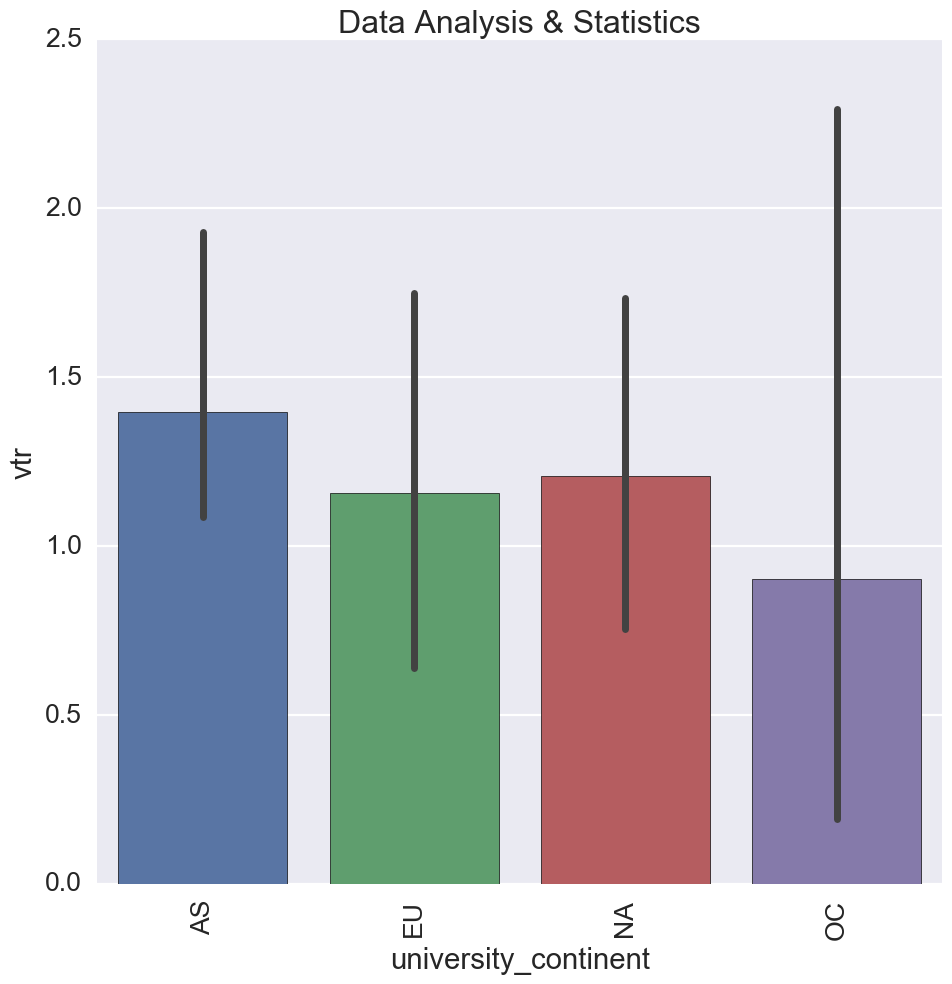

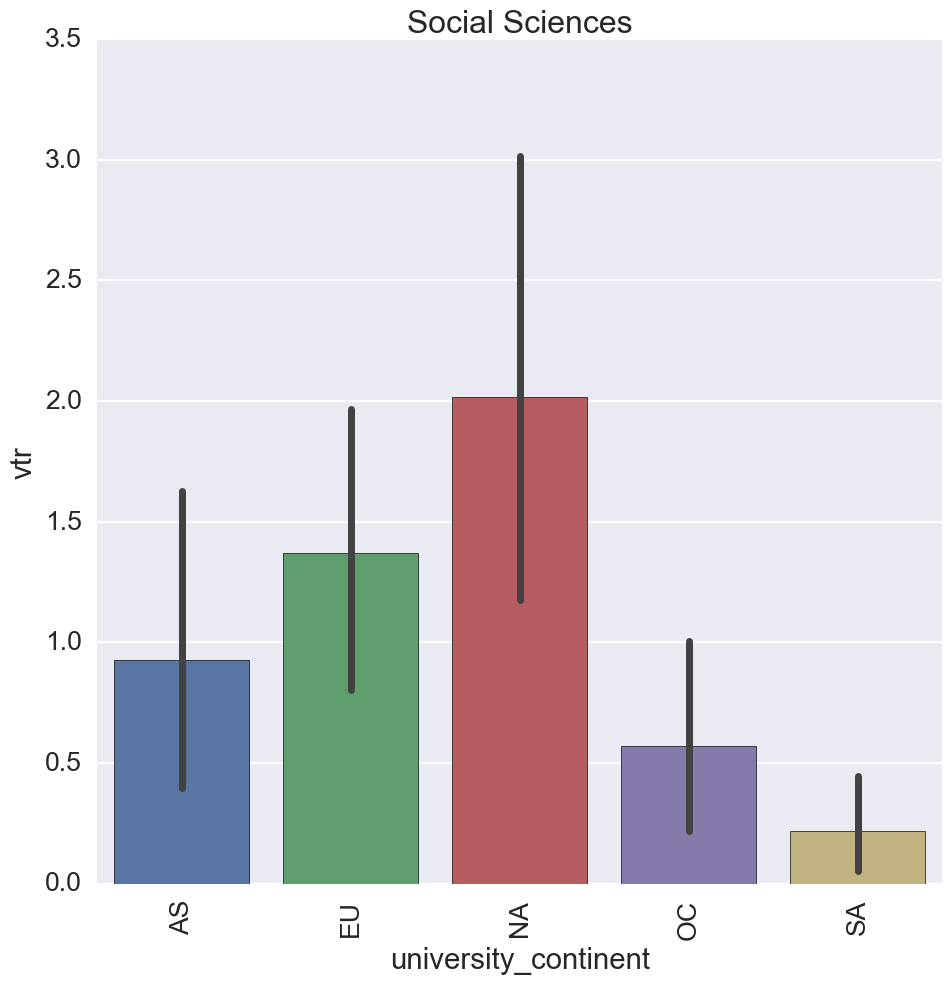

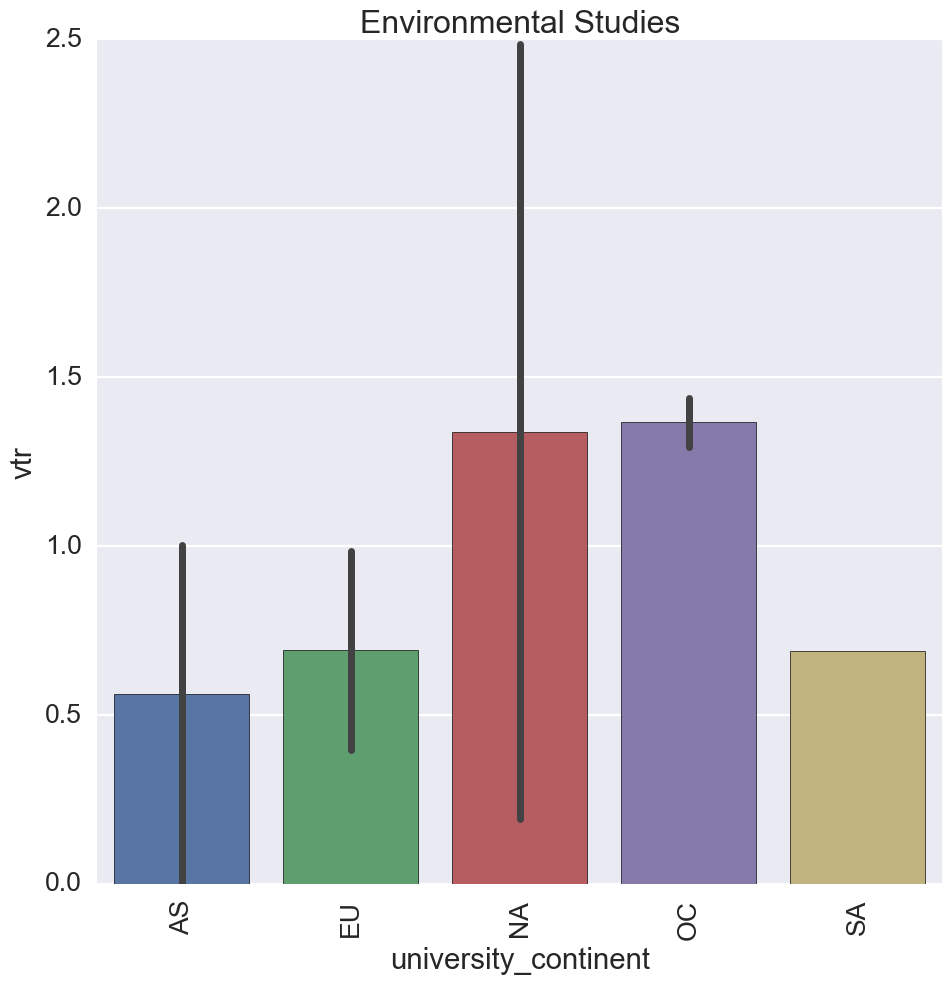

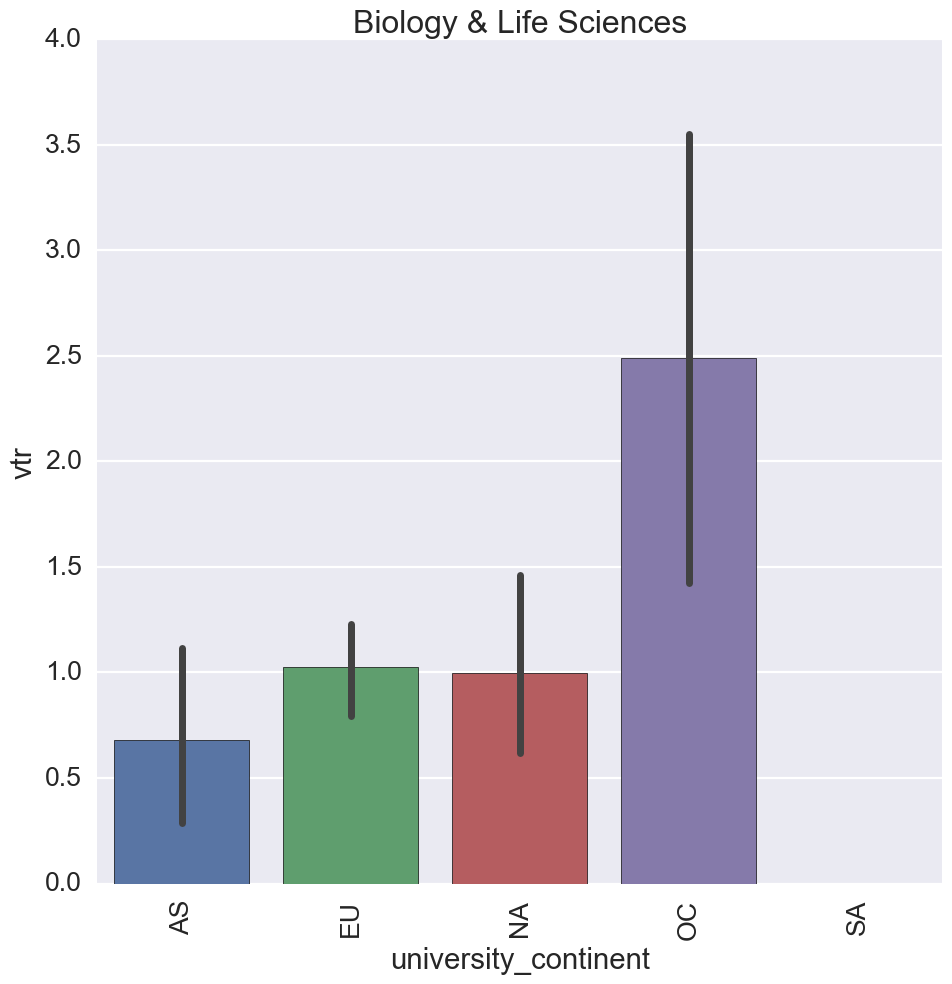

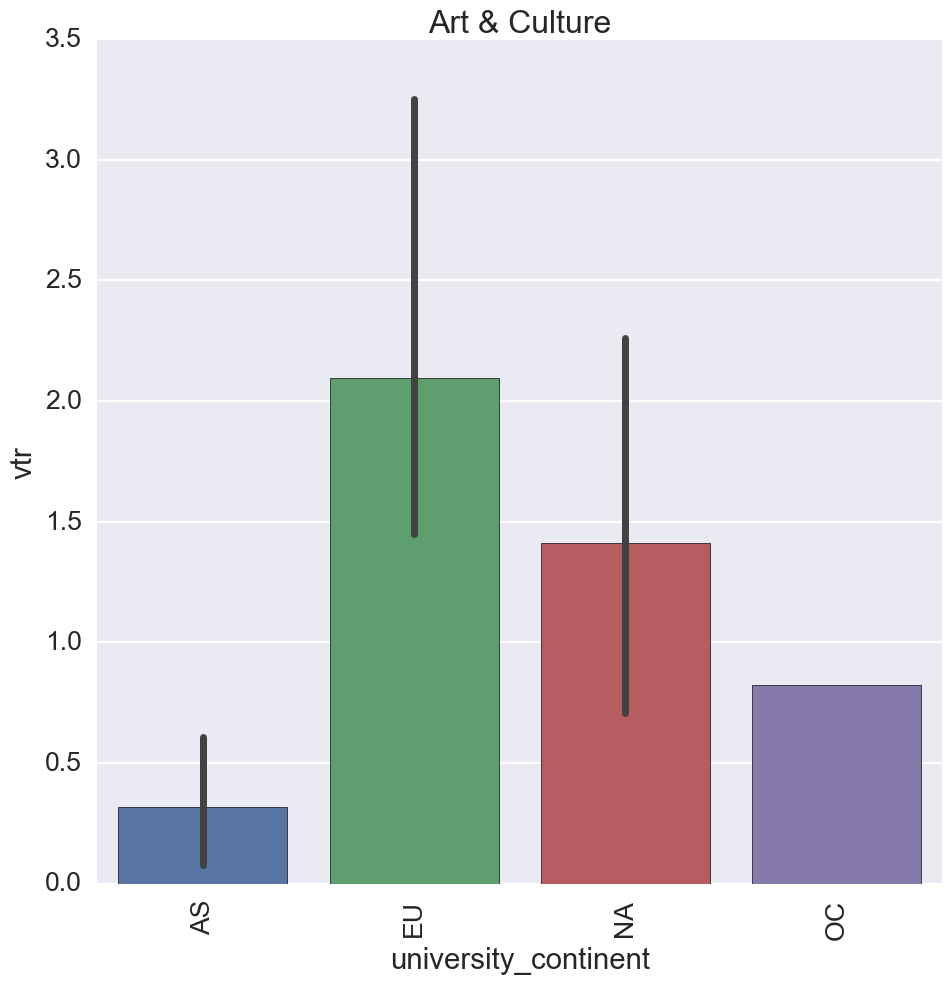

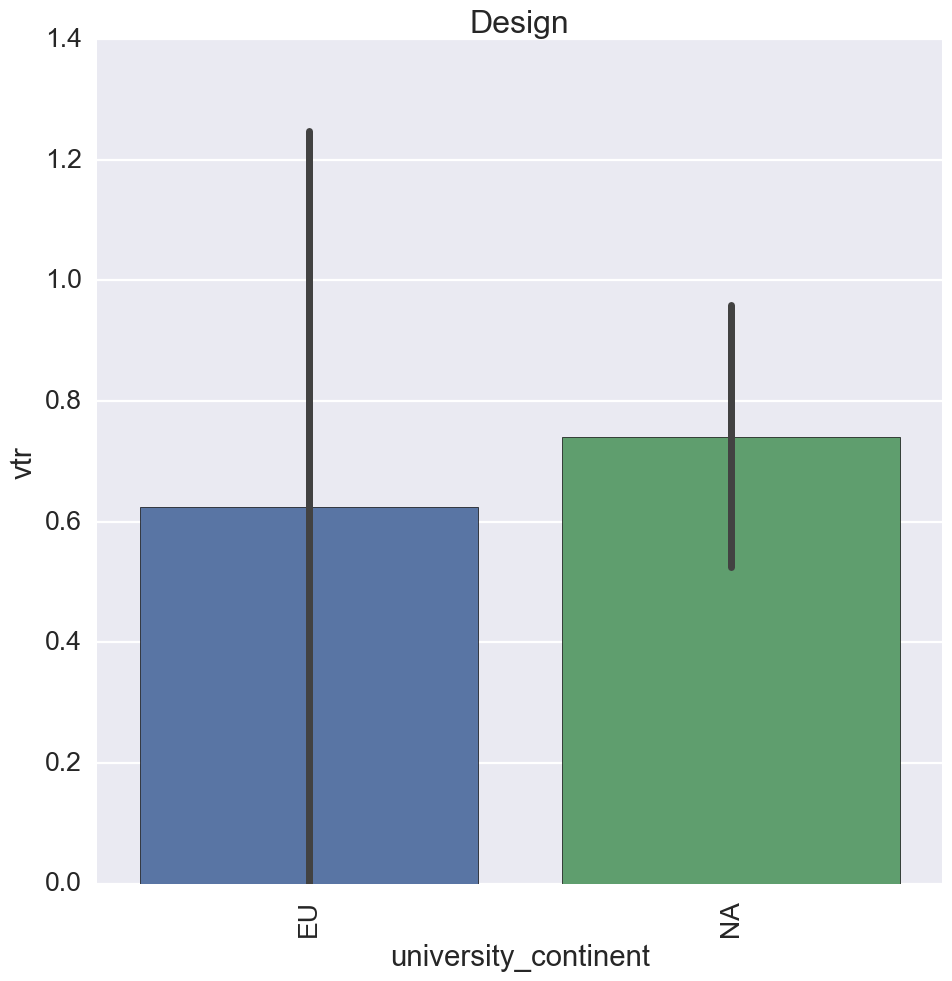

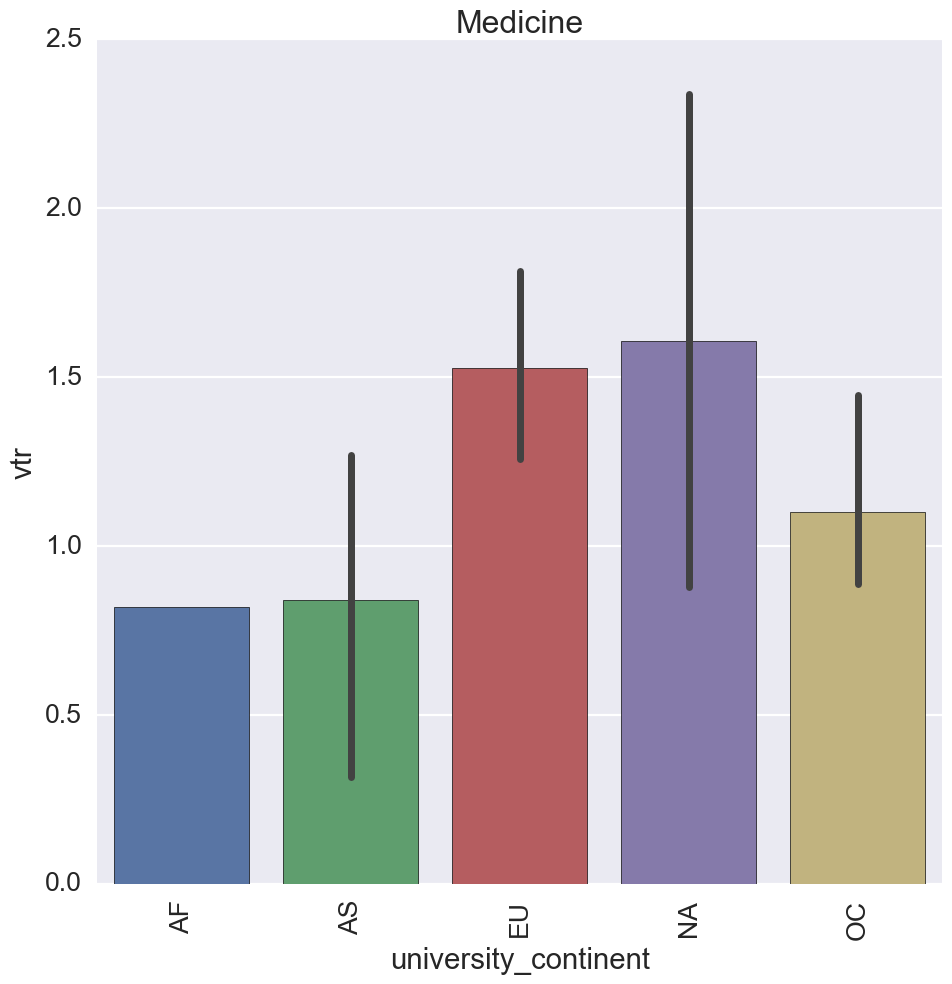

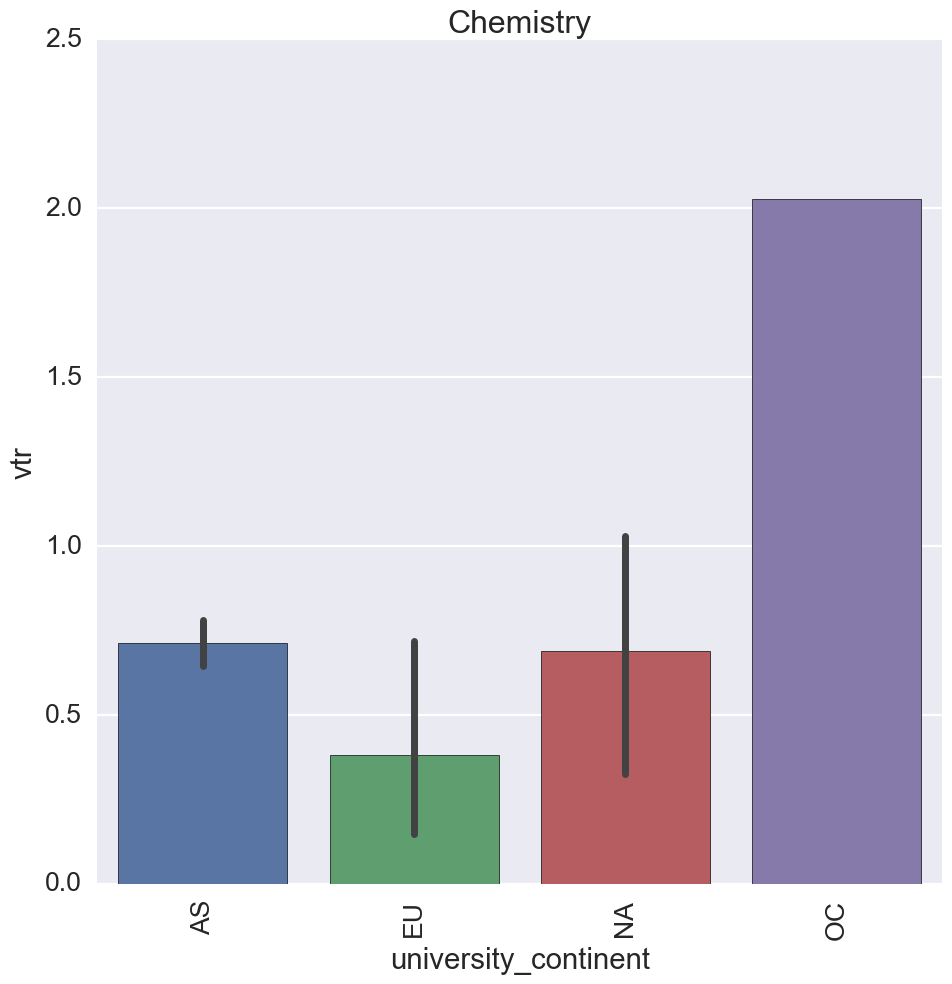

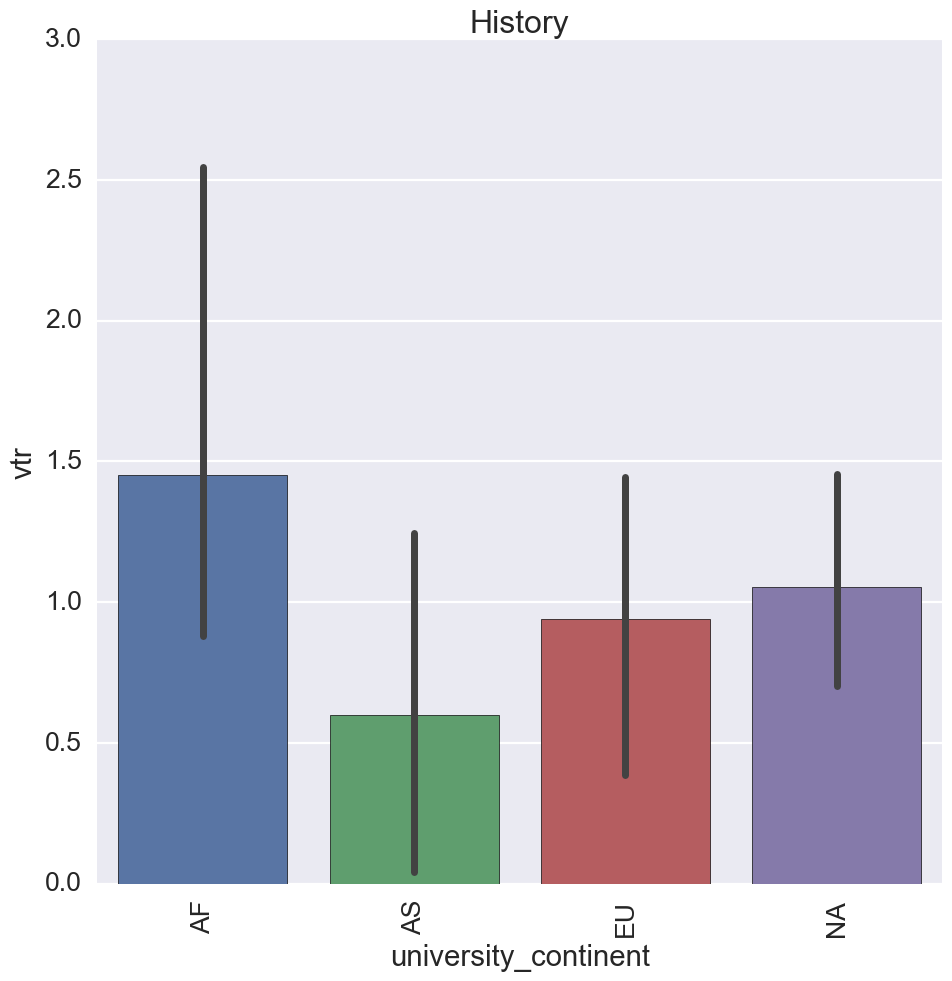

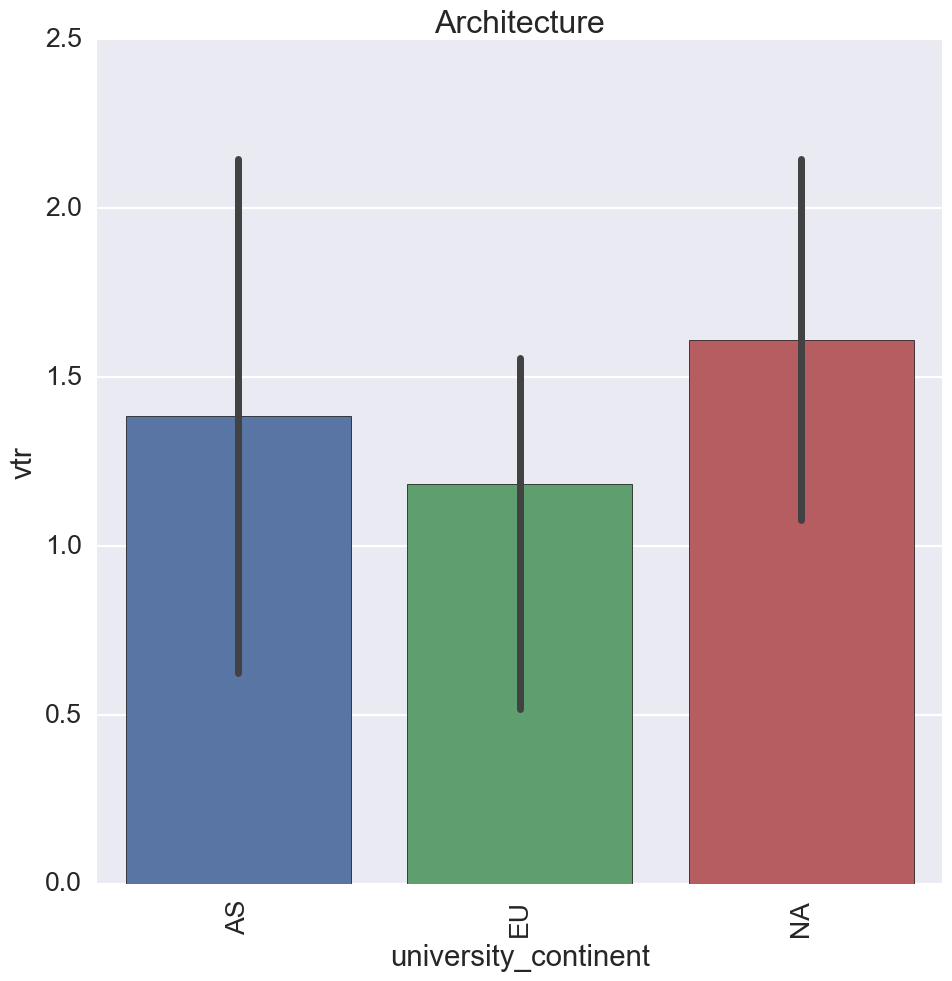

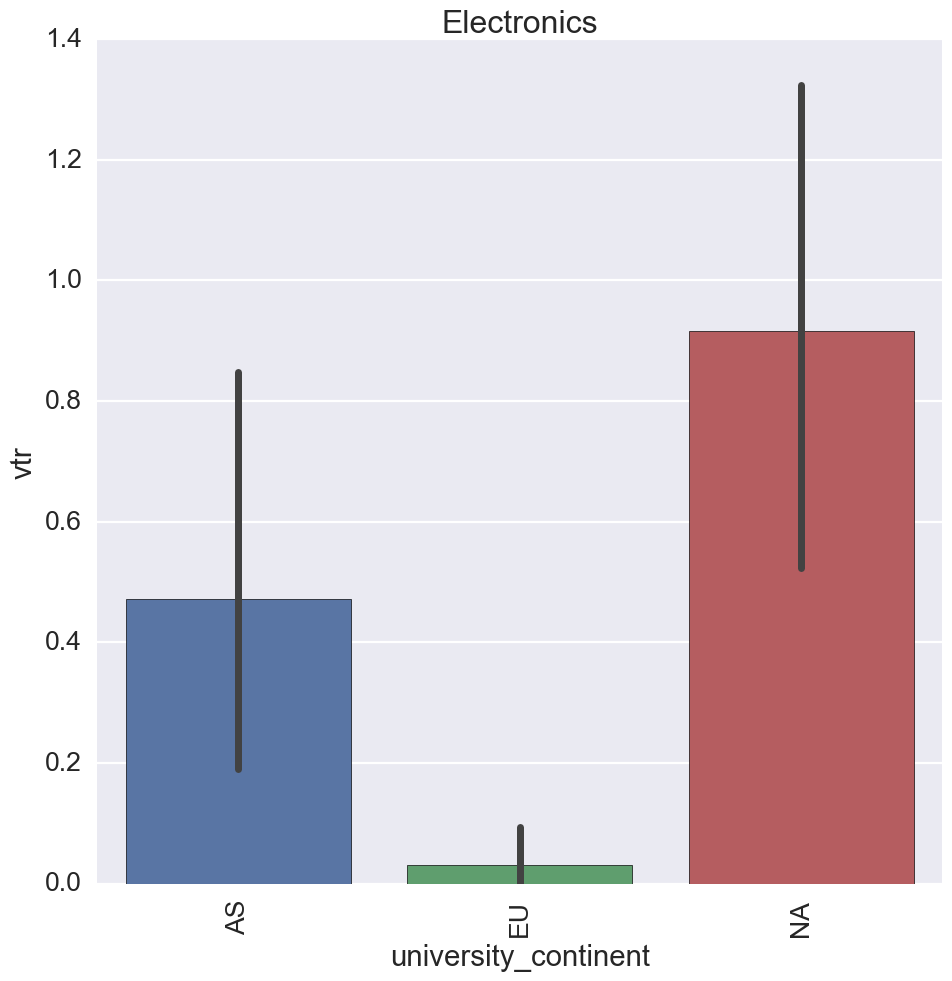

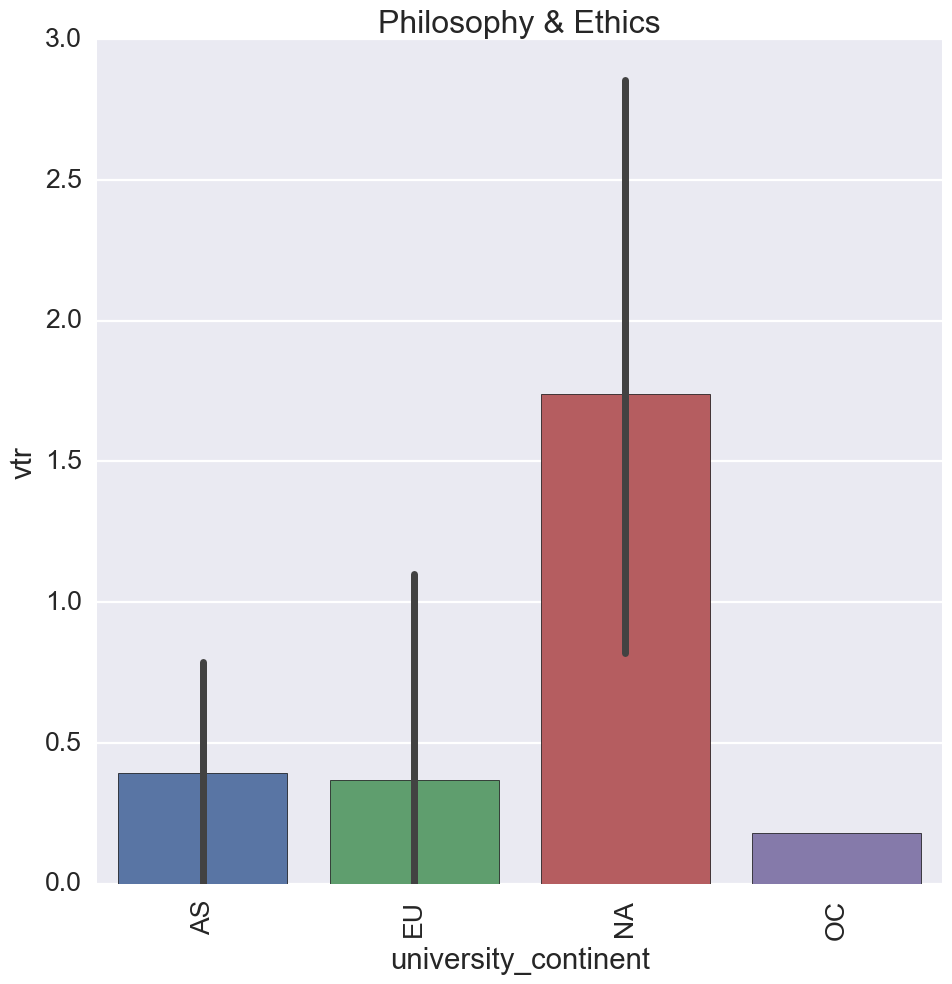

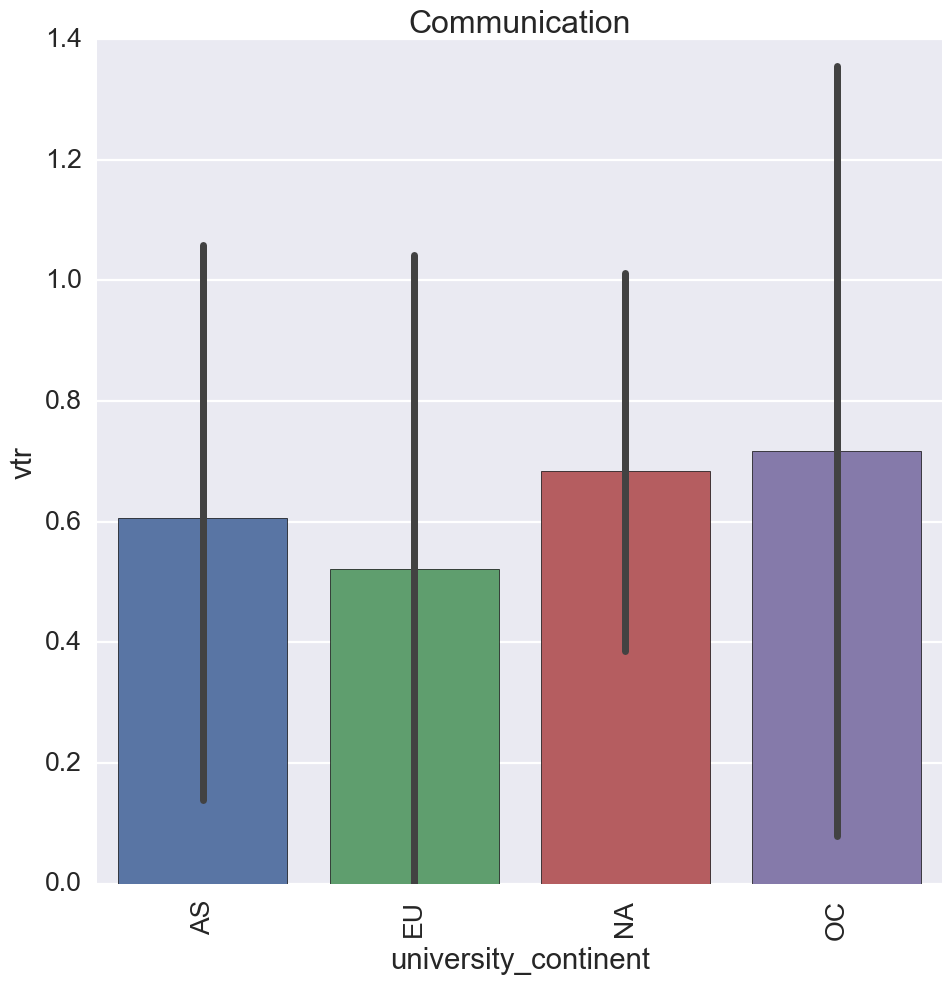

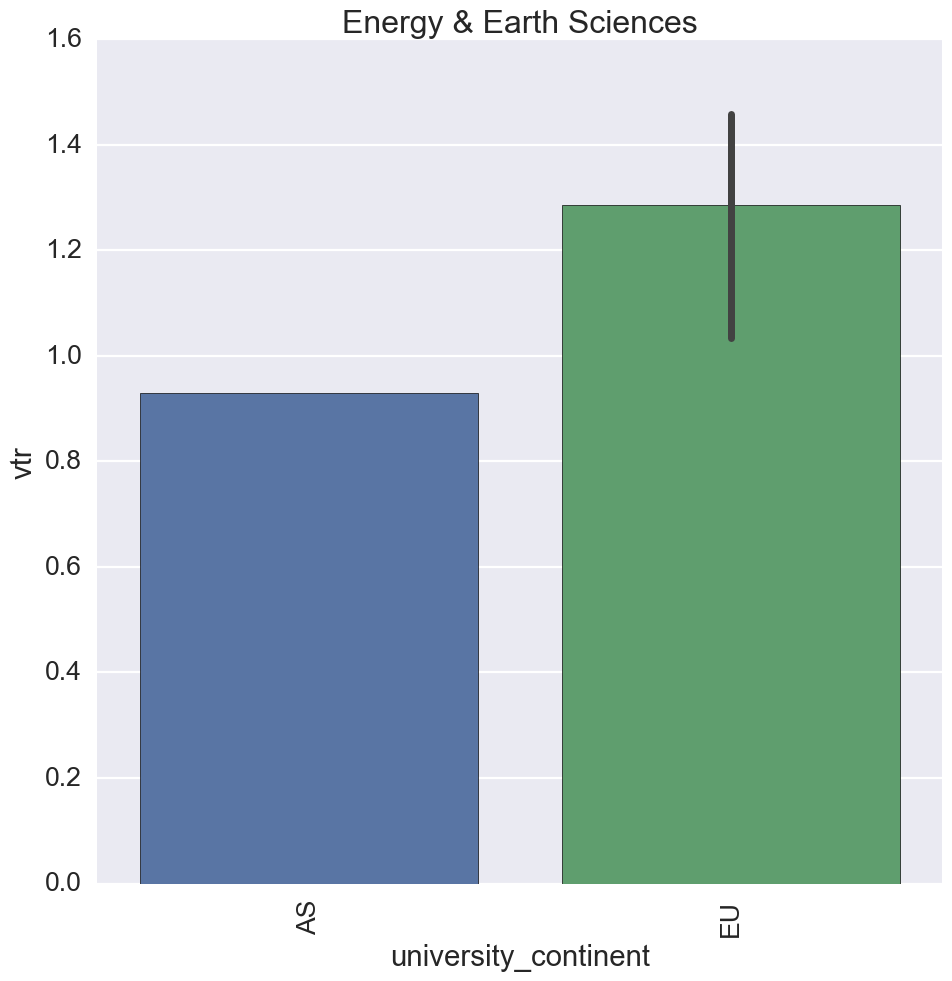

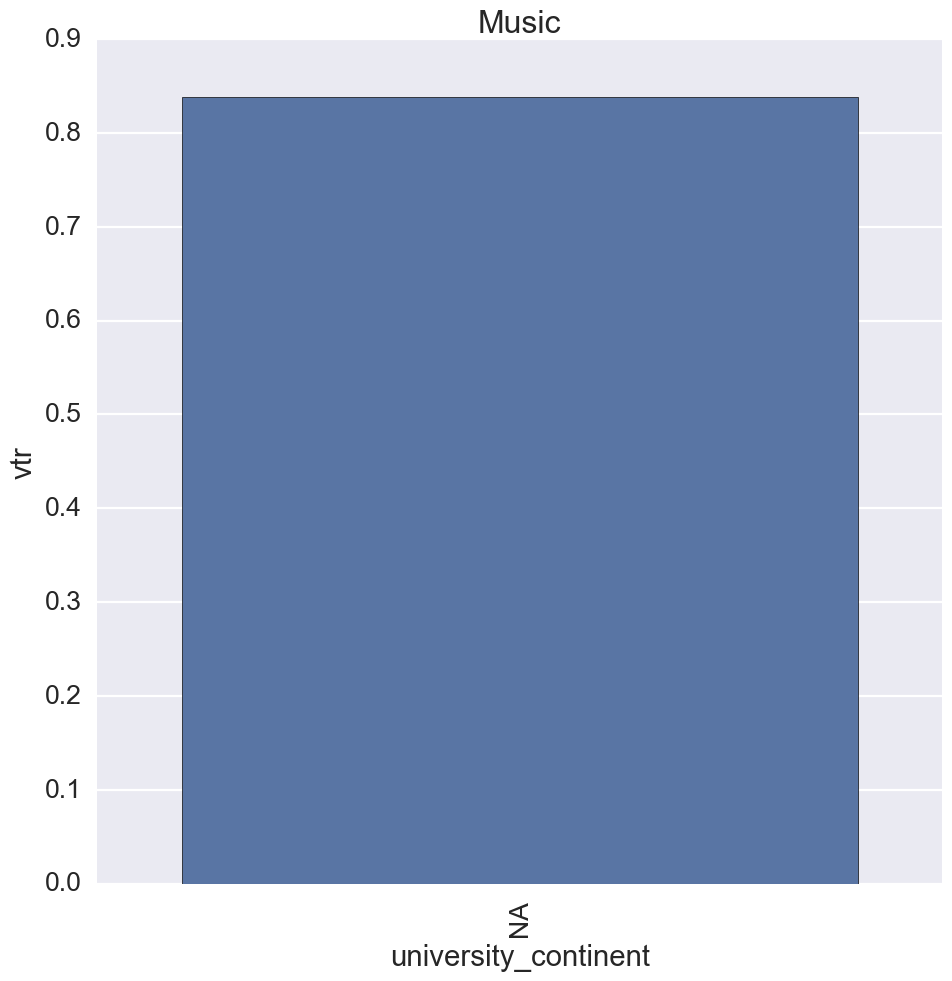

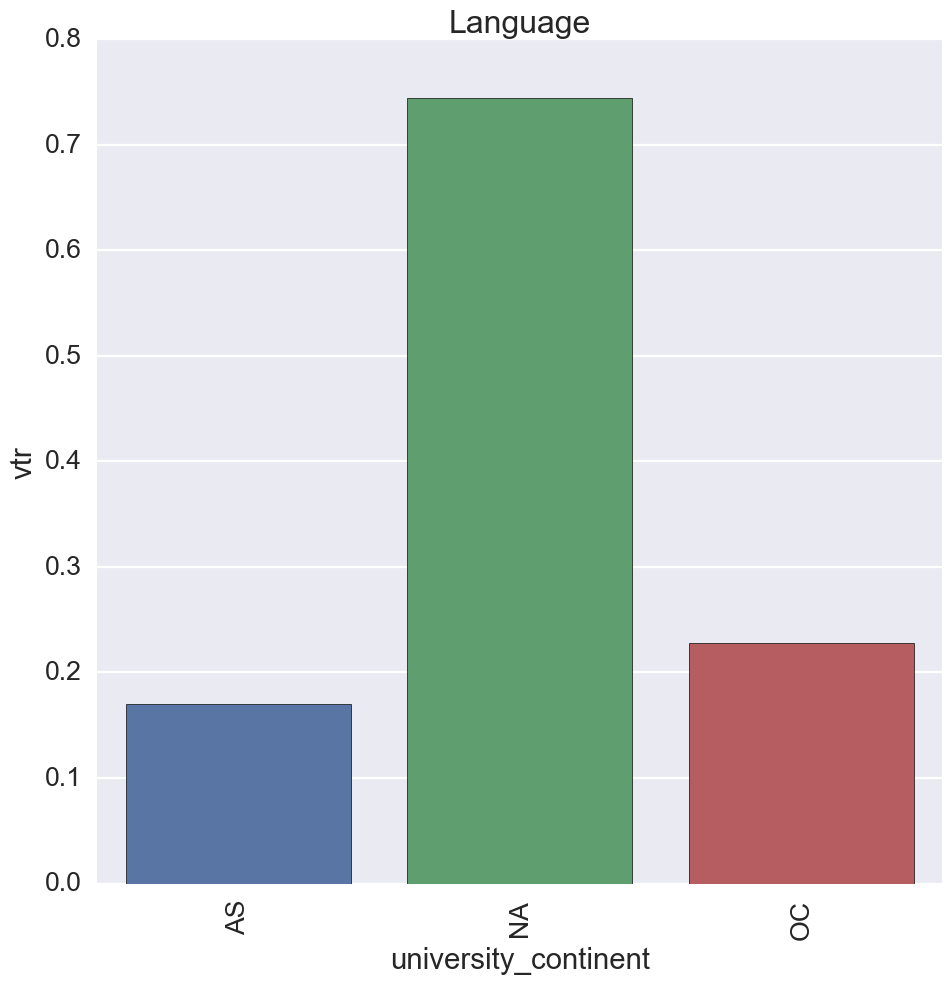

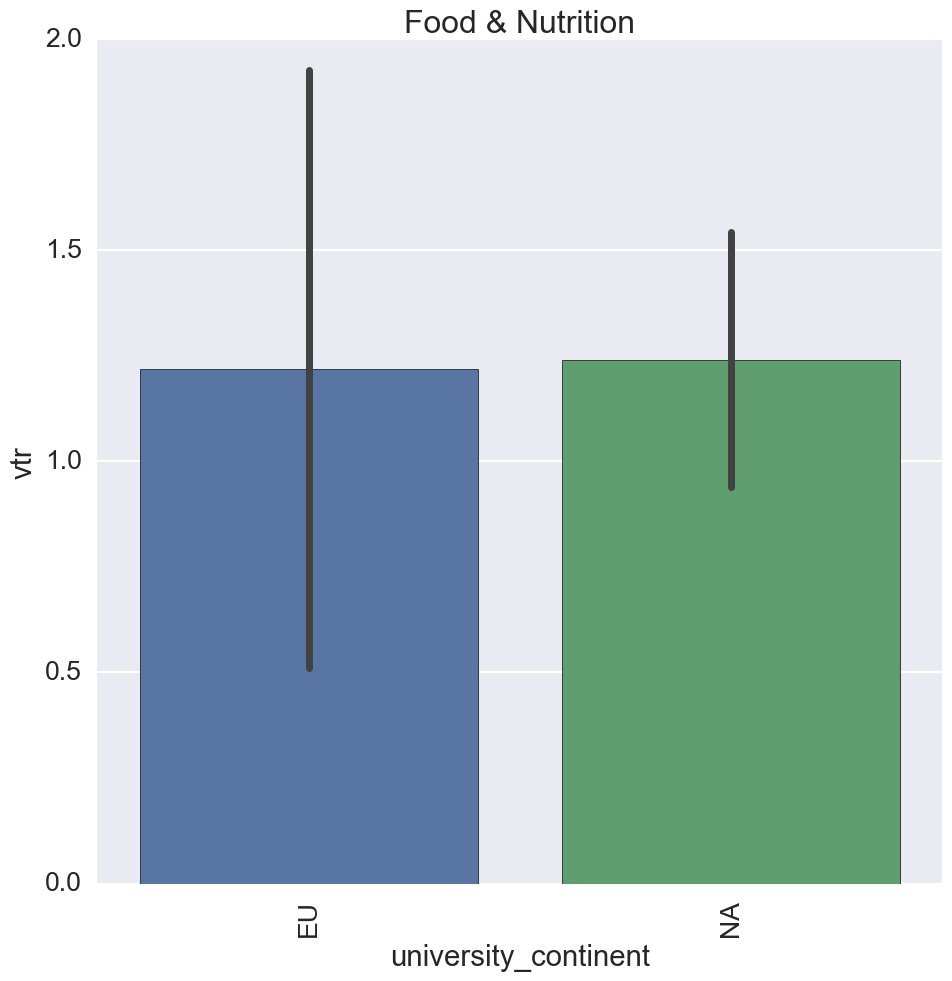

In [323]:
for i in subject_list:
    
    ax = sns.factorplot(data = vtr_agg_subject[vtr_agg_subject['subject_title']==i], y = 'vtr', x = 'university_continent',
              kind = 'bar', size = 10) 
    ax.set(title=i)
    ax.set_xticklabels(rotation=90)